# Comparison of Different Tuning Methods for FFNNs 

Author: Moritz Ahl 

Date: January 2022

Software: Windows 10, Python 3.9, Jupyter Notebook 6.4.5, Tensorflow 2.7.0

This notebook compares several methods which have been proposed by researchers to improve the performance of deep learning tasks. Here, we will implement the following methods:

- normalization or standardization of data 
- batch normalization 
- dropout
- initialization (Glorot)
- L1-regularization
- different activation functions
- different optimizers (all optimizers available in Keras)
- learning rate scheduling! (e.g. 1cycle) -> 'most important hyperparameter'
- different epochs and batch sizes
- resampling (w.r.t. trading volume)

We also shown exemplary implementations of 
- cross-validation
- data preparation with autoencoder





In [1]:
# load standard packages 
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from datetime import timedelta, date
import time 
from tqdm import tqdm

# load statistical packages 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit
import statsmodels.api as sm

# load scalers 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# load basic Keras functions for neural networks
import tensorflow.keras.initializers
from tensorflow.keras.layers import Input, Dense, Layer, LSTM, GRU, SimpleRNN, RNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# load Yahoo!Finance for download of market data
import yfinance as yf

# to display dataframes
from IPython.display import display

In [2]:
# set start and end dates for download of data 
end = datetime.date.today()
start_m = end-timedelta(days=28)
start_d = '2014-9-17'

In [3]:
# create a dictionary for daily and minutely data
data_dict = {
    'daily':{
        'start': start_d, 'end': end, 'interval': '1d',
        'label': 'daily', 'df': None},
    'minutely':{
        'start': start_m, 'end': end, 'interval': '1m',
        'label': 'minutely', 'df': None}
}

Next, we will download the data of interest from Yahoo!Finance. Since Yahoo only allows for a limited amount of data and a restricted time horizon, we request several periods of data and concatenate the dataframes afterwards.

In [4]:
# download Bitcoin [USD] data from Yahoo
tickers='BTC-USD'
for key in data_dict.keys():
    start = data_dict[key]['start']
    end = data_dict[key]['end']
    interval = data_dict[key]['interval']
    
    # download daily data 
    if key == 'daily':
        df = yf.download(tickers=tickers, start=start, end=end, interval=interval)
        df.index = pd.to_datetime(df.index, infer_datetime_format=True)
        
    # download minutely data 
    elif key == 'minutely':
        dates = pd.date_range(start,end,freq='4d')
        df = yf.download(tickers=tickers, start=dates[0], end=dates[1], interval=interval)
        # concatenate data to a single data frame
        for i in range(len(dates)-2):
            df2 = yf.download(tickers=tickers, start=dates[i+1], end=dates[i+2], interval=interval)
            df = pd.concat([df,df2])
    
    # display data frame
    print('\nThe downloaded data for {} on a {} basis in the period from {} to {} is summarized in the following table:'.format(tickers, data_dict[key]['label'], start, end))
    display(df)
    
    # store data frame in dictionary
    data_dict[key]['df'] = df
    

[*********************100%***********************]  1 of 1 completed

The downloaded data for BTC-USD on a daily basis in the period from 2014-9-17 to 2022-01-05 is summarized in the following table:


Open          High           Low         Close  \
Date                                                                 
2017-11-09   7446.830078   7446.830078   7101.520020   7143.580078   
2017-11-10   7173.729980   7312.000000   6436.870117   6618.140137   
2017-11-11   6618.609863   6873.149902   6204.220215   6357.600098   
2017-11-12   6295.450195   6625.049805   5519.009766   5950.069824   
2017-11-13   5938.250000   6811.189941   5844.290039   6559.490234   
...                  ...           ...           ...           ...   
2021-12-31  47169.371094  48472.527344  45819.953125  46306.445312   
2022-01-01  46311.746094  47827.312500  46288.484375  47686.812500   
2022-01-02  47680.925781  47881.406250  46856.937500  47345.218750   
2022-01-03  47343.542969  47510.726562  45835.964844  46458.117188   
2022-01-04  46458.851562  47406.546875  45752.464844  45897.574219   

               Adj Close       Volume  
Date                                   
2017-11-09   7143.580078   3226249984  
2017-11-10   6618.140137   5208249856  
2017-11-11   6357.600098   4908680192  
2017-11-12   5950.069824   8957349888  
2017-11-13   6559.490234   6263249920  
...                  ...          ...  
2021-12-31  46306.445312  36974172400  
2022-01-01  47686.812500  24582667004  
2022-01-02  47345.218750  27951569547  
2022-01-03  46458.117188  33071628362  
2022-01-04  45897.574219  42494677905  

[1518 rows x 6 columns]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

The downloaded data for BTC-USD on a minutely basis in the period from 2021-12-08 to 2022-01-05 is summarized in the following table:


Open          High           Low  \
Datetime                                                              
2021-12-07 23:00:00+00:00  50371.167969  50371.167969  50371.167969   
2021-12-07 23:01:00+00:00  50247.042969  50247.042969  50247.042969   
2021-12-07 23:02:00+00:00  50258.121094  50258.121094  50258.121094   
2021-12-07 23:03:00+00:00  50306.523438  50306.523438  50306.523438   
2021-12-07 23:04:00+00:00  50323.039062  50323.039062  50323.039062   
...                                 ...           ...           ...   
2022-01-04 22:54:00+00:00  46162.136719  46162.136719  46162.136719   
2022-01-04 22:56:00+00:00  46159.144531  46159.144531  46159.144531   
2022-01-04 22:57:00+00:00  46154.355469  46154.355469  46154.355469   
2022-01-04 22:59:00+00:00  46131.257812  46131.257812  46131.257812   
2022-01-04 23:00:00+00:00  46134.847656  46134.847656  46134.847656   

                                  Close     Adj Close   Volume  
Datetime                                                        
2021-12-07 23:00:00+00:00  50371.167969  50371.167969        0  
2021-12-07 23:01:00+00:00  50247.042969  50247.042969        0  
2021-12-07 23:02:00+00:00  50258.121094  50258.121094        0  
2021-12-07 23:03:00+00:00  50306.523438  50306.523438  6838272  
2021-12-07 23:04:00+00:00  50323.039062  50323.039062        0  
...                                 ...           ...      ...  
2022-01-04 22:54:00+00:00  46162.136719  46162.136719        0  
2022-01-04 22:56:00+00:00  46159.144531  46159.144531        0  
2022-01-04 22:57:00+00:00  46154.355469  46154.355469        0  
2022-01-04 22:59:00+00:00  46131.257812  46131.257812        0  
2022-01-04 23:00:00+00:00  46134.847656  46134.847656        0  

[34608 rows x 6 columns]

In [5]:
# check for NaNs dismissed, since no NaNs occured here.

In [6]:
# switch for returns 
returns = True

In [7]:
# compute log returns
for key in data_dict.keys():
    if returns:
        df = data_dict[key]['df']
        
        #Extract the close prices and reshape them into 2d-array
        data = np.array(df['Close'].values)
        data = data.reshape((len(data),1))
        data = data.astype('float32')

        # compute log returns
        z = np.array([0])
        z = z.reshape((1,1))
        ret = np.concatenate((z,np.log(data[1:]/data[:-1])))

        # add to dataframe
        df['Log Return'] = ret

In [8]:
# fix reference period and forecasting horizon
n_steps = 50
n_steps_ahead = 1

In [9]:
# set partition of data that should be used for training
train_weight = 0.8

We now define a function which generates rolling windows of past observations and the next value. In other words, we create what will be the input and desired output of our neural networks.

In [10]:
def rolling_windows(df, n_steps, n_steps_ahead=1):
    ''' 
    Function to create rolling windows of observations which will be used
    as input data for the neural network. n_steps is the amount of days
    we look back into the past to use previous closing prices, while n_steps_ahead 
    determines the forecasting horizon. df is a dataframe downloaded with Yahoo!Finance.
    '''
    # create empty lists to store data 
    x = []
    y = []
    
    data = df.values    
    
    # create rolling windows (input) of last seq_size observations
    # and list with current observatiosn (output)
    for i in range(len(data)-(n_steps+n_steps_ahead-1)):
        window = data[i:(i+n_steps)]
        x.append(window)
        y.append(data[i+n_steps+n_steps_ahead-1])
    
    # transform lists to array for better handling
    x, y = np.array(x), np.array(y)
    
    return x.reshape(x.shape[0], x.shape[1]), y.reshape(y.shape[0],)

Next, we prepare a function which scales the data and stores the scalers for later use..

In [11]:
# load scalers 
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def data_prep(data_dictionary, train_weight=0.8):
    '''
    This function scales the data at hand and stores the scaler
    for later use. 
    data_dictionary: dictionary containing downloaded market data
    and further informations about the data set.
    train_weight: partition of set which should be used as training data
    '''
    data_dict = data_dictionary
    
    # for daily and minutely data perform scaling
    for key in data_dict.keys():
        df = data_dict[key]['df']
        # note that for a multivariate time series, you would need to scale 
        # each variable by its own mean and standard deviation in the training set
        
        # normalize
        scaler2 = MinMaxScaler()
        if returns:
            data = np.array(df['Log Return'].values)
            data = data.reshape(-1,1)
        else:
            data = np.array(df['Close'].values)
            data = data.reshape(-1,1)
        
        # fit scaler to part of data which will be used for training 
        data_train = data[:(int(train_weight*len(data)))]
        data_test = data[(int(train_weight*len(data))):]
        scaled2_train = scaler2.fit_transform(data_train)
        
        # apply scaler to test set and concatenate scaled data
        scaled2_test = scaler2.transform(data_test)
        scaled2 = np.concatenate((scaled2_train, scaled2_test))
        
        # store scaler and scaled values
        data_dict[key]['scaler_norm'] = scaler2
        df['Normalized'] = scaled2
        
        # standardize
        scaler1 = StandardScaler()
        if returns:
            data = np.array(df['Log Return'].values)
            data = data.reshape(-1,1)
        else:
            data = np.array(df['Close'].values)
            data = data.reshape(-1,1)

        # fit scaler to part of data which will be used for training 
        data_train = data[:(int(train_weight*len(data)))]
        data_test = data[(int(train_weight*len(data))):]
        scaled1_train = scaler1.fit_transform(data_train) 
        
        # apply scaler to test set and concatenate scaled data
        scaled1_test = scaler1.transform(data_test)
        scaled1 = np.concatenate((scaled1_train, scaled1_test))
        
        # store scaler and scaled values
        data_dict[key]['scaler_stand'] = scaler1
        df['Standardized'] = scaled1       
                     
        
    return data_dict
        

In [12]:
# apply data preparation to dictionary of interest 
data_dict = data_prep(data_dict)

We now have to split the data into a training and a test set before preparing the data with the above defined functions. 

In [13]:
def data_split(data, n_steps= 20, n_steps_ahead=1, train_weight=0.8):
    '''
    This function splits the data set into a train and 
    a test set.
    data: pandas series of prices/returns
    n_steps: length of reference period
    n_steps_ahead: forecasting horizon
    train_weight: partition of data set used for training 
    '''
    # split data into train and test set    
    split = int(len(data) * train_weight)
    df_train = data.iloc[:split]
    df_test = data.iloc[split:]
        
    # create input and output for NNs with rolling window function
    x_train, y_train = rolling_windows(df_train, n_steps, n_steps_ahead)
    x_test, y_test = rolling_windows(df_test, n_steps, n_steps_ahead)
        
    return x_train, y_train, x_test, y_test

We now want to compare the performance of a feedforward neural network for unscaled, normalized and standardized data for both daily and minutely data of Bitcoin. 

In [14]:
# create dictionary to store information and results 
comp_scaling = {
    'daily': {
        'unscaled':{'data': data_dict['daily']['df']['Log Return'], 'scaler': None},
        'normalized':{'data': data_dict['daily']['df']['Normalized'], 'scaler': data_dict['daily']['scaler_norm']},
        'standardized':{'data': data_dict['daily']['df']['Standardized'], 'scaler': data_dict['daily']['scaler_stand']}
    },
    'minutely': {
        'unscaled':{'data': data_dict['minutely']['df']['Log Return'], 'scaler': None},
        'normalized':{'data': data_dict['minutely']['df']['Normalized'], 'scaler': data_dict['minutely']['scaler_norm']},
        'standardized':{'data': data_dict['minutely']['df']['Standardized'], 'scaler': data_dict['minutely']['scaler_stand']}
    }
}

# split and store data for all combinations of scaling and intervals
for key in comp_scaling.keys(): # daily or minutely
    for key2 in comp_scaling[key].keys(): # unscaled, normalized or standardized
        # load data 
        data = comp_scaling[key][key2]['data']
        # split data 
        x_train, y_train, x_test, y_test = data_split(data,n_steps=n_steps, n_steps_ahead=n_steps_ahead)
        comp_scaling[key][key2]['x_train'] = x_train 
        comp_scaling[key][key2]['y_train'] = y_train 
        comp_scaling[key][key2]['x_test'] = x_test
        comp_scaling[key][key2]['y_test'] = y_test 
    

The following function allows us to quickly generate various feedforward neural networks with different characteristics.

In [31]:
def FFNN(neuron_struc=[30,15,1], bn=False, init=False, l1_reg=0, dropout=0, act_fun='tanh', optimizer='adam'):
    '''
    This function generates and compiles a FFNN with certain properties.
    neuron_struc: list of neurons per layer - min. 3 entries required,
    bn: batch normalization, boolian,
    init: initialization, boolian,
    l1_reg: L1 regularization penalty, float,
    dropout: dropout parameter, boolian,
    act_fun: activation function used in every layer, string,
    optimizer: optimizer of choice, string
    '''
    # minimum three layers required including input and output layer
    if len(neuron_struc) < 3:
        return []
    
    # basic model is of feedforward type
    model = Sequential()
    n_layers = len(neuron_struc)
    
    # first or input layer
    if init:
        model.add(Dense(neuron_struc[0], input_dim=n_steps, activation = act_fun, kernel_initializer=tensorflow.keras.initializers.glorot_normal(seed), bias_initializer=tensorflow.keras.initializers.glorot_normal(seed), kernel_regularizer=l1(l1_reg)))
        if dropout != 0:
            model.add(Dropout(dropout))
        if bn:
            model.add(BatchNormalization())
    else:
        model.add(Dense(neuron_struc[0], input_dim=n_steps, activation = act_fun, kernel_regularizer=l1(l1_reg)))
        if dropout != 0:
            model.add(Dropout(dropout))
        if bn:
            model.add(BatchNormalization())
            
    # inner hidden layers 
    if n_layers > 3:
        for i in range(1,n_layers-2): #input_dim=n_steps, input_shape=(x_train.shape[1], x_train.shape[-1])
            if init:
                model.add(Dense(neuron_struc[i], activation = act_fun, kernel_initializer=tensorflow.keras.initializers.glorot_normal(seed), bias_initializer=tensorflow.keras.initializers.glorot_normal(seed),kernel_regularizer=l1(l1_reg)))
                if dropout != 0:
                    model.add(Dropout(dropout))
                if bn:
                    model.add(BatchNormalization())
            else:
                model.add(Dense(neuron_struc[i], activation = act_fun, kernel_regularizer=l1(l1_reg)))
                if dropout != 0:
                    model.add(Dropout(dropout))
                if bn:
                    model.add(BatchNormalization())
    
    # add final hidden layer
    if init:
        model.add(Dense(neuron_struc[-2], activation = act_fun, kernel_initializer=tensorflow.keras.initializers.glorot_normal(seed), bias_initializer=tensorflow.keras.initializers.glorot_normal(seed),kernel_regularizer=l1(l1_reg)))
        if dropout != 0:
            model.add(Dropout(dropout))
        if bn:
            model.add(BatchNormalization())
    else:
        model.add(Dense(neuron_struc[-2], activation = act_fun, kernel_regularizer=l1(l1_reg))) #, input_shape=(x_train.shape[1], x_train.shape[-1])))
        if dropout != 0:
            model.add(Dropout(dropout))
        if bn:
            model.add(BatchNormalization())
    
    #model.add(Dense(n_units, activation = act_fun, input_shape=(x_train.shape[1], x_train.shape[-1])))
    
    #output layer
    model.add(Dense(neuron_struc[-1], activation = act_fun)) 
        
    # compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['MeanSquaredError'])
    
    return model 
    

In [16]:
model_test = FFNN()
model_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                1530      
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________


In [17]:
# fix epochs and batch size for training 
# discussion on choice of epochs and batch size:
# https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model-in-keras

max_epochs = 75 #150 #250
batch_size = 32 #64 

# different batch size for minutely since more data available
max_epochs_minutely = 50
batch_size_minutely = 64 #128

# early stopping criterion to prevent overfitting 
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=15, min_delta=1e-7, restore_best_weights=True)

Since the fitting procedure in this context is of stochastic nature, we will train the models several times and evaluate the performance with regard to the average performance of all the models. Other possibilities to verify the quality of the fit would be to use variants of cross-validation (cf. discussion in main text of this thesis). 

In [18]:
# fix number of training procedures to determine average performance
runs_to_avg = 10 #20

In [19]:
# create and fit models
for key in comp_scaling.keys(): # daily or minutely
    for key2 in comp_scaling[key].keys(): # unscaled, normalized or standardized
        print(f'Now training the model for {key} data which is {key2}.')
        x_train = comp_scaling[key][key2]['x_train']
        y_train = comp_scaling[key][key2]['y_train']
        
        # train multiple models with identical architecture
        # create containers for results 
        models = []
        times = []
        
        for i in range(runs_to_avg):
            # create new model by function call 
            model = FFNN()
            model.summary()
            # measure fitting time 
            start_time = time.time()
            # bigger batch size for minutely data with more data points
            if key == 'minutely':
                batch_size_here = batch_size_minutely
                max_epochs_here = max_epochs_minutely
            else:
                batch_size_here = batch_size
                max_epochs_here = max_epochs
            # fit model
            model.fit(x_train, y_train, epochs=max_epochs_here, 
                      batch_size=batch_size_here, callbacks=[es], shuffle=False, verbose=1)
            end_time = time.time()
            # store model 
            models.append(model)
            # store training time 
            times.append(end_time-start_time)
            
        comp_scaling[key][key2]['model'] = models
        # store average fitting time 
        comp_scaling[key][key2]['time'] = round(np.mean(times),2) #round(end_time-start_time,2)
        

Now training the model for daily data which is unscaled.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 30)                1530      
                                                                 
 dense_4 (Dense)             (None, 15)                465       
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 3/75
37/37 [=========================

37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 61/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 62/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 63/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 64/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 65/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 66/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 67/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 69/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 45/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 46/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 49/75
37/37 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 50/75
37/37 [==============================] - 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 51/75
37/37 [==============================] - 0s 4ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 53/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 54/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 55/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 56/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 57/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 58/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 59/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 60/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 36/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 37/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 39/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 40/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 41/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 42/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 43/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 44/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 19/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 20/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 22/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 23/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 25/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 27/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 10/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 11/75
37/37 [===================

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0564 - mean_squared_error: 0.0564
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 5/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 7/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 68/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 72/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 73/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 74/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 75/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Model: "sequential_16"
________

 dense_53 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 4ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_

37/37 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035: 0s - loss: 0.0034 - mean_squared_error: 0.00
Epoch 65/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 66/75
37/37 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 67/75
37/37 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0035: 0s - loss: 0.0034 - mean_squared_error
Epoch 68/75
37/37 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/75
37/37 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035: 0s - loss: 0.0034 - mean_squared_error: 0.
Epoch 70/75
37/37 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 71/75
37/37 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 72/7

37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 49/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 51/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 53/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 54/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 55/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 56/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.5323 - mean_squared_error: 0.5323
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.5222 - mean_squared_error: 0.5222
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.5126 - mean_squared_error: 0.5126
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.5034 - mean_squared_error: 0.5034
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.4945 - mean_squared_error: 0.4945
Epoch 35/75
37/37 [==============================] - 0s 2ms/step - loss: 0.4861 - mean_squared_error: 0.4861
Epoch 36/75
37/37 [==============================] - 0s 2ms/step - loss: 0.4780 - mean_squared_error: 0.4780
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.4703 - mean_squared_error: 0.4703
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.4629 - mean_squared_error: 0.4629
Epoch 39/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.7440 - mean_squared_error: 0.7440
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.7309 - mean_squared_error: 0.7309
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.7178 - mean_squared_error: 0.7178
Epoch 17/75
37/37 [==============================] - 0s 2ms/step - loss: 0.7046 - mean_squared_error: 0.7046
Epoch 18/75
37/37 [==============================] - 0s 2ms/step - loss: 0.6916 - mean_squared_error: 0.6916
Epoch 19/75
37/37 [==============================] - 0s 2ms/step - loss: 0.6786 - mean_squared_error: 0.6786
Epoch 20/75
37/37 [==============================] - 0s 2ms/step - loss: 0.6658 - mean_squared_error: 0.6658
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.6531 - mean_squared_error: 0.6531
Epoch 22/75
37/37 [==============================] - 0s 2ms/step - loss: 0.6407 - mean_squared_error: 0.6407
Epoch 23/75
37/37 [============

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 1.1605 - mean_squared_error: 1.1605
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.9854 - mean_squared_error: 0.9854
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.9121 - mean_squared_error: 0.9121
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.8740 - mean_squared_error: 0.8740
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.8483 - mean_squared_error: 0.8483
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.8277 - mean_squared_error: 0.8277
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.8095 - mean_squared_error: 0.8095
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.7927 - mean_squared_error: 0.7927
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.7767 - mean_squared_error: 0.7767
Epoch 10/75
37/37 [=========

Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 1.2312 - mean_squared_error: 1.2312
Epoch 2/75
37/37 [==============================] - 0s 3ms/step - loss: 1.0488 - mean_squared_error: 1.0488
Epoch 3/75
37/37 [==============================] - 0s 3ms/step - loss: 0.9521 - mean_squared_error: 0.9521
Epoch 4/75
37/37 [==============================] - 0s 3ms/step - loss: 0.8994 - mean_squared_error: 0.8994
Epoch 5/75
37/37 [==============================] - 0s 3ms/step - loss: 0.8655 - mean_squared_error: 0.8655
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.8396 - mean_squared_error: 0.8396
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.8178 - mean_squared_error: 0.8178
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.7985 - mean_squared_error: 0.7985
Ep

37/37 [==============================] - 0s 2ms/step - loss: 0.3404 - mean_squared_error: 0.3404
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 30)                1530      
                                                                 
 dense_85 (Dense)            (None, 15)                465       
                                                                 
 dense_86 (Dense)            (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 1.2267 - mean_squared_error: 1.2267
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 1.0579 - mean_squared_error: 1.0579
Ep

37/37 [==============================] - 0s 3ms/step - loss: 0.3794 - mean_squared_error: 0.3794
Epoch 59/75
37/37 [==============================] - 0s 3ms/step - loss: 0.3762 - mean_squared_error: 0.3762
Epoch 60/75
37/37 [==============================] - 0s 3ms/step - loss: 0.3731 - mean_squared_error: 0.3731
Epoch 61/75
37/37 [==============================] - 0s 3ms/step - loss: 0.3701 - mean_squared_error: 0.3701
Epoch 62/75
37/37 [==============================] - 0s 2ms/step - loss: 0.3673 - mean_squared_error: 0.3673
Epoch 63/75
37/37 [==============================] - 0s 2ms/step - loss: 0.3645 - mean_squared_error: 0.3645
Epoch 64/75
37/37 [==============================] - 0s 2ms/step - loss: 0.3619 - mean_squared_error: 0.3619
Epoch 65/75
37/37 [==============================] - 0s 2ms/step - loss: 0.3593 - mean_squared_error: 0.3593
Epoch 66/75
37/37 [==============================] - 0s 2ms/step - loss: 0.3569 - mean_squared_error: 0.3569
Epoch 67/75
37/37 [============

432/432 [==============================] - 1s 2ms/step - loss: 7.9468e-07 - mean_squared_error: 7.9468e-07
Epoch 13/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9056e-07 - mean_squared_error: 7.9056e-07
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8653e-07 - mean_squared_error: 7.8653e-07
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8375e-07 - mean_squared_error: 7.8375e-07
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8254e-07 - mean_squared_error: 7.8254e-07
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8196e-07 - mean_squared_error: 7.8196e-07
Epoch 00017: early stopping
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 30)                1530      
                                                 

Epoch 00017: early stopping
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 30)                1530      
                                                                 
 dense_106 (Dense)           (None, 15)                465       
                                                                 
 dense_107 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 2s 2ms/step - loss: 2.7282e-06 - mean_squared_error: 2.7282e-06
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 8.7418e-07 - mean_squared_error: 8.7418e-07
Epoch 3/50
432/432 [==============================]

432/432 [==============================] - 1s 2ms/step - loss: 7.9271e-07 - mean_squared_error: 7.9271e-07
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8939e-07 - mean_squared_error: 7.8939e-07
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8601e-07 - mean_squared_error: 7.8601e-07
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8362e-07 - mean_squared_error: 7.8362e-07
Epoch 00017: early stopping
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 30)                1530      
                                                                 
 dense_121 (Dense)           (None, 15)                465       
                                                                 
 dense_122 (Dense)           (None, 1)                 16        
                       

432/432 [==============================] - 1s 2ms/step - loss: 7.3933e-04 - mean_squared_error: 7.3933e-04
Epoch 43/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3924e-04 - mean_squared_error: 7.3924e-04
Epoch 44/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3917e-04 - mean_squared_error: 7.3917e-04
Epoch 45/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3910e-04 - mean_squared_error: 7.3910e-04
Epoch 46/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3903e-04 - mean_squared_error: 7.3903e-04
Epoch 47/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3897e-04 - mean_squared_error: 7.3897e-04
Epoch 48/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3892e-04 - mean_squared_error: 7.3892e-04
Epoch 49/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3887e-04 - mean_squared_error: 7.3887e-04
Epoch 50/50
432/432 [==============================] - 1s 2m

Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 9.8961e-04 - mean_squared_error: 9.8961e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 8.7806e-04 - mean_squared_error: 8.7806e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 8.2304e-04 - mean_squared_error: 8.2304e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9371e-04 - mean_squared_error: 7.9371e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7757e-04 - mean_squared_error: 7.7757e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6923e-04 - mean_squared_error: 7.6923e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss

432/432 [==============================] - 1s 2ms/step - loss: 7.4858e-04 - mean_squared_error: 7.4858e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4752e-04 - mean_squared_error: 7.4752e-04
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4607e-04 - mean_squared_error: 7.4607e-04
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4447e-04 - mean_squared_error: 7.4447e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4311e-04 - mean_squared_error: 7.4311e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4208e-04 - mean_squared_error: 7.4208e-04
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4130e-04 - mean_squared_error: 7.4130e-04: 0s - loss: 0.0010 - me
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4071e-04 - mean_squared_error: 7.4071e-04
Epoch 21/50
432/432 [===============

432/432 [==============================] - 1s 2ms/step - loss: 7.3767e-04 - mean_squared_error: 7.3767e-04: 0s - loss: 8.7337e-04 - mean_s
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3747e-04 - mean_squared_error: 7.3747e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3729e-04 - mean_squared_error: 7.3729e-04
Epoch 36/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3712e-04 - mean_squared_error: 7.3712e-04
Epoch 37/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3696e-04 - mean_squared_error: 7.3696e-04
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3682e-04 - mean_squared_error: 7.3682e-04
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3669e-04 - mean_squared_error: 7.3669e-04
Epoch 40/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3658e-04 - mean_squared_error: 7.3658e-04
Epoch 41/50
432/432 [=======

Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 9.1129e-04 - mean_squared_error: 9.1129e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 8.3675e-04 - mean_squared_error: 8.3675e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9966e-04 - mean_squared_error: 7.9966e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7809e-04 - mean_squared_error: 7.7809e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6628e-04 - mean_squared_error: 7.6628e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5942e-04 - mean_squared_

432/432 [==============================] - 1s 2ms/step - loss: 0.9116 - mean_squared_error: 0.9116
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9097 - mean_squared_error: 0.9097
Epoch 28/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9077 - mean_squared_error: 0.9077
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9059 - mean_squared_error: 0.9059
Epoch 30/50
432/432 [==============================] - 1s 3ms/step - loss: 0.9040 - mean_squared_error: 0.9040
Epoch 31/50
432/432 [==============================] - 1s 3ms/step - loss: 0.9023 - mean_squared_error: 0.9023: 0s - loss: 0.9422 - mean_squared_e
Epoch 32/50
432/432 [==============================] - 1s 3ms/step - loss: 0.9006 - mean_squared_error: 0.9006
Epoch 33/50
432/432 [==============================] - 1s 3ms/step - loss: 0.8990 - mean_squared_error: 0.8990
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8974 - mean

Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 1.0641 - mean_squared_error: 1.0641
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 1.0037 - mean_squared_error: 1.0037
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9918 - mean_squared_error: 0.9918
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9847 - mean_squared_error: 0.9847
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9796 - mean_squared_error: 0.9796
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9751 - mean_squared_error: 0.9751
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9709 - mean_squared_error: 0.9709
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9667 - mean_squared_error: 0.9667: 0s - loss: 0.9822 - mean_squared_error: 
Epoch 9/50
432/432 [==============================] - ETA: 0s - loss: 0.9606 -

432/432 [==============================] - 1s 2ms/step - loss: 0.8978 - mean_squared_error: 0.8978
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8962 - mean_squared_error: 0.8962
Epoch 32/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8946 - mean_squared_error: 0.8946
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8931 - mean_squared_error: 0.8931
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8916 - mean_squared_error: 0.8916
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8902 - mean_squared_error: 0.8902
Epoch 36/50
432/432 [==============================] - 1s 3ms/step - loss: 0.8888 - mean_squared_error: 0.8888
Epoch 37/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8874 - mean_squared_error: 0.8874
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 0.8861 - mean_squared_error: 0.8861
Epoch 39/50
4

432/432 [==============================] - 1s 2ms/step - loss: 0.9828 - mean_squared_error: 0.9828
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9777 - mean_squared_error: 0.9777: 0s - loss: 0.9857 - mean_squared_error: 0.98
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9729 - mean_squared_error: 0.9729
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9682 - mean_squared_error: 0.9682
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss: 0.9635 - mean_squared_error: 0.9635
Epoch 9/50
432/432 [==============================] - 1s 3ms/step - loss: 0.9588 - mean_squared_error: 0.9588
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9541 - mean_squared_error: 0.9541
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9494 - mean_squared_error: 0.9494
Epoch 12/50
432/432 [==============================] - 1s 2ms/step - loss: 0.9450 -

Next, we would like to make prediction using the test data set in particular to verify the generalization power of the networks. Note that the some of the data has been scaled and we will thus need to unscale the predictions before computing the perfromance with the MSE.

In [20]:
def predict_unscale(dictionary, scaler):
    '''
    This function creates predictions while also dealing with 
    possible scaling and unscaling.
    dictionary: dictionary created with procedures above 
    scaler: scaler used to initally scale data 
    '''
    # extract needed data from dict
    x_train = dictionary['x_train']
    y_train = dictionary['y_train']
    x_test = dictionary['x_test']
    y_test = dictionary['y_test']
    scaler = dictionary['scaler']
    model = dictionary['model'] # here list of models
    
    # if data has been scaled in any form 
    if scaler is not None:
        # unscale data 
        y_train_inv = scaler.inverse_transform(y_train.reshape(-1,1))
        y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))

        # store unscaled data
        dictionary['y_train_inv'] = y_train_inv
        dictionary['y_test_inv'] = y_test_inv

        # make predictions and unscale
        mses_train = []
        mses_test = []
        for i in range(runs_to_avg):
            # training set 
            y_pred_train = model[i].predict(x_train, verbose=1)
            y_pred_train_inv = scaler.inverse_transform(y_pred_train) 
            mses_train.append(mean_squared_error(y_train_inv, y_pred_train_inv))
            
            # test set 
            y_pred_test = model[i].predict(x_test, verbose=1)
            y_pred_test_inv = scaler.inverse_transform(y_pred_test)
            mses_test.append(mean_squared_error(y_test_inv, y_pred_test_inv))

        # MSE errors 
        dictionary['mse_train'] = np.mean(mses_train)
        dictionary['mse_test'] = np.mean(mses_test)
    
    # for unscaled data
    if scaler is None:
        # make predictions with all models
        mses_train = []
        mses_test = []
        for i in range(runs_to_avg):
            # training set
            y_pred_train = model[i].predict(x_train, verbose=1)
            mses_train.append(mean_squared_error(y_train, y_pred_train))
            
            # test set 
            y_pred_test = model[i].predict(x_test, verbose=1)
            mses_test.append(mean_squared_error(y_test, y_pred_test))
        
        # MSE errors 
        dictionary['mse_train'] = np.mean(mses_train)
        dictionary['mse_test'] = np.mean(mses_test)

In [21]:
# make predictions and unscale them if needed 
for key in comp_scaling.keys():
    for key2 in comp_scaling[key].keys():
        # call scaler 
        scaler = comp_scaling[key][key2]['scaler']
        # predict and unscale with function from above
        predict_unscale(comp_scaling[key][key2], scaler)

215/215 [==============================] - 0s 2ms/step


After the (unscaled) predictions have been generated, we display the results in a Pandas table. 

In [22]:
# display results in tables
for key in comp_scaling.keys(): # daily or minutely 
    print('\nThe results for the', key,'data is summarized in the following table:')
    # create data frame containing the results 
    table = pd.DataFrame(
        [comp_scaling[key][key2]['time'], '{:.3e}'.format(comp_scaling[key][key2]['mse_train']), '{:.3e}'.format(comp_scaling[key][key2]['mse_test'])] for key2 in comp_scaling[key].keys()
    )
    # rename columns and indices as desired 
    table = table.rename(index={0: 'Unscaled', 1: 'Normalized', 2: 'Standardized'})
    table = table.rename(columns={0: 'Fitting Time', 1: 'MSE Training', 2: 'MSE Testing'})
    
    # show table 
    display(table)



The results for the daily data is summarized in the following table:


Fitting Time MSE Training MSE Testing
Unscaled              6.55    1.593e-03   1.678e-03
Normalized            8.53    1.730e-03   1.774e-03
Standardized          7.63    5.868e-04   2.338e-03


The results for the minutely data is summarized in the following table:


Fitting Time MSE Training MSE Testing
Unscaled             19.29    7.791e-07   3.428e-07
Normalized           48.39    7.568e-07   3.214e-07
Standardized         49.69    6.555e-07   3.780e-07

Attention: this only works when running for the first time since we add another key in the loop.

We observe that the model performs best with normalized data. This observation coincides with most of the literature and we will thus use normalized return data in the following.

Note (once again): Because of the stochastic nature of the fitting process using the Adam algorithm, the results might vary when rerunning the testing!

In [23]:
# normalized daily data used for future models 
x_train_d = comp_scaling['daily']['normalized']['x_train']
x_test_d = comp_scaling['daily']['normalized']['x_test']
y_train_d = comp_scaling['daily']['normalized']['y_train']
y_train_inv_d = comp_scaling['daily']['normalized']['y_train_inv']
y_test_d = comp_scaling['daily']['normalized']['y_test']
y_test_inv_d = comp_scaling['daily']['normalized']['y_test_inv']
scaler_d = comp_scaling['daily']['normalized']['scaler']
time_d = comp_scaling['daily']['normalized']['time']
mse_train_d = comp_scaling['daily']['normalized']['mse_train']
mse_test_d = comp_scaling['daily']['normalized']['mse_test']

# normalized minutely data used for future models
x_train_m = comp_scaling['minutely']['normalized']['x_train']
x_test_m = comp_scaling['minutely']['normalized']['x_test']
y_train_m = comp_scaling['minutely']['normalized']['y_train']
y_train_inv_m = comp_scaling['minutely']['normalized']['y_train_inv']
y_test_m = comp_scaling['minutely']['normalized']['y_test']
y_test_inv_m = comp_scaling['minutely']['normalized']['y_test_inv']
scaler_m = comp_scaling['minutely']['normalized']['scaler']
time_m = comp_scaling['minutely']['normalized']['time']
mse_train_m = comp_scaling['minutely']['normalized']['mse_train']
mse_test_m = comp_scaling['minutely']['normalized']['mse_test']

In the following we will verify if the other tuning methods have a positive impact on the generalization performance. To simplify the process, we define a function which summarizes the procedure above and displays the results in a table.

In [24]:
def quick_proc(model, data, lr_scheduler=None):
    '''
    This function summarizes the procedures above to compare the effect
    of the different tuning methods of interest.
    model: a FFNN created with Keras
    data: daily or minutely data from data frame 
    lr_scheduler: Keras learning rate scheduler (optional)
    '''
    # collect training and test data 
    if data == 'daily':
        x_train, y_train, x_test, y_train_inv, y_test_inv = x_train_d, y_train_d, x_test_d, y_train_inv_d, y_test_inv_d
        scaler = scaler_d
    elif data == 'minutely':
        x_train, y_train, x_test, y_train_inv, y_test_inv = x_train_m, y_train_m, x_test_m, y_train_inv_m, y_test_inv_m
        scaler = scaler_m
        
    # add learning rate schedule to callbacks if desired 
    if lr_scheduler is None:
        callbacks = [es]
    else:    
        callbacks = [es, lr_scheduler]
    
    # fit model with training data 
    start_time = time.time()
    if data == 'minutely':
        batch_size_here = batch_size_minutely
        max_epochs_here = max_epochs_minutely
    else:
        batch_size_here = batch_size
        max_epochs_here = max_epochs
    model.fit(x_train, y_train, epochs=max_epochs_here, 
                    batch_size=batch_size_here, callbacks=callbacks, shuffle=False)
    end_time = time.time()
    time1 = end_time - start_time
    
    # make predictions, take scaling into account 
    y_pred_train = model.predict(x_train, verbose=1)
    y_pred_train_inv = scaler.inverse_transform(y_pred_train)

    y_pred_test = model.predict(x_test, verbose=1)
    y_pred_test_inv = scaler.inverse_transform(y_pred_test)

    # MSE errors 
    mse_train = mean_squared_error(y_train_inv, y_pred_train_inv)
    mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
    
    return time1, mse_train, mse_test

In [25]:
def table_comp(labels, data_d, data_m):
    '''
    This function displays the results of the comparison
    in a Pandas data frame including the fitting time.
    labels: list of names of indices 
    data_d: array of results for daily data 
    data_m: array of results for minutely data 
    '''
    
    # daily data results 
    print('\nThe results for the daily data is summarized in the following table:')
    table_d = pd.DataFrame({'MSE Training':['{:.3e}'.format(mse_train_d),'{:.3e}'.format(data_d[1])],'MSE Testing':['{:.3e}'.format(mse_test_d), '{:.3e}'.format(data_d[2])], 'Fitting Time':[round(time_d,2), round(data_d[0],2)]}, labels)
    display(table_d)
    
    # daily data results 
    print('\nThe results for the minutely data is summarized in the following table:')
    table_m = pd.DataFrame({'MSE Training':['{:.3e}'.format(mse_train_m),'{:.3e}'.format(data_m[1])],'MSE Testing':['{:.3e}'.format(mse_test_m), '{:.3e}'.format(data_m[2])], 'Fitting Time':[round(time_m,2), round(data_m[0],2)]}, labels)
    display(table_m)

# Batch Normalization

Batch normalization uses normalization after every hidden layer to avoid exploding gradients. 

We refer to the main text of this thesis for detailed theory and further explanations on batch normalization and other tuning methods presented in the following. Moreover, the interpretation of the results can also be found in the main text.

In [26]:
# daily data 
# create containers for results of models  
mses_train_d, mses_test_d, times_d = [], [], []
# train and evaluate several models 
for i in range(runs_to_avg):
    model = FFNN(bn=True)
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='daily')
    times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    
# performance given by average of single model performances 
results_bn_d = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]

# minutely data
# create containers for results of models
mses_train_m, mses_test_m, times_m = [], [], []
# train and evaluate several models 
for i in range(runs_to_avg):
    model = FFNN(bn=True)
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='minutely')
    times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    
# performance given by average of single model performances
results_bn_m = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_183 (Dense)           (None, 30)                1530      
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dense_184 (Dense)           (None, 15)                465       
                                                                 
 batch_normalization_1 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dense_185 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,191
Trainable params: 2,101
Non-train

37/37 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 66/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 67/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 68/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 69/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 70/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 71/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 72/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 73/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 74/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 42/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 43/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 46/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 47/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 48/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 49/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 50/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 18/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 19/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 20/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 21/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 22/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 23/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 24/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 25/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 26/75
37/37 [============

Epoch 1/75
37/37 [==============================] - 1s 3ms/step - loss: 0.9336 - mean_squared_error: 0.9336
Epoch 2/75
37/37 [==============================] - 0s 3ms/step - loss: 0.4085 - mean_squared_error: 0.4085
Epoch 3/75
37/37 [==============================] - 0s 3ms/step - loss: 0.1231 - mean_squared_error: 0.1231
Epoch 4/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0513 - mean_squared_error: 0.0513
Epoch 5/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0274 - mean_squared_error: 0.0274
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 8/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 9/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0108 - mean_squared_error: 0.0108
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 65/75
37/37 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 66/75
37/37 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 67/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 68/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 69/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 70/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 71/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 72/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 73/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 41/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 42/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 43/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 44/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 45/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 46/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 47/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 48/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 49/75
37/37 [============

Epoch 32/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0691e-04 - mean_squared_error: 7.0691e-04
Epoch 33/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0498e-04 - mean_squared_error: 7.0498e-04
Epoch 34/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0362e-04 - mean_squared_error: 7.0362e-04
Epoch 35/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0260e-04 - mean_squared_error: 7.0260e-04
Epoch 36/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0176e-04 - mean_squared_error: 7.0176e-04
Epoch 37/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0102e-04 - mean_squared_error: 7.0102e-04
Epoch 38/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0032e-04 - mean_squared_error: 7.0032e-04
Epoch 39/50
432/432 [==============================] - 1s 3ms/step - loss: 6.9963e-04 - mean_squared_error: 6.9963e-04
Epoch 40/50
432/432 [===========================

432/432 [==============================] - 1s 3ms/step - loss: 6.9533e-04 - mean_squared_error: 6.9533e-04
Epoch 47/50
432/432 [==============================] - 1s 3ms/step - loss: 6.9407e-04 - mean_squared_error: 6.9407e-04
Epoch 48/50
432/432 [==============================] - 1s 3ms/step - loss: 6.9278e-04 - mean_squared_error: 6.9278e-04
Epoch 49/50
432/432 [==============================] - 1s 3ms/step - loss: 6.9143e-04 - mean_squared_error: 6.9143e-04
Epoch 50/50
215/215 [==============================] - 0s 1ms/step
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_225 (Dense)           (None, 30)                1530      
                                                                 
 batch_normalization_28 (Bat  (None, 30)               120       
 chNormalization)                                                
                                                  

Epoch 1/50
432/432 [==============================] - 2s 3ms/step - loss: 0.0593 - mean_squared_error: 0.0593
Epoch 2/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 3/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 5/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 7/50
432/432 [==============================] - 1s 3ms/step - loss: 9.1690e-04 - mean_squared_error: 9.1690e-04
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss: 8.6763e-04 - mean_squared_error: 8.6763e-04
Epoch 9/50
432/432 [==============================] - 1s 3ms/step - loss: 8.3685e-04 - mean_squared_erro

Epoch 9/50
432/432 [==============================] - 1s 3ms/step - loss: 8.6286e-04 - mean_squared_error: 8.6286e-04
Epoch 10/50
432/432 [==============================] - 1s 3ms/step - loss: 8.3265e-04 - mean_squared_error: 8.3265e-04
Epoch 11/50
432/432 [==============================] - 1s 3ms/step - loss: 8.1183e-04 - mean_squared_error: 8.1183e-04
Epoch 12/50
432/432 [==============================] - 1s 3ms/step - loss: 7.9732e-04 - mean_squared_error: 7.9732e-04
Epoch 13/50
432/432 [==============================] - 1s 3ms/step - loss: 7.8672e-04 - mean_squared_error: 7.8672e-04
Epoch 14/50
432/432 [==============================] - 1s 3ms/step - loss: 7.7853e-04 - mean_squared_error: 7.7853e-04
Epoch 15/50
432/432 [==============================] - 1s 3ms/step - loss: 7.7195e-04 - mean_squared_error: 7.7195e-04
Epoch 16/50
432/432 [==============================] - 1s 3ms/step - loss: 7.6635e-04 - mean_squared_error: 7.6635e-04
Epoch 17/50
432/432 [============================

432/432 [==============================] - 1s 3ms/step - loss: 7.2176e-04 - mean_squared_error: 7.2176e-04
Epoch 24/50
432/432 [==============================] - 1s 3ms/step - loss: 7.1890e-04 - mean_squared_error: 7.1890e-04
Epoch 25/50
432/432 [==============================] - 1s 3ms/step - loss: 7.1625e-04 - mean_squared_error: 7.1625e-04
Epoch 26/50
432/432 [==============================] - 1s 3ms/step - loss: 7.1367e-04 - mean_squared_error: 7.1367e-04
Epoch 27/50
432/432 [==============================] - 1s 3ms/step - loss: 7.1106e-04 - mean_squared_error: 7.1106e-04
Epoch 28/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0839e-04 - mean_squared_error: 7.0839e-04
Epoch 29/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0570e-04 - mean_squared_error: 7.0570e-04
Epoch 30/50
432/432 [==============================] - 1s 3ms/step - loss: 7.0300e-04 - mean_squared_error: 7.0300e-04
Epoch 31/50
432/432 [==============================] - 1s 3m

In [27]:
# display results in table using above defined function
labels = ['Without BN', 'With BN']
table_comp(labels, results_bn_d, results_bn_m)


The results for the daily data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without BN    1.730e-03   1.774e-03          8.53
With BN       3.229e-03   4.813e-03          9.43


The results for the minutely data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without BN    7.568e-07   3.214e-07         48.39
With BN       1.071e-06   6.446e-07         59.94

# Dropout

The idea of dropout is to deactivated a fraction of the neurons while training to force the model to learn in a more general way.

In [28]:
#daily data 
mses_train_d, mses_test_d, times_d = [], [], []
for i in range(runs_to_avg):
    model = FFNN(dropout=0.2)
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='daily')
    times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
results_drop_d = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]

# minutely data
mses_train_m, mses_test_m, times_m = [], [], []
for i in range(runs_to_avg):
    model = FFNN(dropout=0.2)
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='minutely')
    times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
results_drop_m = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_243 (Dense)           (None, 30)                1530      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_244 (Dense)           (None, 15)                465       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_245 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] -

37/37 [==============================] - 0s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 55/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 56/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 57/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 58/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 59/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 60/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 61/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 62/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 63/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 33/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 35/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 36/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 37/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 39/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 40/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 41/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0297 - mean_squared_error: 0.0297
Epoch 11/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0258 - mean_squared_error: 0.0258
Epoch 12/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 13/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 14/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0137 - mean_squared_error: 0.0137
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 17/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 18/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 19/75
37/37 [============

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 2/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0494 - mean_squared_error: 0.0494
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0276 - mean_squared_error: 0.0276
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0115 - mean_squared_error: 0.0115
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 65/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 66/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 67/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 72/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 73/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 44/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 46/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 49/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 50/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 51/75
37/37 [============

432/432 [==============================] - 1s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 9.2472e-04 - mean_squared_error: 9.2472e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 8.5869e-04 - mean_squared_error: 8.5869e-04
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss: 8.2958e-04 - mean_squared_error: 8.2958e-04
Epoch 9/50
432/432 [==============================] - 1s 3ms/step - loss: 8.0148e-04 - mean_squared_error: 8.0148e-04
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8525e-04 - mean_squared_error: 7.8525e-04
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7186e-04 - mean_squared_error: 7.7186e-04: 0s - loss: 0.0010 - 
Epoch 12/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6260e-04 - mean_squared_error: 7.6260e-04
Epoch 13/50
432/432 [=============================

432/432 [==============================] - 1s 3ms/step - loss: 7.2623e-04 - mean_squared_error: 7.2623e-04
Epoch 33/50
432/432 [==============================] - 1s 3ms/step - loss: 7.2639e-04 - mean_squared_error: 7.2639e-04
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2625e-04 - mean_squared_error: 7.2625e-04
Epoch 35/50
432/432 [==============================] - 1s 3ms/step - loss: 7.2631e-04 - mean_squared_error: 7.2631e-04
Epoch 36/50
432/432 [==============================] - 1s 3ms/step - loss: 7.2609e-04 - mean_squared_error: 7.2609e-04
Epoch 37/50
432/432 [==============================] - 1s 3ms/step - loss: 7.2574e-04 - mean_squared_error: 7.2574e-04
Epoch 38/50
432/432 [==============================] - 1s 3ms/step - loss: 7.2654e-04 - mean_squared_error: 7.2654e-04
Epoch 00038: early stopping
215/215 [==============================] - 0s 1ms/step
Model: "sequential_96"
_________________________________________________________________
 Layer 

Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 2s 3ms/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 2/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 3/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 4/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011: 0s - loss: 0.0013 - mean
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 9.5443e-04 - mean_squared_error: 9.5443e-04
Epoch 7/50
432/432 [==============================] - 1s 3ms/step - loss: 9.0588e-04 - mean_squared_error: 9.0588e-04
Epoch 8/50
432/432 [==============================] - 

432/432 [==============================] - 1s 3ms/step - loss: 7.2551e-04 - mean_squared_error: 7.2551e-04: 0s - loss: 9.4
Epoch 38/50
432/432 [==============================] - 1s 3ms/step - loss: 7.2572e-04 - mean_squared_error: 7.2572e-04
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2567e-04 - mean_squared_error: 7.2567e-04
Epoch 40/50
432/432 [==============================] - 1s 3ms/step - loss: 7.2544e-04 - mean_squared_error: 7.2544e-04
Epoch 41/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2554e-04 - mean_squared_error: 7.2554e-04
Epoch 42/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2522e-04 - mean_squared_error: 7.2522e-04: 0s - loss: 9.2774e-04 - mean_squ
Epoch 43/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2505e-04 - mean_squared_error: 7.2505e-04
Epoch 44/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2492e-04 - mean_squared_error: 7.2492e-04: 0s - loss

In [29]:
labels = ['Without Dropout', 'With Dropout (0.2)']
table_comp(labels, results_drop_d, results_drop_m)


The results for the daily data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without Dropout       1.730e-03   1.774e-03          8.53
With Dropout (0.2)    1.651e-03   1.688e-03          7.87


The results for the minutely data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without Dropout       7.568e-07   3.214e-07         48.39
With Dropout (0.2)    7.496e-07   3.140e-07         42.61

# Initialization (Glorot normal)

Initializaion randomly sets the values of the weights before being trained. This helps to avoid running into troubles when training the model in particular if all values of a single layer are identically initialized.

In [32]:
# set seed
seed = 0

#daily data 
mses_train_d, mses_test_d, times_d = [], [], []
for i in range(runs_to_avg):
    model = FFNN(init=True)
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='daily')
    times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
results_init_d = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]

# minutely data
mses_train_m, mses_test_m, times_m = [], [], []
for i in range(runs_to_avg):
    model = FFNN(init=True)
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='minutely')
    times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
results_init_m = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]

Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_304 (Dense)           (None, 30)                1530      
                                                                 
 dense_305 (Dense)           (None, 15)                465       
                                                                 
 dense_306 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_erro

37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 61/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 62/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 63/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 64/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 65/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 66/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 67/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 68/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 42/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 43/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 44/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 45/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 46/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 48/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 49/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 24/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 25/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 26/75
37/37 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.00 - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 28/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 29/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_s

Epoch 14/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 17/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 18/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 19/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 20/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 22/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 23/75
37/37 [

37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 11/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 12/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 13/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 14/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 17/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 18/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 19/75
37/37 [============

Epoch 1/50
432/432 [==============================] - 2s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 8.3717e-04 - mean_squared_error: 8.3717e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9213e-04 - mean_squared_error: 7.9213e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7819e-04 - mean_squared_error: 7.7819e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7097e-04 - mean_squared_error: 7.7097e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6631e-04 - mean_squared_error: 7.6631e-04
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss: 7.6290e-04 - mean_squared_error: 7.6290e-04
Epoch 9/50
432/432 [==============================] - 1s 3ms/step - loss

432/432 [==============================] - 1s 2ms/step - loss: 7.9240e-04 - mean_squared_error: 7.9240e-04
Epoch 13/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8853e-04 - mean_squared_error: 7.8853e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8494e-04 - mean_squared_error: 7.8494e-04
Epoch 15/50
432/432 [==============================] - 1s 3ms/step - loss: 7.8148e-04 - mean_squared_error: 7.8148e-04
Epoch 16/50
432/432 [==============================] - 1s 3ms/step - loss: 7.7808e-04 - mean_squared_error: 7.7808e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7453e-04 - mean_squared_error: 7.7453e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7095e-04 - mean_squared_error: 7.7095e-04: 1s - loss: 8.647
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6774e-04 - mean_squared_error: 7.6774e-04
Epoch 20/50
432/432 [=====================

432/432 [==============================] - 1s 2ms/step - loss: 7.4566e-04 - mean_squared_error: 7.4566e-04
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4476e-04 - mean_squared_error: 7.4476e-04
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4391e-04 - mean_squared_error: 7.4391e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4315e-04 - mean_squared_error: 7.4315e-04
Epoch 36/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4247e-04 - mean_squared_error: 7.4247e-04
Epoch 37/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4187e-04 - mean_squared_error: 7.4187e-04
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4135e-04 - mean_squared_error: 7.4135e-04
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4089e-04 - mean_squared_error: 7.4089e-04
Epoch 40/50
432/432 [==============================] - 1s 2m

215/215 [==============================] - 0s 2ms/step
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_352 (Dense)           (None, 30)                1530      
                                                                 
 dense_353 (Dense)           (None, 15)                465       
                                                                 
 dense_354 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 2s 3ms/step - loss: 0.0135 - mean_squared_error: 0.0135: 0s - loss: 0
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 9.5638e-04 - mean_squared_error: 9.5638e-04
Epoch 3/50
432/43

432/432 [==============================] - 1s 2ms/step - loss: 7.4957e-04 - mean_squared_error: 7.4957e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4854e-04 - mean_squared_error: 7.4854e-04
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4771e-04 - mean_squared_error: 7.4771e-04
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4711e-04 - mean_squared_error: 7.4711e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4599e-04 - mean_squared_error: 7.4599e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4508e-04 - mean_squared_error: 7.4508e-04
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4450e-04 - mean_squared_error: 7.4450e-04
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4337e-04 - mean_squared_error: 7.4337e-04
Epoch 21/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 7.4118e-04 - mean_squared_error: 7.4118e-04
Epoch 25/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4024e-04 - mean_squared_error: 7.4024e-04
Epoch 26/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3955e-04 - mean_squared_error: 7.3955e-04
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3907e-04 - mean_squared_error: 7.3907e-04
Epoch 28/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3878e-04 - mean_squared_error: 7.3878e-04
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3858e-04 - mean_squared_error: 7.3858e-04
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3841e-04 - mean_squared_error: 7.3841e-04
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3820e-04 - mean_squared_error: 7.3820e-04
Epoch 32/50
432/432 [==============================] - 1s 2m

In [33]:
labels = ['Without Initialization', 'With Glorot Initialization']
table_comp(labels, results_init_d, results_init_m)


The results for the daily data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without Initialization        1.730e-03   1.774e-03          8.53
With Glorot Initialization    1.772e-03   1.805e-03          7.92


The results for the minutely data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without Initialization        7.568e-07   3.214e-07         48.39
With Glorot Initialization    7.587e-07   3.229e-07         47.04

# Regularization (L1)

Regularization penalizes extensive use of parameters and thus helps to avoid overfitting.

In [34]:
regul_dict = {
    '0.1':{'lamb': 0.1, 'results_d': None, 'results_m': None},
    '0.01':{'lamb': 0.01, 'results_d': None, 'results_m': None},
    '0.001':{'lamb': 0.001, 'results_d': None, 'results_m': None}   
}


In [35]:
for key in regul_dict.keys():
    lamb = regul_dict[key]['lamb']
    
    #daily data
    mses_train_d, mses_test_d, times_d = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(l1_reg=lamb)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='daily')
        times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    regul_dict[key]['results_d'] = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]
     

    # minutely data
    mses_train_m, mses_test_m, times_m = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(l1_reg=lamb)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='minutely')
        times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    regul_dict[key]['results_m'] = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]
    


Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_364 (Dense)           (None, 30)                1530      
                                                                 
 dense_365 (Dense)           (None, 15)                465       
                                                                 
 dense_366 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 25.9280 - mean_squared_error: 0.0802
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 19.7747 - mean_squared_error: 0.0310
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 14.3913 - mean_squared_e

37/37 [==============================] - 0s 2ms/step - loss: 0.2083 - mean_squared_error: 0.0035
Epoch 10/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0608 - mean_squared_error: 0.0035
Epoch 11/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0272 - mean_squared_error: 0.0035
Epoch 12/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0253 - mean_squared_error: 0.0035
Epoch 13/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0253 - mean_squared_error: 0.0035
Epoch 14/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0254 - mean_squared_error: 0.0035
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0253 - mean_squared_error: 0.0035
Epoch 16/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0254 - mean_squared_error: 0.0035
Epoch 17/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0254 - mean_squared_error: 0.0035
Epoch 18/75
37/37 [============

Epoch 00049: early stopping
8/8 [==============================] - 0s 2ms/step
Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_382 (Dense)           (None, 30)                1530      
                                                                 
 dense_383 (Dense)           (None, 15)                465       
                                                                 
 dense_384 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 25.2702 - mean_squared_error: 0.0043
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 18.9698 - mean_squared_error: 0.0040
Epoch 3/75
37/37 

37/37 [==============================] - 0s 3ms/step - loss: 0.0256 - mean_squared_error: 0.0035
Epoch 14/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0257 - mean_squared_error: 0.0035
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0256 - mean_squared_error: 0.0035
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0257 - mean_squared_error: 0.0035
Epoch 17/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0256 - mean_squared_error: 0.0035
Epoch 18/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0255 - mean_squared_error: 0.0035
Epoch 19/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0256 - mean_squared_error: 0.0035
Epoch 20/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0257 - mean_squared_error: 0.0035
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0256 - mean_squared_error: 0.0035
Epoch 22/75
37/37 [============

Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 6.7923 - mean_squared_error: 0.0013
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0233 - mean_squared_error: 7.2644e-04
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0233 - mean_squared_error: 7.2722e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0233 - mean_squared_error: 7.2813e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0233 - mean_squared_error: 7.2904e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0233 - mean_squared_error: 7.2985e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0233 - mean_squared_error: 7.3058e-04
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss

432/432 [==============================] - 1s 2ms/step - loss: 0.0222 - mean_squared_error: 7.2526e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 7.2539e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 7.2557e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 7.2583e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 7.2617e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 7.2662e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 7.2711e-04
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_error: 7.2779e-04
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0223 - mean_squared_e

432/432 [==============================] - 1s 2ms/step - loss: 0.0236 - mean_squared_error: 7.3107e-04
Epoch 47/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0235 - mean_squared_error: 7.3107e-04
Epoch 48/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0235 - mean_squared_error: 7.3069e-04
Epoch 49/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0235 - mean_squared_error: 7.3114e-04
Epoch 50/50
215/215 [==============================] - 0s 2ms/step
Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_409 (Dense)           (None, 30)                1530      
                                                                 
 dense_410 (Dense)           (None, 15)                465       
                                                                 
 dense_411 (Dense)           (None, 1)                 16        

432/432 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_squared_error: 7.3287e-04
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0232 - mean_squared_error: 7.3278e-04
Epoch 28/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_squared_error: 7.3288e-04
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_squared_error: 7.3254e-04
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_squared_error: 7.3262e-04
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_squared_error: 7.3261e-04
Epoch 32/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0232 - mean_squared_error: 7.3257e-04
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_squared_error: 7.3265e-04
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0231 - mean_squ

8/8 [==============================] - 0s 2ms/step
Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_427 (Dense)           (None, 30)                1530      
                                                                 
 dense_428 (Dense)           (None, 15)                465       
                                                                 
 dense_429 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 4ms/step - loss: 2.7893 - mean_squared_error: 0.0289
Epoch 2/75
37/37 [==============================] - 0s 3ms/step - loss: 2.3771 - mean_squared_error: 0.0043
Epoch 3/75
37/37 [=============================

37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 46/75
37/37 [==============================] - ETA: 0s - loss: 0.0054 - mean_squared_error: 0.00 - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 48/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 49/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 50/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 51/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_s

8/8 [==============================] - 0s 2ms/step
Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_442 (Dense)           (None, 30)                1530      
                                                                 
 dense_443 (Dense)           (None, 15)                465       
                                                                 
 dense_444 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 2.7711 - mean_squared_error: 0.0170
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 2.3108 - mean_squared_error: 0.0046
Epoch 3/75
37/37 [=============================

37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 46/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 48/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 49/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0035
Epoch 51/75
37/37 [============

432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.3129e-04
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.3168e-04
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.3203e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.3220e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.3241e-04
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.3247e-04
Epoch 00019: early stopping
215/215 [==============================] - 0s 1ms/step
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_460 (Dense)           (None, 30)                1530      
                 

Epoch 28/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.3106e-04
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.3085e-04
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.3053e-04
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.3068e-04
Epoch 32/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.3050e-04
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.3031e-04
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.3037e-04
Epoch 00034: early stopping
215/215 [==============================] - 0s 1ms/step
Model: "sequential_156"
_________________________________________________________________
 Layer (type)         

Epoch 1/50
432/432 [==============================] - 2s 3ms/step - loss: 1.1032 - mean_squared_error: 0.0033
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0252 - mean_squared_error: 7.3107e-04
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0029 - mean_squared_error: 7.2561e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0027 - mean_squared_error: 7.2585e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0027 - mean_squared_error: 7.2625e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0027 - mean_squared_error: 7.2661e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.2716e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squared_error: 7.2786e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0028 - mean_squa

37/37 [==============================] - 0s 2ms/step - loss: 0.0992 - mean_squared_error: 0.0036
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0953 - mean_squared_error: 0.0036
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0914 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0876 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0839 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0803 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0769 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0736 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0705 - mean_squared_error: 0.0036
Epoch 39/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.1648 - mean_squared_error: 0.0039
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1584 - mean_squared_error: 0.0039
Epoch 22/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1523 - mean_squared_error: 0.0039
Epoch 23/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1463 - mean_squared_error: 0.0038
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1404 - mean_squared_error: 0.0038
Epoch 25/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1347 - mean_squared_error: 0.0038
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1291 - mean_squared_error: 0.0038
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1238 - mean_squared_error: 0.0038
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.1187 - mean_squared_error: 0.0037
Epoch 29/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.3170 - mean_squared_error: 0.0327
Epoch 3/75
37/37 [==============================] - 0s 3ms/step - loss: 0.2830 - mean_squared_error: 0.0045
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.2757 - mean_squared_error: 0.0041
Epoch 5/75
37/37 [==============================] - 0s 3ms/step - loss: 0.2683 - mean_squared_error: 0.0040
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.2607 - mean_squared_error: 0.0040
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.2530 - mean_squared_error: 0.0040
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.2453 - mean_squared_error: 0.0040
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.2378 - mean_squared_error: 0.0040
Epoch 10/75
37/37 [==============================] - 0s 2ms/step - loss: 0.2304 - mean_squared_error: 0.0040
Epoch 11/75
37/37 [===================

37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0035
Epoch 68/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0035
Epoch 69/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0035
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0035
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 72/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 73/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 74/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 75/75
8/8 [==============================] - 0s 1ms/step
Model: "sequential_168"
_____________________________________________________

37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 51/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0035
Epoch 53/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0035
Epoch 54/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0035
Epoch 55/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0035
Epoch 56/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0035
Epoch 57/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0035
Epoch 58/75
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0052 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0049 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0048 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0046 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0035
Epoch 39/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0043 - mean_squared_error: 0.0035
Epoch 40/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0035
Epoch 41/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0035
Epoch 42/75
37/37 [============

Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 0.1359 - mean_squared_error: 0.0012
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0084 - mean_squared_error: 7.3084e-04
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 7.2842e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 9.3317e-04 - mean_squared_error: 7.2881e-04
Epoch 5/50
432/432 [==============================] - 1s 3ms/step - loss: 9.3901e-04 - mean_squared_error: 7.2909e-04
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 9.4210e-04 - mean_squared_error: 7.2941e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4519e-04 - mean_squared_error: 7.2933e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4706e-04 - mean_squared_

432/432 [==============================] - 1s 2ms/step - loss: 9.1855e-04 - mean_squared_error: 7.2835e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 9.2831e-04 - mean_squared_error: 7.2885e-04
Epoch 15/50
432/432 [==============================] - 1s 3ms/step - loss: 9.3504e-04 - mean_squared_error: 7.2921e-04
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4020e-04 - mean_squared_error: 7.2942e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4274e-04 - mean_squared_error: 7.2963e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4422e-04 - mean_squared_error: 7.2971e-04
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4596e-04 - mean_squared_error: 7.2996e-04
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4630e-04 - mean_squared_error: 7.3008e-04
Epoch 21/50
432/432 [==============================] - 1s 2m

We define a new function which allows us to plot the results for multiple variants of a tuning method such as different regularization parameters.

In [36]:
def table_comp_dict(data_dict, labels):
    '''
    This function displays the results of the comparison
    in a Pandas data frame including the fitting time.
    labels: list of names of indices 
    data_dict: dictionary of results for tuning method
               and different hyperparameters
    '''
    
    # daily data results 
    print('\nThe results for the daily data are summarized in the following table:')
    table_d = pd.DataFrame(
        ['{:.3e}'.format(data_dict[key]['results_d'][1]),'{:.3e}'.format(data_dict[key]['results_d'][2]), round(data_dict[key]['results_d'][0],2)] for key in data_dict.keys())
    data_d = [] #mse_train_d, mse_test_d, time_d
    data_d.insert(0, {0: '{:.3e}'.format(mse_train_d), 1: '{:.3e}'.format(mse_test_d), 2: time_d})
    table_d = pd.concat([pd.DataFrame(data_d), table_d], ignore_index=True)
    table_d = table_d.rename(index=labels)
    table_d = table_d.rename(columns={0:'MSE Training', 1: 'MSE Testing', 2: 'Fitting Time'})
    display(table_d)
    
    # minutely data results 
    print('\nThe results for the minutely data are summarized in the following table:')
    table_m = pd.DataFrame(
        ['{:.3e}'.format(data_dict[key]['results_m'][1]),'{:.3e}'.format(data_dict[key]['results_m'][2]), round(data_dict[key]['results_m'][0],2)] for key in data_dict.keys())
    data_m = [] #mse_train_d, mse_test_d, time_d
    data_m.insert(0, {0: '{:.3e}'.format(mse_train_m), 1: '{:.3e}'.format(mse_test_m), 2: time_m})
    table_m = pd.concat([pd.DataFrame(data_m), table_m], ignore_index=True)
    table_m = table_m.rename(index=labels)
    table_m = table_m.rename(columns={0:'MSE Training', 1: 'MSE Testing', 2: 'Fitting Time'})
    display(table_m)

In [37]:
labels = {0:'Without Regularization', 1:'L1-Regularization (0.1)', 2:'L1-Regularization (0.01)', 3:'L1-Regularization (0.001)'}
table_comp_dict(regul_dict, labels)


The results for the daily data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without Regularization       1.730e-03   1.774e-03          8.53
L1-Regularization (0.1)      1.663e-03   1.654e-03          4.68
L1-Regularization (0.01)     1.657e-03   1.646e-03          5.39
L1-Regularization (0.001)    1.678e-03   1.675e-03          7.69


The results for the minutely data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without Regularization       7.568e-07   3.214e-07         48.39
L1-Regularization (0.1)      7.522e-07   3.155e-07         33.67
L1-Regularization (0.01)     7.517e-07   3.151e-07         22.24
L1-Regularization (0.001)    7.515e-07   3.149e-07         21.76

# Different Activation Functions 

Different activation functions have been introduced in the main text of this work. Activation functions generate the degree of activation of a neuron after it has processed the information received as its input.

In [38]:
af_dict = {
    'sigmoid':{'af': 'sigmoid', 'results_d': None, 'results_m': None},
    'relu':{'af': 'relu', 'results_d': None, 'results_m': None},
    'elu':{'af': 'elu', 'results_d': None, 'results_m': None},
    'selu':{'af': 'selu', 'results_d': None, 'results_m': None}
}


In [39]:
for key in af_dict.keys():
    af = af_dict[key]['af']
    
    #daily data
    mses_train_d, mses_test_d, times_d = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(act_fun=af)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='daily')
        times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    af_dict[key]['results_d'] = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]
     

    # minutely data
    mses_train_m, mses_test_m, times_m = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(act_fun=af)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='minutely')
        times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    af_dict[key]['results_m'] = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]
    


Model: "sequential_182"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_544 (Dense)           (None, 30)                1530      
                                                                 
 dense_545 (Dense)           (None, 15)                465       
                                                                 
 dense_546 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_erro

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.1205 - mean_squared_error: 0.1205
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0270 - mean_squared_error: 0.0270
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 8/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/75
37/37 [=========

432/432 [==============================] - 1s 2ms/step - loss: 7.3311e-04 - mean_squared_error: 7.3311e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3290e-04 - mean_squared_error: 7.3290e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3267e-04 - mean_squared_error: 7.3267e-04
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3242e-04 - mean_squared_error: 7.3242e-04
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3217e-04 - mean_squared_error: 7.3217e-04
Epoch 12/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3192e-04 - mean_squared_error: 7.3192e-04
Epoch 13/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3166e-04 - mean_squared_error: 7.3166e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3140e-04 - mean_squared_error: 7.3140e-04
Epoch 15/50
432/432 [==============================] - 1s 2ms/

432/432 [==============================] - 1s 2ms/step - loss: 7.2695e-04 - mean_squared_error: 7.2695e-04
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2685e-04 - mean_squared_error: 7.2685e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2674e-04 - mean_squared_error: 7.2674e-04
Epoch 36/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2664e-04 - mean_squared_error: 7.2664e-04
Epoch 37/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2654e-04 - mean_squared_error: 7.2654e-04
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2645e-04 - mean_squared_error: 7.2645e-04
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2636e-04 - mean_squared_error: 7.2636e-04
Epoch 40/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2627e-04 - mean_squared_error: 7.2627e-04
Epoch 41/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2554e-04 - mean_squared_error: 7.2554e-04
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2572e-04 - mean_squared_error: 7.2572e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2600e-04 - mean_squared_error: 7.2600e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2641e-04 - mean_squared_error: 7.2641e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2685e-04 - mean_squared_error: 7.2685e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2733e-04 - mean_squared_error: 7.2733e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.2797e-04 - mean_squared_error: 7.2797e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 7

37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 35/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 36/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 38/75
37/37 [============

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 72/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 73/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 74/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 75/75
8/8 [==============================] - 0s 1ms/step
Model: "sequential_206"
_____________________________________________________

37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 25/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 32/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 10/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 11/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 12/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 13/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 14/75
37/37 [================

Epoch 1/75
37/37 [==============================] - 1s 1ms/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 10/75
37/37 [=========

432/432 [==============================] - 1s 2ms/step - loss: 8.8270e-04 - mean_squared_error: 8.8270e-04
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 8.2944e-04 - mean_squared_error: 8.2944e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9865e-04 - mean_squared_error: 7.9865e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7856e-04 - mean_squared_error: 7.7856e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6521e-04 - mean_squared_error: 7.6521e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5699e-04 - mean_squared_error: 7.5699e-04: 0s - loss: 8.9014e-04 - mean_squared_err
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5144e-04 - mean_squared_error: 7.5144e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4721e-04 - mean_squared_error: 7.4721e-04
Epoch 10/50
432/432 [====

432/432 [==============================] - 1s 2ms/step - loss: 7.4002e-04 - mean_squared_error: 7.4002e-04
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3986e-04 - mean_squared_error: 7.3986e-04
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3923e-04 - mean_squared_error: 7.3923e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3917e-04 - mean_squared_error: 7.3917e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3743e-04 - mean_squared_error: 7.3743e-04
Epoch 23/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3739e-04 - mean_squared_error: 7.3739e-04
Epoch 24/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3689e-04 - mean_squared_error: 7.3689e-04
Epoch 25/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3587e-04 - mean_squared_error: 7.3587e-04
Epoch 26/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 0.1509 - mean_squared_error: 0.1509
Epoch 15/50
432/432 [==============================] - 1s 3ms/step - loss: 0.1509 - mean_squared_error: 0.1509
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 0.1509 - mean_squared_error: 0.1509
Epoch 00016: early stopping
215/215 [==============================] - 0s 966us/step
Model: "sequential_219"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_655 (Dense)           (None, 30)                1530      
                                                                 
 dense_656 (Dense)           (None, 15)                465       
                                                                 
 dense_657 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,01

Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 2s 3ms/step - loss: 9.6144e-04 - mean_squared_error: 9.6144e-04
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 8.0090e-04 - mean_squared_error: 8.0090e-04: 1s - loss: 0.0010 - me
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6694e-04 - mean_squared_error: 7.6694e-04
Epoch 4/50
432/432 [==============================] - 2s 5ms/step - loss: 7.5572e-04 - mean_squared_error: 7.5572e-04: 0s - loss: 8.4317e-04 - mean_s
Epoch 5/50
432/432 [==============================] - 2s 4ms/step - loss: 7.4944e-04 - mean_squared_error: 7.4944e-04
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 7.4614e-04 - mean_squared_error: 7.4614e-04
Epoch 7/50
432/432 [==============================] - 1s 3ms/step - loss: 7.4360e-04 - mean_squared_error: 7.4360e-04
Epoc

Epoch 00056: early stopping
8/8 [==============================] - 0s 2ms/step
Model: "sequential_223"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_667 (Dense)           (None, 30)                1530      
                                                                 
 dense_668 (Dense)           (None, 15)                465       
                                                                 
 dense_669 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0813 - mean_squared_error: 0.0813
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 3/75
37/37 [=

37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 59/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 60/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 61/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 62/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 63/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 64/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 65/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 66/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 67/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 41/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 46/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 49/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 23/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 25/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 31/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 10/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 11/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 12/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 13/75
37/37 [=================

37/37 [==============================] - 1s 1ms/step - loss: 0.0631 - mean_squared_error: 0.0631
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 10/75
37/37 [====================

432/432 [==============================] - 1s 2ms/step - loss: 9.2778e-04 - mean_squared_error: 9.2778e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 8.3571e-04 - mean_squared_error: 8.3571e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9989e-04 - mean_squared_error: 7.9989e-04
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 7.8494e-04 - mean_squared_error: 7.8494e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7623e-04 - mean_squared_error: 7.7623e-04
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss: 7.7464e-04 - mean_squared_error: 7.7464e-04: 0s - loss: 9.2929e-04 
Epoch 9/50
432/432 [==============================] - 1s 3ms/step - loss: 7.7524e-04 - mean_squared_error: 7.7524e-04
Epoch 10/50
432/432 [==============================] - 1s 3ms/step - loss: 7.7569e-04 - mean_squared_error: 7.7569e-04
Epoch 11/50
432/432 [=====================

432/432 [==============================] - 1s 2ms/step - loss: 7.5348e-04 - mean_squared_error: 7.5348e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5267e-04 - mean_squared_error: 7.5267e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5181e-04 - mean_squared_error: 7.5181e-04
Epoch 23/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5092e-04 - mean_squared_error: 7.5092e-04
Epoch 24/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5002e-04 - mean_squared_error: 7.5002e-04
Epoch 25/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4907e-04 - mean_squared_error: 7.4907e-04
Epoch 26/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4816e-04 - mean_squared_error: 7.4816e-04
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4733e-04 - mean_squared_error: 7.4733e-04
Epoch 28/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 7.4163e-04 - mean_squared_error: 7.4163e-04
Epoch 41/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4145e-04 - mean_squared_error: 7.4145e-04
Epoch 42/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4119e-04 - mean_squared_error: 7.4119e-04
Epoch 43/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4101e-04 - mean_squared_error: 7.4101e-04
Epoch 44/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4065e-04 - mean_squared_error: 7.4065e-04
Epoch 45/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4010e-04 - mean_squared_error: 7.4010e-04
Epoch 46/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3963e-04 - mean_squared_error: 7.3963e-04
Epoch 47/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3915e-04 - mean_squared_error: 7.3915e-04
Epoch 48/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 9.2216e-04 - mean_squared_error: 9.2216e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 8.4361e-04 - mean_squared_error: 8.4361e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 8.1091e-04 - mean_squared_error: 8.1091e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9858e-04 - mean_squared_error: 7.9858e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9337e-04 - mean_squared_error: 7.9337e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9272e-04 - mean_squared_error: 7.9272e-04
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9337e-04 - mean_squared_error: 7.9337e-04
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss:

37/37 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 35/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 10/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 11/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 12/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 13/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 14/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 17/75
37/37 [=============

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0470 - mean_squared_error: 0.0470
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 4/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0082 - mean_squared_error: 0.0082
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0076 - mean_squared_error: 0.0076
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 72/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 73/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 74/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 75/75
8/8 [==============================] - 0s 2ms/step
Model: "sequential_247"
_____________________________________________________

37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 51/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 53/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 54/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 55/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 56/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 57/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 58/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 35/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 36/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 39/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 40/75
37/37 [============

432/432 [==============================] - 1s 2ms/step - loss: 8.0609e-04 - mean_squared_error: 8.0609e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9842e-04 - mean_squared_error: 7.9842e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9020e-04 - mean_squared_error: 7.9020e-04
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8548e-04 - mean_squared_error: 7.8548e-04
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8179e-04 - mean_squared_error: 7.8179e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7618e-04 - mean_squared_error: 7.7618e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7384e-04 - mean_squared_error: 7.7384e-04
Epoch 23/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7123e-04 - mean_squared_error: 7.7123e-04
Epoch 24/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 9.3973e-04 - mean_squared_error: 9.3973e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 8.9817e-04 - mean_squared_error: 8.9817e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 8.6736e-04 - mean_squared_error: 8.6736e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 8.4618e-04 - mean_squared_error: 8.4618e-04
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 8.3584e-04 - mean_squared_error: 8.3584e-04
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss: 8.2832e-04 - mean_squared_error: 8.2832e-04
Epoch 12/50
432/432 [==============================] - 1s 2ms/step - loss: 8.2329e-04 - mean_squared_error: 8.2329e-04
Epoch 13/50
432/432 [==============================] - 1s 2ms/step - loss: 8.1338e-04 - mean_squared_error: 8.1338e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/s

432/432 [==============================] - 1s 2ms/step - loss: 8.7104e-04 - mean_squared_error: 8.7104e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 8.6231e-04 - mean_squared_error: 8.6231e-04
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 8.5419e-04 - mean_squared_error: 8.5419e-04
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 8.4471e-04 - mean_squared_error: 8.4471e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 8.3855e-04 - mean_squared_error: 8.3855e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 8.3245e-04 - mean_squared_error: 8.3245e-04
Epoch 23/50
432/432 [==============================] - 1s 2ms/step - loss: 8.2478e-04 - mean_squared_error: 8.2478e-04
Epoch 24/50
432/432 [==============================] - 1s 2ms/step - loss: 8.1986e-04 - mean_squared_error: 8.1986e-04
Epoch 25/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 7.7513e-04 - mean_squared_error: 7.7513e-04
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7284e-04 - mean_squared_error: 7.7284e-04
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7176e-04 - mean_squared_error: 7.7176e-04
Epoch 40/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7311e-04 - mean_squared_error: 7.7311e-04
Epoch 41/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6799e-04 - mean_squared_error: 7.6799e-04
Epoch 42/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6613e-04 - mean_squared_error: 7.6613e-04
Epoch 43/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6499e-04 - mean_squared_error: 7.6499e-04
Epoch 44/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6380e-04 - mean_squared_error: 7.6380e-04
Epoch 45/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4638e-04 - mean_squared_error: 9.4638e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 8.7565e-04 - mean_squared_error: 8.7565e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 8.3725e-04 - mean_squared_error: 8.3725e-

In [40]:
labels = {0:'Tanh', 1:'Sigmoid', 2:'ReLU', 3:'ELU', 4:'SELU'}
table_comp_dict(af_dict, labels)


The results for the daily data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
Tanh       1.730e-03   1.774e-03          8.53
Sigmoid    1.663e-03   1.653e-03          2.15
ReLU       4.502e-02   4.483e-02          5.54
ELU        1.793e-03   1.832e-03          5.93
SELU       1.922e-03   2.006e-03          5.85


The results for the minutely data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
Tanh       7.568e-07   3.214e-07         48.39
Sigmoid    7.503e-07   3.147e-07         24.32
ReLU       4.748e-05   4.704e-05         41.71
ELU        7.984e-07   3.624e-07         42.56
SELU       8.107e-07   3.716e-07         36.00

# Using different optimizers

Improving the optimizers to fit the model has been one of the most important matters of researcher in the last two decades and laid the foundation for the rise of deep learning. Adam often performs well for a wide variety of tasks.

In [41]:
opt_dict = {
    'SGD':{'opt': 'SGD', 'results_d': None, 'results_m': None},
    'RMSprop':{'opt': 'RMSprop', 'results_d': None, 'results_m': None},
    'AdaGrad':{'opt': 'Adagrad', 'results_d': None, 'results_m': None},
    'Adamax':{'opt': 'Adamax', 'results_d': None, 'results_m': None},
    'Nadam':{'opt': 'Nadam', 'results_d': None, 'results_m': None}
}


In [42]:
for key in opt_dict.keys():
    opt = opt_dict[key]['opt']
    
    #daily data
    mses_train_d, mses_test_d, times_d = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(optimizer=opt)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='daily')
        times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    opt_dict[key]['results_d'] = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]
     

    # minutely data
    mses_train_m, mses_test_m, times_m = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(optimizer=opt)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='minutely')
        times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    opt_dict[key]['results_m'] = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]
 

Model: "sequential_262"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_784 (Dense)           (None, 30)                1530      
                                                                 
 dense_785 (Dense)           (None, 15)                465       
                                                                 
 dense_786 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_erro

37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 60/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 61/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 62/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 63/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 64/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 65/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 66/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 67/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 68/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 42/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 43/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 44/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 45/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 46/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 47/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 48/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 49/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 50/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 25/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 32/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 10/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 11/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 12/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 13/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 14/75
37/37 [================

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 68/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 69/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 70/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 71/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 72/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 73/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 74/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 75/75
8/8 [==============================] - 0s 1ms/step
Model: "sequential_272"
_____________________________________________________

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 9/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 10/5

432/432 [==============================] - 1s 2ms/step - loss: 9.5671e-04 - mean_squared_error: 9.5671e-04
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4939e-04 - mean_squared_error: 9.4939e-04
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 9.4247e-04 - mean_squared_error: 9.4247e-04
Epoch 31/50
432/432 [==============================] - 1s 1ms/step - loss: 9.3591e-04 - mean_squared_error: 9.3591e-04
Epoch 32/50
432/432 [==============================] - 1s 2ms/step - loss: 9.2970e-04 - mean_squared_error: 9.2970e-04
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 9.2380e-04 - mean_squared_error: 9.2380e-04
Epoch 34/50
432/432 [==============================] - 1s 1ms/step - loss: 9.1819e-04 - mean_squared_error: 9.1819e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 9.1286e-04 - mean_squared_error: 9.1286e-04
Epoch 36/50
432/432 [==============================] - 1s 2m

Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 10/5

432/432 [==============================] - 1s 1ms/step - loss: 9.7577e-04 - mean_squared_error: 9.7577e-04
Epoch 28/50
432/432 [==============================] - 1s 2ms/step - loss: 9.6836e-04 - mean_squared_error: 9.6836e-04
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 9.6131e-04 - mean_squared_error: 9.6131e-04
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 9.5459e-04 - mean_squared_error: 9.5459e-04
Epoch 31/50
432/432 [==============================] - 1s 1ms/step - loss: 9.4820e-04 - mean_squared_error: 9.4820e-04
Epoch 32/50
432/432 [==============================] - 1s 1ms/step - loss: 9.4211e-04 - mean_squared_error: 9.4211e-04
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 9.3629e-04 - mean_squared_error: 9.3629e-04
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 9.3074e-04 - mean_squared_error: 9.3074e-04
Epoch 35/50
432/432 [==============================] - 1s 2m

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 59/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 61/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 62/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 63/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 64/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 39/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 41/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 46/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 20/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 22/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 23/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 25/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 28/75
37/37 [============

37/37 [==============================] - 1s 2ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 10/75
37/37 [====================

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 72/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 73/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 74/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 75/75
8/8 [==============================] - 0s 1ms/step
Model: "sequential_290"
_____________________________________________________

37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 53/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 54/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 55/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/75
37/37 [============

Epoch 00036: early stopping
215/215 [==============================] - 0s 1ms/step
Model: "sequential_293"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_877 (Dense)           (None, 30)                1530      
                                                                 
 dense_878 (Dense)           (None, 15)                465       
                                                                 
 dense_879 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/50


432/432 [==============================] - 1s 2ms/step - loss: 7.6135e-04 - mean_squared_error: 7.6135e-04
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6141e-04 - mean_squared_error: 7.6141e-04
Epoch 28/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6135e-04 - mean_squared_error: 7.6135e-04
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6134e-04 - mean_squared_error: 7.6134e-04
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6131e-04 - mean_squared_error: 7.6131e-04
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6134e-04 - mean_squared_error: 7.6134e-04
Epoch 32/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6128e-04 - mean_squared_error: 7.6128e-04
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6136e-04 - mean_squared_error: 7.6136e-04
Epoch 34/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 7.6704e-04 - mean_squared_error: 7.6704e-04
Epoch 12/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6668e-04 - mean_squared_error: 7.6668e-04
Epoch 13/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6641e-04 - mean_squared_error: 7.6641e-04
Epoch 14/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6631e-04 - mean_squared_error: 7.6631e-04
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6613e-04 - mean_squared_error: 7.6613e-04
Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6616e-04 - mean_squared_error: 7.6616e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6620e-04 - mean_squared_error: 7.6620e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6609e-04 - mean_squared_error: 7.6609e-04
Epoch 19/50
432/432 [==============================] - 1s 2m

Epoch 1/50
432/432 [==============================] - 2s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 8.6422e-04 - mean_squared_error: 8.6422e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 8.1465e-04 - mean_squared_error: 8.1465e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9115e-04 - mean_squared_error: 7.9115e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7841e-04 - mean_squared_error: 7.7841e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.7188e-04 - mean_squared_error: 7.7188e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6787e-04 - mean_squared_error: 7.6787e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss

432/432 [==============================] - 1s 3ms/step - loss: 7.5683e-04 - mean_squared_error: 7.5683e-04: 0s - loss: 9.4249e-04 - mean
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5676e-04 - mean_squared_error: 7.5676e-04: 0s - loss: 9.3614e-04 - mean_squared
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5689e-04 - mean_squared_error: 7.5689e-04
Epoch 31/50
432/432 [==============================] - 1s 3ms/step - loss: 7.5692e-04 - mean_squared_error: 7.5692e-04
Epoch 32/50
432/432 [==============================] - 1s 3ms/step - loss: 7.5684e-04 - mean_squared_error: 7.5684e-04
Epoch 33/50
432/432 [==============================] - 2s 4ms/step - loss: 7.5681e-04 - mean_squared_error: 7.5681e-04
Epoch 34/50
432/432 [==============================] - 1s 3ms/step - loss: 7.5684e-04 - mean_squared_error: 7.5684e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5691e-04 - mean_squared_error: 7.5

37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 51/75
37/37 [==============================] - 0s 4ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 53/75
37/37 [==============================] - 0s 4ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 54/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 55/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 56/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 57/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 58/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 35/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 36/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 37/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 38/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 39/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 40/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 14/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 17/75
37/37 [==============================] - ETA: 0s - loss: 0.0049 - mean_squared_error: 0.00 - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 18/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 19/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 20/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_s

37/37 [==============================] - 1s 2ms/step - loss: 1.8123 - mean_squared_error: 1.8123
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0972 - mean_squared_error: 0.0972
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 10/75
37/37 [====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 67/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 68/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 69/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 72/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 73/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 74/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 75/75
8/8 [==============

Epoch 47/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 48/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 49/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 50/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 51/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 53/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 54/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 55/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 56/75
37/37 [

215/215 [==============================] - 0s 1ms/step
Model: "sequential_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_940 (Dense)           (None, 30)                1530      
                                                                 
 dense_941 (Dense)           (None, 15)                465       
                                                                 
 dense_942 (Dense)           (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 2s 2ms/step - loss: 0.0248 - mean_squared_error: 0.0248: 0s - loss: 0.0488 - mean_s
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 3/50


432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013: 0s - loss: 0.0016 - mean_s
Epoch 23/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 24/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 25/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 26/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 28/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 29/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0013 - mean_squared

432/432 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 37/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 40/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016: 3s - loss:
Epoch 41/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 42/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 43/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016
Epoch 44/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016
E

Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 12/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 13/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoc

37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 39/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 40/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 41/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 45/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 19/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 20/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 22/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 23/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 25/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 27/75
37/37 [============

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0376 - mean_squared_error: 0.0376
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 66/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 67/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 72/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 73/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 74/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 48/75
37/37 [==============================] - ETA: 0s - loss: 0.0038 - mean_squared_error: 0.00 - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 49/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 51/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 52/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 53/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 54/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 55/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0039 - mean_s

37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 31/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 32/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 35/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 36/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 37/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 38/75
37/37 [============

432/432 [==============================] - 1s 1ms/step - loss: 7.3540e-04 - mean_squared_error: 7.3540e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3520e-04 - mean_squared_error: 7.3520e-04
Epoch 36/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3500e-04 - mean_squared_error: 7.3500e-04
Epoch 37/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3482e-04 - mean_squared_error: 7.3482e-04
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3464e-04 - mean_squared_error: 7.3464e-04
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3447e-04 - mean_squared_error: 7.3447e-04
Epoch 40/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3431e-04 - mean_squared_error: 7.3431e-04
Epoch 41/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3415e-04 - mean_squared_error: 7.3415e-04
Epoch 42/50
432/432 [==============================] - 0s 1m

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0175 - mean_squared_error: 0.0175
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 5/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 9.7206e-04 - mean_squared_error: 9.7206e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 8.8249e-04 - mean_squared_error: 8.8249e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 8.2328e-04 - mean_squared_error: 8.2328e-04
Epoch 9/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8846e-04 - mean_squa

432/432 [==============================] - 1s 1ms/step - loss: 7.4178e-04 - mean_squared_error: 7.4178e-04: 0s - loss: 8.0705e-04 - mean_squared_error: 8.0705
Epoch 21/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4069e-04 - mean_squared_error: 7.4069e-04
Epoch 22/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3972e-04 - mean_squared_error: 7.3972e-04
Epoch 23/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3887e-04 - mean_squared_error: 7.3887e-04: 0s - loss: 8.0554e-04 - mean_squared_error: 8.05
Epoch 24/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3813e-04 - mean_squared_error: 7.3813e-04
Epoch 25/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3751e-04 - mean_squared_error: 7.3751e-04
Epoch 26/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3698e-04 - mean_squared_error: 7.3698e-04
Epoch 27/50
432/432 [==============================] - 1s 1ms/step - loss: 7.

432/432 [==============================] - 1s 1ms/step - loss: 7.3277e-04 - mean_squared_error: 7.3277e-04
Epoch 31/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3262e-04 - mean_squared_error: 7.3262e-04
Epoch 32/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3249e-04 - mean_squared_error: 7.3249e-04: 0s - loss: 8.7758e-04 - mean_squared
Epoch 33/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3236e-04 - mean_squared_error: 7.3236e-04
Epoch 34/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3224e-04 - mean_squared_error: 7.3224e-04
Epoch 35/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3212e-04 - mean_squared_error: 7.3212e-04: 0s - loss: 9.2096e-04 - mean_squared
Epoch 36/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3201e-04 - mean_squared_error: 7.3201e-04
Epoch 37/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3190e-04 - mean_squared_er

215/215 [==============================] - 0s 764us/step
Model: "sequential_342"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1024 (Dense)          (None, 30)                1530      
                                                                 
 dense_1025 (Dense)          (None, 15)                465       
                                                                 
 dense_1026 (Dense)          (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 1ms/step - loss: 0.0524 - mean_squared_error: 0.0524
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 3/75
37/37 [=======================

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 59/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 61/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 62/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 63/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 64/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 65/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 66/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 67/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 41/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 46/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 47/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 49/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 23/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 24/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 25/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 31/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 10/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 11/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 12/75
37/37 [==================

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 67/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 70/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 71/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 72/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 73/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 74/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 75/75
8/8 [==============

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 9.7812e-04 - mean_squared_error: 9.7812e-04
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 8.9473e-04 - mean_squared_error: 8.9473e-04
Epoch 5/50
432/432 [==============================] - 1s 1ms/step - loss: 8.4946e-04 - mean_squared_error: 8.4946e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 8.2275e-04 - mean_squared_error: 8.2275e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 8.0555e-04 - mean_squared_error: 8.0555e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9329e-04 - mean_squared_error: 7.9329e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss

432/432 [==============================] - 1s 1ms/step - loss: 7.4364e-04 - mean_squared_error: 7.4364e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4204e-04 - mean_squared_error: 7.4204e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4061e-04 - mean_squared_error: 7.4061e-04
Epoch 23/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3935e-04 - mean_squared_error: 7.3935e-04
Epoch 24/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3824e-04 - mean_squared_error: 7.3824e-04
Epoch 25/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3728e-04 - mean_squared_error: 7.3728e-04
Epoch 26/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3647e-04 - mean_squared_error: 7.3647e-04
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3579e-04 - mean_squared_error: 7.3579e-04
Epoch 28/50
432/432 [==============================] - 1s 1m

432/432 [==============================] - 1s 1ms/step - loss: 7.2919e-04 - mean_squared_error: 7.2919e-04
Epoch 40/50
432/432 [==============================] - 1s 1ms/step - loss: 7.2907e-04 - mean_squared_error: 7.2907e-04
Epoch 41/50
432/432 [==============================] - 1s 1ms/step - loss: 7.2894e-04 - mean_squared_error: 7.2894e-04
Epoch 42/50
432/432 [==============================] - 1s 1ms/step - loss: 7.2880e-04 - mean_squared_error: 7.2880e-04
Epoch 43/50
432/432 [==============================] - 1s 1ms/step - loss: 7.2864e-04 - mean_squared_error: 7.2864e-04
Epoch 44/50
432/432 [==============================] - 1s 1ms/step - loss: 7.2848e-04 - mean_squared_error: 7.2848e-04
Epoch 45/50
432/432 [==============================] - 1s 1ms/step - loss: 7.2831e-04 - mean_squared_error: 7.2831e-04
Epoch 46/50
432/432 [==============================] - 1s 1ms/step - loss: 7.2813e-04 - mean_squared_error: 7.2813e-04
Epoch 47/50
432/432 [==============================] - 1s 2m

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/50
432/432 [==============================] - 1s 3ms/step - loss: 9.2963e-04 - mean_squared_error: 9.2963e-04
Epoch 4/50
432/432 [==============================] - 1s 3ms/step - loss: 8.6790e-04 - mean_squared_error: 8.6790e-04
Epoch 5/50
432/432 [==============================] - 1s 3ms/step - loss: 8.2971e-04 - mean_squared_error: 8.2971e-04
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 8.0500e-04 - mean_squared_error: 8.0500e-04: 0s - loss: 9.8084e-04 
Epoch 7/50
432/432 [==============================] - 1s 3ms/step - loss: 7.8859e-04 - mean_squared_error: 7.8859e-04
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss: 7.7704e-04 - mean_squared_error: 7.7704e-04
Epoch 9/50
432/432 [============================

In [43]:
labels = {0:'Adam', 1:'SGD', 2:'RMSprop', 3:'AdaGrad', 4:'Adamax', 5:'Nadam'}
table_comp_dict(opt_dict, labels)


The results for the daily data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
Adam       1.730e-03   1.774e-03          8.53
SGD        1.881e-03   1.835e-03          5.15
RMSprop    1.651e-03   1.632e-03          5.90
AdaGrad    2.152e-03   2.103e-03          7.75
Adamax     1.738e-03   1.749e-03          7.62
Nadam      1.630e-03   1.649e-03          5.67


The results for the minutely data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
Adam       7.568e-07   3.214e-07         48.39
SGD        9.023e-07   3.738e-07         37.16
RMSprop    8.205e-07   3.833e-07         31.72
AdaGrad    1.270e-06   5.301e-07         46.65
Adamax     7.591e-07   3.240e-07         29.27
Nadam      7.506e-07   3.159e-07         36.04

# Change number of layers and neurons 

The design of a neural network is determined by its number of layers and neurons. Changing this architecture seems to be a promissing tool to improve the generalization power of the model.

In [44]:
design_dict = {
    'A':{'neuron_struc':[10,10,1], 'results_d': None, 'results_m': None},
    'B':{'neuron_struc':[30,30,1], 'results_d': None, 'results_m': None}, 
    'C':{'neuron_struc':[50,50,1], 'results_d': None, 'results_m': None},
    'D':{'neuron_struc':[50,30,1], 'results_d': None, 'results_m': None},
    'E':{'neuron_struc':[15,30,1], 'results_d': None, 'results_m': None},
    'F':{'neuron_struc':[10,10,10,1], 'results_d': None, 'results_m': None},
    'G':{'neuron_struc':[30,30,30,1], 'results_d': None, 'results_m': None},
    'H':{'neuron_struc':[30,15,10,1], 'results_d': None, 'results_m': None},
    'I':{'neuron_struc':[10,30,10,1], 'results_d': None, 'results_m': None},
    'J':{'neuron_struc':[50,40,30,20,10,1], 'results_d': None, 'results_m': None},
    'K':{'neuron_struc':[10,10,10,10,10,10,10,10,10,10,1], 'results_d': None, 'results_m': None}
}


In [45]:
for key in design_dict.keys():
    neuron_struc = design_dict[key]['neuron_struc']
    
    #daily data
    mses_train_d, mses_test_d, times_d = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(neuron_struc=neuron_struc)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='daily')
        times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    design_dict[key]['results_d'] = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]
     

    # minutely data
    mses_train_m, mses_test_m, times_m = [], [], []
    for i in range(runs_to_avg):
        model = FFNN(neuron_struc=neuron_struc)
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='minutely')
        times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    design_dict[key]['results_m'] = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]


Model: "sequential_362"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1084 (Dense)          (None, 10)                510       
                                                                 
 dense_1085 (Dense)          (None, 10)                110       
                                                                 
 dense_1086 (Dense)          (None, 1)                 11        
                                                                 
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 3/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0041 - mean_squared_error: 0

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 19/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 20/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 21/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 22/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 23/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 24/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 25/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 26/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 27/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 59/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 61/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 00061: early stopping
8/8 [==============================] - 0s 1ms/step
Model: "sequential_367"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1099 (Dense)          (None, 10)                510       
                                                                 
 dense_1100 (Dense)          (None, 10)                110       
                                  

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 58/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 59/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 60/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 61/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 38/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 41/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 42/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 43/75
37/37 [============

432/432 [==============================] - 0s 1ms/step - loss: 7.3975e-04 - mean_squared_error: 7.3975e-04
Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3945e-04 - mean_squared_error: 7.3945e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3917e-04 - mean_squared_error: 7.3917e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3889e-04 - mean_squared_error: 7.3889e-04
Epoch 19/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3860e-04 - mean_squared_error: 7.3860e-04
Epoch 20/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3831e-04 - mean_squared_error: 7.3831e-04
Epoch 21/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3801e-04 - mean_squared_error: 7.3801e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3771e-04 - mean_squared_error: 7.3771e-04
Epoch 23/50
432/432 [==============================] - 1s 1m

432/432 [==============================] - 1s 2ms/step - loss: 7.3666e-04 - mean_squared_error: 7.3666e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3653e-04 - mean_squared_error: 7.3653e-04
Epoch 36/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3641e-04 - mean_squared_error: 7.3641e-04
Epoch 37/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3628e-04 - mean_squared_error: 7.3628e-04
Epoch 38/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3616e-04 - mean_squared_error: 7.3616e-04
Epoch 39/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3605e-04 - mean_squared_error: 7.3605e-04
Epoch 40/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3594e-04 - mean_squared_error: 7.3594e-04
Epoch 41/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3583e-04 - mean_squared_error: 7.3583e-04
Epoch 42/50
432/432 [==============================] - 1s 1m

215/215 [==============================] - 0s 1ms/step
Model: "sequential_377"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1129 (Dense)          (None, 10)                510       
                                                                 
 dense_1130 (Dense)          (None, 10)                110       
                                                                 
 dense_1131 (Dense)          (None, 1)                 11        
                                                                 
Total params: 631
Trainable params: 631
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 3/50
432/432 [=======================

432/432 [==============================] - 1s 1ms/step - loss: 7.4181e-04 - mean_squared_error: 7.4181e-04
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4110e-04 - mean_squared_error: 7.4110e-04
Epoch 11/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4056e-04 - mean_squared_error: 7.4056e-04
Epoch 12/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4019e-04 - mean_squared_error: 7.4019e-04
Epoch 13/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3994e-04 - mean_squared_error: 7.3994e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3975e-04 - mean_squared_error: 7.3975e-04: 0s - loss: 7.6743e-04 - mean_squared_error: 7.67
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3954e-04 - mean_squared_error: 7.3954e-04
Epoch 16/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3929e-04 - mean_squared_error: 7.3929e-04
Epoch 17/5

432/432 [==============================] - 0s 1ms/step - loss: 7.3761e-04 - mean_squared_error: 7.3761e-04
Epoch 29/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3730e-04 - mean_squared_error: 7.3730e-04
Epoch 30/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3695e-04 - mean_squared_error: 7.3695e-04: 0s - loss: 8.2164e-04 - mean_squared_error: 8.
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3654e-04 - mean_squared_error: 7.3654e-04
Epoch 32/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3609e-04 - mean_squared_error: 7.3609e-04
Epoch 33/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3562e-04 - mean_squared_error: 7.3562e-04: 0s - loss: 8.6633e-04 - mean_squar
Epoch 34/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3518e-04 - mean_squared_error: 7.3518e-04
Epoch 35/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3484e-04 - mean_sq

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 33/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 34/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 35/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 41/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 17/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 18/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 19/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 20/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 21/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 22/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 23/75
37/37 [============

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.1143 - mean_squared_error: 0.1143
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0088 - mean_squared_error: 0.0088
Epoch 3/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 4/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 67/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 68/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 69/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 70/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 71/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 72/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 73/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 74/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 75/75
8/8 [==============

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 49/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 50/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 51/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 52/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 53/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 54/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 55/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/75
37/37 [============

432/432 [==============================] - 1s 1ms/step - loss: 7.4229e-04 - mean_squared_error: 7.4229e-04
Epoch 40/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4129e-04 - mean_squared_error: 7.4129e-04
Epoch 41/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4054e-04 - mean_squared_error: 7.4054e-04
Epoch 42/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3996e-04 - mean_squared_error: 7.3996e-04
Epoch 43/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3949e-04 - mean_squared_error: 7.3949e-04
Epoch 44/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3906e-04 - mean_squared_error: 7.3906e-04
Epoch 45/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3867e-04 - mean_squared_error: 7.3867e-04
Epoch 46/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3830e-04 - mean_squared_error: 7.3830e-04
Epoch 47/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 2s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039: 0s - loss: 0.0060 - mean_squar
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0010 - mean_squared_error: 0.0010
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 8.7639e-04 - mean_squared_error: 8.7639e-04
Epoch 4/50
432/432 [==============================] - 0s 1ms/step - loss: 8.1674e-04 - mean_squared_error: 8.1674e-04
Epoch 5/50
432/432 [==============================] - 0s 1ms/step - loss: 7.9036e-04 - mean_squared_error: 7.9036e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8551e-04 - mean_squared_error: 7.8551e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8887e-04 - mean_squared_error: 7.8887e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8991e-04 - mean_squared_error: 7.8991e-04
Epoch 9/50
432/432 [==============================]

432/432 [==============================] - 1s 3ms/step - loss: 7.5456e-04 - mean_squared_error: 7.5456e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5280e-04 - mean_squared_error: 7.5280e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5135e-04 - mean_squared_error: 7.5135e-04
Epoch 23/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5027e-04 - mean_squared_error: 7.5027e-04
Epoch 24/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4946e-04 - mean_squared_error: 7.4946e-04
Epoch 25/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4884e-04 - mean_squared_error: 7.4884e-04
Epoch 26/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4830e-04 - mean_squared_error: 7.4830e-04
Epoch 27/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4774e-04 - mean_squared_error: 7.4774e-04
Epoch 28/50
432/432 [==============================] - 1s 1m

Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5770e-04 - mean_squared_error: 7.5770e-04
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5669e-04 - mean_squared_error: 7.5669e-04
Epoch 32/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5569e-04 - mean_squared_error: 7.5569e-04
Epoch 33/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5470e-04 - mean_squared_error: 7.5470e-04
Epoch 34/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5373e-04 - mean_squared_error: 7.5373e-04
Epoch 35/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5277e-04 - mean_squared_error: 7.5277e-04
Epoch 36/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5182e-04 - mean_squared_error: 7.5182e-04
Epoch 37/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5088e-04 - mean_squared_error: 7.5088e-04
Epoch 38/50
432/432 [===========================

432/432 [==============================] - 1s 1ms/step - loss: 7.3717e-04 - mean_squared_error: 7.3717e-04
Epoch 50/50
215/215 [==============================] - 0s 802us/step
Model: "sequential_401"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1201 (Dense)          (None, 30)                1530      
                                                                 
 dense_1202 (Dense)          (None, 30)                930       
                                                                 
 dense_1203 (Dense)          (None, 1)                 31        
                                                                 
Total params: 2,491
Trainable params: 2,491
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 2/50
432/432 [========

8/8 [==============================] - 0s 1ms/step
Model: "sequential_403"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1207 (Dense)          (None, 50)                2550      
                                                                 
 dense_1208 (Dense)          (None, 50)                2550      
                                                                 
 dense_1209 (Dense)          (None, 1)                 51        
                                                                 
Total params: 5,151
Trainable params: 5,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.1374 - mean_squared_error: 0.1374
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 3/75
37/37 [=============================

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 25/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 26/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 27/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 28/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 29/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 30/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 31/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 36/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 41/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 42/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0847 - mean_squared_error: 0.0847
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 3/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 10/75
37/37 [====================

37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 18/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 19/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 20/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 21/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 00021: early stopping
8/8 [==============================] - 0s 2ms/step
Model: "sequential_412"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1234 (Dense)          (None, 50)                2550      
                                                                 
 dense_1235 (Dense)          (None, 50)                2550      
                                  

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 8.4346e-04 - mean_squared_error: 8.4346e-04
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9400e-04 - mean_squared_error: 7.9400e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 7.8036e-04 - mean_squared_error: 7.8036e-04: 0s - loss: 7.9750e-04 - mean_squared_error: 7.9750
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.9126e-04 - mean_squared_error: 7.9126e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9495e-04 - mean_squared_error: 7.9495e-04: 0s - loss: 8.8121e-04 - mean_squared_error: 8.
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9567e-04 - mean_squared_error: 7.9567e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9418e-

432/432 [==============================] - 1s 2ms/step - loss: 7.5623e-04 - mean_squared_error: 7.5623e-04
Epoch 12/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5331e-04 - mean_squared_error: 7.5331e-04
Epoch 13/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5160e-04 - mean_squared_error: 7.5160e-04
Epoch 14/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5121e-04 - mean_squared_error: 7.5121e-04
Epoch 15/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5057e-04 - mean_squared_error: 7.5057e-04
Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4989e-04 - mean_squared_error: 7.4989e-04
Epoch 17/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4946e-04 - mean_squared_error: 7.4946e-04
Epoch 18/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4919e-04 - mean_squared_error: 7.4919e-04
Epoch 19/50
432/432 [==============================] - 1s 1m

432/432 [==============================] - 1s 1ms/step - loss: 7.4338e-04 - mean_squared_error: 7.4338e-04
Epoch 33/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4303e-04 - mean_squared_error: 7.4303e-04
Epoch 34/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4267e-04 - mean_squared_error: 7.4267e-04
Epoch 35/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4227e-04 - mean_squared_error: 7.4227e-04
Epoch 36/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4183e-04 - mean_squared_error: 7.4183e-04
Epoch 37/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4137e-04 - mean_squared_error: 7.4137e-04
Epoch 38/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4091e-04 - mean_squared_error: 7.4091e-04
Epoch 39/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4047e-04 - mean_squared_error: 7.4047e-04
Epoch 40/50
432/432 [==============================] - 1s 1m

432/432 [==============================] - 1s 1ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 8.4452e-04 - mean_squared_error: 8.4452e-04
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 8.1716e-04 - mean_squared_error: 8.1716e-04
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 8.0915e-04 - mean_squared_error: 8.0915e-04
Epoch 5/50
432/432 [==============================] - 1s 1ms/step - loss: 8.0507e-04 - mean_squared_error: 8.0507e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9709e-04 - mean_squared_error: 7.9709e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9021e-04 - mean_squared_error: 7.9021e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8056e-04 - mean_squared_error: 7.8056e-04
Epoch 9/50
432/432 [==============================] - 1s 1ms/step - loss: 7

432/432 [==============================] - 0s 1ms/step - loss: 7.5339e-04 - mean_squared_error: 7.5339e-04
Epoch 22/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5082e-04 - mean_squared_error: 7.5082e-04
Epoch 23/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4935e-04 - mean_squared_error: 7.4935e-04
Epoch 24/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4857e-04 - mean_squared_error: 7.4857e-04
Epoch 25/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4813e-04 - mean_squared_error: 7.4813e-04
Epoch 26/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4783e-04 - mean_squared_error: 7.4783e-04
Epoch 27/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4756e-04 - mean_squared_error: 7.4756e-04
Epoch 28/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4732e-04 - mean_squared_error: 7.4732e-04
Epoch 29/50
432/432 [==============================] - 0s 1m

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 46/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 49/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 50/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 51/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 52/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 41/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 46/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 49/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 51/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 52/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 53/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 54/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 55/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 59/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 43/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 44/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 45/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 46/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 47/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 48/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 49/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 50/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 51/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 40/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 41/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 43/75
37/37 [============

432/432 [==============================] - 1s 1ms/step - loss: 7.5048e-04 - mean_squared_error: 7.5048e-04
Epoch 34/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5004e-04 - mean_squared_error: 7.5004e-04
Epoch 35/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4933e-04 - mean_squared_error: 7.4933e-04
Epoch 36/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4845e-04 - mean_squared_error: 7.4845e-04
Epoch 37/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4763e-04 - mean_squared_error: 7.4763e-04
Epoch 38/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4702e-04 - mean_squared_error: 7.4702e-04
Epoch 39/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4654e-04 - mean_squared_error: 7.4654e-04
Epoch 40/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4613e-04 - mean_squared_error: 7.4613e-04
Epoch 41/50
432/432 [==============================] - 1s 1m

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 8.7565e-04 - mean_squared_error: 8.7565e-04
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 8.0076e-04 - mean_squared_error: 8.0076e-04
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9068e-04 - mean_squared_error: 7.9068e-04
Epoch 5/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8647e-04 - mean_squared_error: 7.8647e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8444e-04 - mean_squared_error: 7.8444e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8343e-04 - mean_squared_error: 7.8343e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.7860e-04 - mean_squared_error: 7.7860e-04
Epoch 9/50
432/432 [==============================] - 1s 1ms/ste

432/432 [==============================] - 1s 1ms/step - loss: 7.5675e-04 - mean_squared_error: 7.5675e-04
Epoch 23/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5536e-04 - mean_squared_error: 7.5536e-04
Epoch 24/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5397e-04 - mean_squared_error: 7.5397e-04
Epoch 25/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5265e-04 - mean_squared_error: 7.5265e-04
Epoch 26/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5146e-04 - mean_squared_error: 7.5146e-04
Epoch 27/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5047e-04 - mean_squared_error: 7.5047e-04
Epoch 28/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4970e-04 - mean_squared_error: 7.4970e-04
Epoch 29/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4910e-04 - mean_squared_error: 7.4910e-04
Epoch 30/50
432/432 [==============================] - 1s 1m

432/432 [==============================] - 1s 1ms/step - loss: 7.4231e-04 - mean_squared_error: 7.4231e-04
Epoch 44/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4206e-04 - mean_squared_error: 7.4206e-04
Epoch 45/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4183e-04 - mean_squared_error: 7.4183e-04
Epoch 46/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4162e-04 - mean_squared_error: 7.4162e-04
Epoch 47/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4142e-04 - mean_squared_error: 7.4142e-04
Epoch 48/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4122e-04 - mean_squared_error: 7.4122e-04
Epoch 49/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4102e-04 - mean_squared_error: 7.4102e-04
Epoch 50/50
215/215 [==============================] - 0s 811us/step
Model: "sequential_441"
_________________________________________________________________
 Layer (type)       

Epoch 1/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0945 - mean_squared_error: 0.0945
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 3/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 4/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 10/75
37/37 [=========

37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 68/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 69/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00069: early stopping
8/8 [==============================] - 0s 1ms/step
Model: "sequential_444"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1330 (Dense)          (None, 15)                765       
                                                                 
 dense_1331 (Dense)          (None, 30)                480       
                                                                 
 dense_1332 (Dense)          (None, 1)                 31        
                                                                 
Total params: 1,276
Trainable params: 1,276
Non-traina

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 55/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 59/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 61/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 62/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 63/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 40/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 41/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 44/75
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 45/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 40/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 41/75
37/37 [============

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.1707 - mean_squared_error: 0.1707
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 4/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 10/75
37/37 [=========

Epoch 15/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4524e-04 - mean_squared_error: 7.4524e-04
Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4478e-04 - mean_squared_error: 7.4478e-04
Epoch 17/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4445e-04 - mean_squared_error: 7.4445e-04
Epoch 18/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4417e-04 - mean_squared_error: 7.4417e-04
Epoch 19/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4384e-04 - mean_squared_error: 7.4384e-04
Epoch 20/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4343e-04 - mean_squared_error: 7.4343e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4305e-04 - mean_squared_error: 7.4305e-04
Epoch 22/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4277e-04 - mean_squared_error: 7.4277e-04
Epoch 23/50
432/432 [===========================

432/432 [==============================] - 0s 1ms/step - loss: 7.4034e-04 - mean_squared_error: 7.4034e-04
Epoch 36/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4011e-04 - mean_squared_error: 7.4011e-04
Epoch 37/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3988e-04 - mean_squared_error: 7.3988e-04
Epoch 38/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3963e-04 - mean_squared_error: 7.3963e-04
Epoch 39/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3937e-04 - mean_squared_error: 7.3937e-04
Epoch 40/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3911e-04 - mean_squared_error: 7.3911e-04
Epoch 41/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3884e-04 - mean_squared_error: 7.3884e-04
Epoch 42/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3857e-04 - mean_squared_error: 7.3857e-04
Epoch 43/50
432/432 [==============================] - 0s 1m

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 8.6868e-04 - mean_squared_error: 8.6868e-04
Epoch 3/50
432/432 [==============================] - 0s 1ms/step - loss: 8.1823e-04 - mean_squared_error: 8.1823e-04
Epoch 4/50
432/432 [==============================] - 0s 1ms/step - loss: 7.8477e-04 - mean_squared_error: 7.8477e-04
Epoch 5/50
432/432 [==============================] - 0s 1ms/step - loss: 7.6658e-04 - mean_squared_error: 7.6658e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5654e-04 - mean_squared_error: 7.5654e-04
Epoch 7/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5178e-04 - mean_squared_error: 7.5178e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4943e-04 - mean_squared_error: 7.4943e-04
Epoch 9/50
432/432 [==============================] - 0s 1ms/ste

432/432 [==============================] - 0s 1ms/step - loss: 7.4424e-04 - mean_squared_error: 7.4424e-04
Epoch 23/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4405e-04 - mean_squared_error: 7.4405e-04
Epoch 24/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4389e-04 - mean_squared_error: 7.4389e-04
Epoch 25/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4365e-04 - mean_squared_error: 7.4365e-04
Epoch 26/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4325e-04 - mean_squared_error: 7.4325e-04
Epoch 27/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4270e-04 - mean_squared_error: 7.4270e-04
Epoch 28/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4201e-04 - mean_squared_error: 7.4201e-04
Epoch 29/50
432/432 [==============================] - ETA: 0s - loss: 7.4943e-04 - mean_squared_error: 7.4943e- - 0s 1ms/step - loss: 7.4129e-04 - mean_squared_error: 7.4129e-04


432/432 [==============================] - 0s 1ms/step - loss: 7.4765e-04 - mean_squared_error: 7.4765e-04
Epoch 43/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4750e-04 - mean_squared_error: 7.4750e-04
Epoch 44/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4725e-04 - mean_squared_error: 7.4725e-04
Epoch 45/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4691e-04 - mean_squared_error: 7.4691e-04
Epoch 46/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4651e-04 - mean_squared_error: 7.4651e-04
Epoch 47/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4609e-04 - mean_squared_error: 7.4609e-04
Epoch 48/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4559e-04 - mean_squared_error: 7.4559e-04
Epoch 49/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4494e-04 - mean_squared_error: 7.4494e-04
Epoch 50/50
215/215 [==============================] - 0s 68

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 52/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 58/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 30/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 31/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 30/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 31/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 10/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 11/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 12/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 13/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 14/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 15/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 16/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 17/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 18/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 40/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 41/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 42/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 43/75
37/37 [============

432/432 [==============================] - 1s 1ms/step - loss: 7.3873e-04 - mean_squared_error: 7.3873e-04
Epoch 33/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3828e-04 - mean_squared_error: 7.3828e-04
Epoch 34/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3778e-04 - mean_squared_error: 7.3778e-04
Epoch 35/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3724e-04 - mean_squared_error: 7.3724e-04
Epoch 36/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3668e-04 - mean_squared_error: 7.3668e-04
Epoch 37/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3612e-04 - mean_squared_error: 7.3612e-04
Epoch 38/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3558e-04 - mean_squared_error: 7.3558e-04
Epoch 39/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3509e-04 - mean_squared_error: 7.3509e-04
Epoch 40/50
432/432 [==============================] - 1s 1m

215/215 [==============================] - 0s 720us/step
Model: "sequential_476"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1440 (Dense)          (None, 10)                510       
                                                                 
 dense_1441 (Dense)          (None, 10)                110       
                                                                 
 dense_1442 (Dense)          (None, 10)                110       
                                                                 
 dense_1443 (Dense)          (None, 1)                 11        
                                                                 
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 2/50
432/432 

432/432 [==============================] - 0s 1ms/step - loss: 7.3825e-04 - mean_squared_error: 7.3825e-04
Epoch 11/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3861e-04 - mean_squared_error: 7.3861e-04
Epoch 12/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3882e-04 - mean_squared_error: 7.3882e-04
Epoch 13/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3890e-04 - mean_squared_error: 7.3890e-04
Epoch 14/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3891e-04 - mean_squared_error: 7.3891e-04
Epoch 15/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3887e-04 - mean_squared_error: 7.3887e-04
Epoch 16/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3882e-04 - mean_squared_error: 7.3882e-04
Epoch 17/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3873e-04 - mean_squared_error: 7.3873e-04
Epoch 18/50
432/432 [==============================] - 0s 1m

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 2/50
432/432 [==============================] - 0s 1ms/step - loss: 7.6503e-04 - mean_squared_error: 7.6503e-04
Epoch 3/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5370e-04 - mean_squared_error: 7.5370e-04
Epoch 4/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5193e-04 - mean_squared_error: 7.5193e-04
Epoch 5/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5181e-04 - mean_squared_error: 7.5181e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5182e-04 - mean_squared_error: 7.5182e-04
Epoch 7/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5158e-04 - mean_squared_error: 7.5158e-04
Epoch 8/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5125e-04 - mean_squared_error: 7.5125e-04
Epoch 9/50
432/432 [==============================] - 0s 1ms/ste

37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 14/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 15/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 16/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 17/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 18/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 19/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 20/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 21/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 22/75
37/37 [============

37/37 [==============================] - 1s 1ms/step - loss: 0.0267 - mean_squared_error: 0.0267
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 3/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 10/75
37/37 [====================

37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 30/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 31/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 58/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 59/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 60/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 61/75
37/37 [============

37/37 [==============================] - 1s 2ms/step - loss: 0.0328 - mean_squared_error: 0.0328
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 3/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 10/75
37/37 [====================

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 40/75
37/37 [============

432/432 [==============================] - 1s 1ms/step - loss: 7.5068e-04 - mean_squared_error: 7.5068e-04
Epoch 29/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4941e-04 - mean_squared_error: 7.4941e-04
Epoch 30/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4817e-04 - mean_squared_error: 7.4817e-04
Epoch 31/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4703e-04 - mean_squared_error: 7.4703e-04
Epoch 32/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4600e-04 - mean_squared_error: 7.4600e-04
Epoch 33/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4516e-04 - mean_squared_error: 7.4516e-04
Epoch 34/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4459e-04 - mean_squared_error: 7.4459e-04
Epoch 35/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4373e-04 - mean_squared_error: 7.4373e-04
Epoch 36/50
432/432 [==============================] - 1s 1m

432/432 [==============================] - 1s 1ms/step - loss: 7.3232e-04 - mean_squared_error: 7.3232e-04
Epoch 48/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3182e-04 - mean_squared_error: 7.3182e-04
Epoch 49/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3124e-04 - mean_squared_error: 7.3124e-04
Epoch 50/50
215/215 [==============================] - 0s 732us/step
Model: "sequential_496"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1520 (Dense)          (None, 30)                1530      
                                                                 
 dense_1521 (Dense)          (None, 30)                930       
                                                                 
 dense_1522 (Dense)          (None, 30)                930       
                                                                 
 dense_1523 (Dense)          (None

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 7.8523e-04 - mean_squared_error: 7.8523e-04
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6835e-04 - mean_squared_error: 7.6835e-04
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6727e-04 - mean_squared_error: 7.6727e-04
Epoch 5/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6508e-04 - mean_squared_error: 7.6508e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6151e-04 - mean_squared_error: 7.6151e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5850e-04 - mean_squared_error: 7.5850e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5636e-04 - mean_squared_error: 7.5636e-04
Epoch 9/50
432/432 [==============================] - 1s 1ms/ste

432/432 [==============================] - 0s 1ms/step - loss: 7.4944e-04 - mean_squared_error: 7.4944e-04
Epoch 21/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4856e-04 - mean_squared_error: 7.4856e-04
Epoch 22/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4761e-04 - mean_squared_error: 7.4761e-04
Epoch 23/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4661e-04 - mean_squared_error: 7.4661e-04
Epoch 24/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4586e-04 - mean_squared_error: 7.4586e-04
Epoch 25/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4539e-04 - mean_squared_error: 7.4539e-04
Epoch 26/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4511e-04 - mean_squared_error: 7.4511e-04: 0s - loss: 8.7974e-04 - mean_squared_error: 8.
Epoch 27/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4494e-04 - mean_squared_error: 7.4494e-04
Epoch 28/50


432/432 [==============================] - 1s 2ms/step - loss: 7.3891e-04 - mean_squared_error: 7.3891e-04
Epoch 38/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3830e-04 - mean_squared_error: 7.3830e-04
Epoch 39/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3773e-04 - mean_squared_error: 7.3773e-04
Epoch 40/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3716e-04 - mean_squared_error: 7.3716e-04
Epoch 41/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3660e-04 - mean_squared_error: 7.3660e-04
Epoch 42/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3606e-04 - mean_squared_error: 7.3606e-04
Epoch 43/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3554e-04 - mean_squared_error: 7.3554e-04
Epoch 44/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3505e-04 - mean_squared_error: 7.3505e-04
Epoch 45/50
432/432 [==============================] - 1s 1m

37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 42/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 43/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 46/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 47/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 48/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 49/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 22/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 23/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 24/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 25/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 26/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 27/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 28/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 30/75
37/37 [============

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 44/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 45/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 46/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 47/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 48/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 49/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 50/75
37/37 [==============================] - ETA: 0s - loss: 0.0033 - mean_squared_error: 0.00 - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 51/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_s

37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 32/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 33/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 34/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 35/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 36/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 37/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 38/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 39/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 40/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 12/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 13/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 14/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 15/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 16/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 17/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 18/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 19/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 20/75
37/37 [============

432/432 [==============================] - 1s 1ms/step - loss: 7.4305e-04 - mean_squared_error: 7.4305e-04
Epoch 11/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4271e-04 - mean_squared_error: 7.4271e-04
Epoch 12/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4228e-04 - mean_squared_error: 7.4228e-04
Epoch 13/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4176e-04 - mean_squared_error: 7.4176e-04
Epoch 14/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4121e-04 - mean_squared_error: 7.4121e-04
Epoch 15/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4067e-04 - mean_squared_error: 7.4067e-04
Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4018e-04 - mean_squared_error: 7.4018e-04
Epoch 17/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3979e-04 - mean_squared_error: 7.3979e-04
Epoch 18/50
432/432 [==============================] - 1s 1m

432/432 [==============================] - 0s 1ms/step - loss: 7.4306e-04 - mean_squared_error: 7.4306e-04
Epoch 30/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4278e-04 - mean_squared_error: 7.4278e-04
Epoch 31/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4249e-04 - mean_squared_error: 7.4249e-04
Epoch 32/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4220e-04 - mean_squared_error: 7.4220e-04
Epoch 33/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4191e-04 - mean_squared_error: 7.4191e-04
Epoch 34/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4161e-04 - mean_squared_error: 7.4161e-04
Epoch 35/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4130e-04 - mean_squared_error: 7.4130e-04
Epoch 36/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4098e-04 - mean_squared_error: 7.4098e-04
Epoch 37/50
432/432 [==============================] - 0s 1m

432/432 [==============================] - 1s 1ms/step - loss: 7.3446e-04 - mean_squared_error: 7.3446e-04
Epoch 49/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3457e-04 - mean_squared_error: 7.3457e-04
Epoch 50/50
215/215 [==============================] - 0s 749us/step
Model: "sequential_518"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1608 (Dense)          (None, 30)                1530      
                                                                 
 dense_1609 (Dense)          (None, 15)                465       
                                                                 
 dense_1610 (Dense)          (None, 10)                160       
                                                                 
 dense_1611 (Dense)          (None, 1)                 11        
                                                                 
Total params: 2,166
T

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 8.6736e-04 - mean_squared_error: 8.6736e-04
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 7.9912e-04 - mean_squared_error: 7.9912e-04
Epoch 4/50
432/432 [==============================] - 0s 1ms/step - loss: 7.7613e-04 - mean_squared_error: 7.7613e-04
Epoch 5/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6724e-04 - mean_squared_error: 7.6724e-04
Epoch 6/50
432/432 [==============================] - 0s 1ms/step - loss: 7.6246e-04 - mean_squared_error: 7.6246e-04
Epoch 7/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5913e-04 - mean_squared_error: 7.5913e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5690e-04 - mean_squared_error: 7.5690e-04
Epoch 9/50
432/432 [==============================] - 0s 1ms/ste

432/432 [==============================] - 1s 1ms/step - loss: 7.3762e-04 - mean_squared_error: 7.3762e-04
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3713e-04 - mean_squared_error: 7.3713e-04
Epoch 21/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3658e-04 - mean_squared_error: 7.3658e-04
Epoch 22/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3603e-04 - mean_squared_error: 7.3603e-04
Epoch 23/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3553e-04 - mean_squared_error: 7.3553e-04
Epoch 24/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3511e-04 - mean_squared_error: 7.3511e-04
Epoch 25/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3475e-04 - mean_squared_error: 7.3475e-04
Epoch 26/50
432/432 [==============================] - 0s 1ms/step - loss: 7.3448e-04 - mean_squared_error: 7.3448e-04
Epoch 27/50
432/432 [==============================] - 0s 1m

37/37 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 10/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 11/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 12/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 13/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 14/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 15/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 16/75
37/37 [==============

Epoch 1/75
37/37 [==============================] - 1s 1ms/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/75
37/37 [=========

Epoch 16/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 17/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 18/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 19/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 20/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 21/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 22/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 23/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 24/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 25/75
37/37 [

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 40/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 45/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 46/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 47/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 48/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 49/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 52/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
37/37 [============

Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4696e-04 - mean_squared_error: 7.4696e-04
Epoch 17/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4624e-04 - mean_squared_error: 7.4624e-04
Epoch 18/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4550e-04 - mean_squared_error: 7.4550e-04
Epoch 19/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4475e-04 - mean_squared_error: 7.4475e-04
Epoch 20/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4405e-04 - mean_squared_error: 7.4405e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4354e-04 - mean_squared_error: 7.4354e-04
Epoch 22/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4312e-04 - mean_squared_error: 7.4312e-04
Epoch 23/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4255e-04 - mean_squared_error: 7.4255e-04
Epoch 24/50
432/432 [===========================

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6118e-04 - mean_squared_error: 7.6118e-04
Epoch 3/50
432/432 [==============================] - 0s 1ms/step - loss: 7.6364e-04 - mean_squared_error: 7.6364e-04
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6257e-04 - mean_squared_error: 7.6257e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6073e-04 - mean_squared_error: 7.6073e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5925e-04 - mean_squared_error: 7.5925e-04
Epoch 7/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5804e-04 - mean_squared_error: 7.5804e-04
Epoch 8/50
432/432 [==============================] - 0s 1ms/step - loss: 7.5689e-04 - mean_squared_error: 7.5689e-04
Epoch 9/50
432/432 [==============================] - 0s 1ms/ste

432/432 [==============================] - 0s 1ms/step - loss: 7.4678e-04 - mean_squared_error: 7.4678e-04
Epoch 20/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4639e-04 - mean_squared_error: 7.4639e-04
Epoch 21/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4606e-04 - mean_squared_error: 7.4606e-04
Epoch 22/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4583e-04 - mean_squared_error: 7.4583e-04
Epoch 23/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4573e-04 - mean_squared_error: 7.4573e-04
Epoch 24/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4574e-04 - mean_squared_error: 7.4574e-04
Epoch 25/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4579e-04 - mean_squared_error: 7.4579e-04
Epoch 26/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4561e-04 - mean_squared_error: 7.4561e-04
Epoch 27/50
432/432 [==============================] - 0s 1m

_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 2s 2ms/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 9.3263e-04 - mean_squared_error: 9.3263e-04
Epoch 3/50
432/432 [==============================] - 1s 3ms/step - loss: 7.8893e-04 - mean_squared_error: 7.8893e-04
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5211e-04 - mean_squared_error: 7.5211e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4660e-04 - mean_squared_error: 7.4660e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4811e-04 - mean_squared_error: 7.4811e-04
Epoch 7/50
432/432 [==============================] - 0s 1ms/step - loss: 7.4967e-04 - mean_squared_error: 7.4967e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5178e-04 - mean_squared_error: 7.5178e-0

432/432 [==============================] - 1s 1ms/step - loss: 7.4674e-04 - mean_squared_error: 7.4674e-04: 0s - loss: 0.0010 - mean_squared_e
Epoch 15/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4593e-04 - mean_squared_error: 7.4593e-04
Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4489e-04 - mean_squared_error: 7.4489e-04
Epoch 17/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4381e-04 - mean_squared_error: 7.4381e-04
Epoch 18/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4281e-04 - mean_squared_error: 7.4281e-04
Epoch 19/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4194e-04 - mean_squared_error: 7.4194e-04: 0s - loss: 7.4521e-04 - mean_squared_error: 7.
Epoch 20/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4118e-04 - mean_squared_error: 7.4118e-04: 1s - loss: 8.7818e-04 - mean
Epoch 21/50
432/432 [==============================] - 1s 1ms/ste

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 23/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 24/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 25/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 26/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 27/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 28/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 29/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 30/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 31/75
37/37 [============

37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 15/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 16/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 17/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 18/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 19/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 20/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 21/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 22/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 23/75
37/37 [============

Epoch 12/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 13/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 14/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 15/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 16/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 17/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 18/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 00018: early stopping
8/8 [==============================] - 0s 1ms/step
Model: "sequential_549"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d

37/37 [==============================] - 1s 1ms/step - loss: 0.0146 - mean_squared_error: 0.0146
Epoch 2/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 5/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 6/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 7/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 8/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/75
37/37 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/75
37/37 [====================

432/432 [==============================] - 1s 1ms/step - loss: 7.3986e-04 - mean_squared_error: 7.3986e-04
Epoch 37/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3937e-04 - mean_squared_error: 7.3937e-04
Epoch 38/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3841e-04 - mean_squared_error: 7.3841e-04
Epoch 39/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3890e-04 - mean_squared_error: 7.3890e-04
Epoch 40/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3747e-04 - mean_squared_error: 7.3747e-04
Epoch 41/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3774e-04 - mean_squared_error: 7.3774e-04
Epoch 42/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3799e-04 - mean_squared_error: 7.3799e-04
Epoch 43/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3790e-04 - mean_squared_error: 7.3790e-04
Epoch 44/50
432/432 [==============================] - 1s 2m

432/432 [==============================] - 1s 2ms/step - loss: 7.3424e-04 - mean_squared_error: 7.3424e-04
Epoch 48/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3419e-04 - mean_squared_error: 7.3419e-04
Epoch 49/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3420e-04 - mean_squared_error: 7.3420e-04
Epoch 50/50
215/215 [==============================] - 0s 1ms/step
Model: "sequential_556"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1788 (Dense)          (None, 50)                2550      
                                                                 
 dense_1789 (Dense)          (None, 40)                2040      
                                                                 
 dense_1790 (Dense)          (None, 30)                1230      
                                                                 
 dense_1791 (Dense)          (None, 

Epoch 1/50
432/432 [==============================] - 1s 1ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6077e-04 - mean_squared_error: 7.6077e-04
Epoch 3/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5876e-04 - mean_squared_error: 7.5876e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5832e-04 - mean_squared_error: 7.5832e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5887e-04 - mean_squared_error: 7.5887e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.6035e-04 - mean_squared_error: 7.6035e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6066e-04 - mean_squared_error: 7.6066e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.6014e-04 - mean_squared_error: 7.6014e-04
Epoch 9/50
432/432 [==============================] - 1s 1ms/ste

432/432 [==============================] - 1s 1ms/step - loss: 7.5924e-04 - mean_squared_error: 7.5924e-04
Epoch 13/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5706e-04 - mean_squared_error: 7.5706e-04
Epoch 14/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5443e-04 - mean_squared_error: 7.5443e-04
Epoch 15/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5233e-04 - mean_squared_error: 7.5233e-04
Epoch 16/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5094e-04 - mean_squared_error: 7.5094e-04
Epoch 17/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4962e-04 - mean_squared_error: 7.4962e-04
Epoch 18/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4809e-04 - mean_squared_error: 7.4809e-04: 0s - loss: 8.5864e-04 - mean_squared_error: 
Epoch 19/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4638e-04 - mean_squared_error: 7.4638e-04
Epoch 20/50
43

432/432 [==============================] - 1s 2ms/step - loss: 7.3886e-04 - mean_squared_error: 7.3886e-04
Epoch 21/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3853e-04 - mean_squared_error: 7.3853e-04
Epoch 22/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3828e-04 - mean_squared_error: 7.3828e-04
Epoch 23/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3798e-04 - mean_squared_error: 7.3798e-04
Epoch 24/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3755e-04 - mean_squared_error: 7.3755e-04
Epoch 25/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3729e-04 - mean_squared_error: 7.3729e-04
Epoch 26/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3770e-04 - mean_squared_error: 7.3770e-04
Epoch 27/50
432/432 [==============================] - 1s 1ms/step - loss: 7.3692e-04 - mean_squared_error: 7.3692e-04
Epoch 28/50
432/432 [==============================] - 1s 1m

 dense_1843 (Dense)          (None, 10)                110       
                                                                 
 dense_1844 (Dense)          (None, 10)                110       
                                                                 
 dense_1845 (Dense)          (None, 1)                 11        
                                                                 
Total params: 1,511
Trainable params: 1,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 5/75
37/37 [====================

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0370 - mean_squared_error: 0.0370
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/75
37/37 [=========

                                                                 
 dense_1880 (Dense)          (None, 10)                110       
                                                                 
 dense_1881 (Dense)          (None, 10)                110       
                                                                 
 dense_1882 (Dense)          (None, 10)                110       
                                                                 
 dense_1883 (Dense)          (None, 10)                110       
                                                                 
 dense_1884 (Dense)          (None, 10)                110       
                                                                 
 dense_1885 (Dense)          (None, 10)                110       
                                                                 
 dense_1886 (Dense)          (None, 10)                110       
                                                                 
 dense_188

                                                                 
 dense_1909 (Dense)          (None, 10)                110       
                                                                 
 dense_1910 (Dense)          (None, 10)                110       
                                                                 
 dense_1911 (Dense)          (None, 1)                 11        
                                                                 
Total params: 1,511
Trainable params: 1,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0868 - mean_squared_error: 0.0868
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 -

Epoch 1/75
37/37 [==============================] - 1s 2ms/step - loss: 0.0216 - mean_squared_error: 0.0216
Epoch 2/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 3/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 5/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 6/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 7/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 8/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/75
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/75
37/37 [=========

432/432 [==============================] - 2s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4109e-04 - mean_squared_error: 7.4109e-04
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3968e-04 - mean_squared_error: 7.3968e-04
Epoch 4/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3786e-04 - mean_squared_error: 7.3786e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3937e-04 - mean_squared_error: 7.3937e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4247e-04 - mean_squared_error: 7.4247e-04
Epoch 7/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4472e-04 - mean_squared_error: 7.4472e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4690e-04 - mean_squared_error: 7.4690e-04
Epoch 9/50
432/432 [==============================] - 1s 1ms/step - loss: 7

Epoch 1/50
432/432 [==============================] - 1s 2ms/step - loss: 8.9070e-04 - mean_squared_error: 8.9070e-04
Epoch 2/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5549e-04 - mean_squared_error: 7.5549e-04
Epoch 3/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5754e-04 - mean_squared_error: 7.5754e-04
Epoch 4/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5644e-04 - mean_squared_error: 7.5644e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5455e-04 - mean_squared_error: 7.5455e-04
Epoch 6/50
432/432 [==============================] - 1s 1ms/step - loss: 7.5324e-04 - mean_squared_error: 7.5324e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5244e-04 - mean_squared_error: 7.5244e-04
Epoch 8/50
432/432 [==============================] - 1s 2ms/step - loss: 7.5145e-04 - mean_squared_error: 7.5145e-04
Epoch 9/50
432/432 [==============================] - 1s

432/432 [==============================] - 1s 2ms/step - loss: 7.3627e-04 - mean_squared_error: 7.3627e-04
Epoch 5/50
432/432 [==============================] - 1s 2ms/step - loss: 7.3947e-04 - mean_squared_error: 7.3947e-04
Epoch 6/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4164e-04 - mean_squared_error: 7.4164e-04
Epoch 7/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4390e-04 - mean_squared_error: 7.4390e-04
Epoch 8/50
432/432 [==============================] - 1s 1ms/step - loss: 7.4539e-04 - mean_squared_error: 7.4539e-04
Epoch 9/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4599e-04 - mean_squared_error: 7.4599e-04
Epoch 10/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4605e-04 - mean_squared_error: 7.4605e-04
Epoch 11/50
432/432 [==============================] - 1s 2ms/step - loss: 7.4577e-04 - mean_squared_error: 7.4577e-04
Epoch 12/50
432/432 [==============================] - 1s 2ms/ste

In [46]:
labels = {0:'30|15|1', 1:'10|10|1', 2:'30|30|1', 3:'50|50|1', 4:'50|30|1', 5:'15|30|1', 6:'10|10|10|1',7:'30|30|30|1', 8:'30|15|10|1', 9:'10|30|10|1', 10:'50|40|30|20|10|1', 11:'10x10|1'}
table_comp_dict(design_dict, labels)


The results for the daily data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
30|15|1             1.730e-03   1.774e-03          8.53
10|10|1             1.689e-03   1.685e-03          3.48
30|30|1             1.667e-03   1.706e-03          4.63
50|50|1             1.736e-03   1.780e-03          3.77
50|30|1             1.685e-03   1.722e-03          4.90
15|30|1             1.694e-03   1.716e-03          3.81
10|10|10|1          1.691e-03   1.693e-03          3.43
30|30|30|1          1.693e-03   1.719e-03          3.07
30|15|10|1          1.696e-03   1.707e-03          5.38
10|30|10|1          1.694e-03   1.701e-03          2.96
50|40|30|20|10|1    1.726e-03   1.746e-03          2.28
10x10|1             1.675e-03   1.667e-03          2.23


The results for the minutely data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
30|15|1             7.568e-07   3.214e-07         48.39
10|10|1             7.588e-07   3.239e-07         35.05
30|30|1             8.036e-07   3.657e-07         32.46
50|50|1             8.028e-07   3.624e-07         30.02
50|30|1             8.296e-07   3.918e-07         29.06
15|30|1             7.767e-07   3.371e-07         26.24
10|10|10|1          7.592e-07   3.230e-07         25.25
30|30|30|1          7.996e-07   3.622e-07         29.27
30|15|10|1          7.646e-07   3.291e-07         28.77
10|30|10|1          7.642e-07   3.262e-07         26.47
50|40|30|20|10|1    7.723e-07   3.356e-07         42.80
10x10|1             7.561e-07   3.187e-07         21.70

## Different Batch Sizes

The batch size defines the number of samples that will be passed through the network in one training step. Increasing the batch size theoretically speeds up the training but does not converge as fast as networks trained with smaller batch sizes in general.

In [47]:
batch_size_dict = {
    '8|16':{'batch_sizes':[8,16], 'results_d': None, 'results_m': None},
    '16|32':{'batch_sizes':[16,32], 'results_d': None, 'results_m': None}, 
    '64|128':{'batch_sizes':[64,128], 'results_d': None, 'results_m': None}
}

In [48]:
for key in batch_size_dict.keys():
    batch_size = batch_size_dict[key]['batch_sizes'][0]
    batch_size_minutely = batch_size_dict[key]['batch_sizes'][1]
    
    #daily data
    mses_train_d, mses_test_d, times_d = [], [], []
    for i in range(runs_to_avg):
        model = FFNN()
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='daily')
        times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    batch_size_dict[key]['results_d'] = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]
     

    # minutely data
    mses_train_m, mses_test_m, times_m = [], [], []
    for i in range(runs_to_avg):
        model = FFNN()
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='minutely')
        times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    batch_size_dict[key]['results_m'] = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]

Model: "sequential_582"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2044 (Dense)          (None, 30)                1530      
                                                                 
 dense_2045 (Dense)          (None, 15)                465       
                                                                 
 dense_2046 (Dense)          (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
146/146 [==============================] - 2s 4ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 2/75
146/146 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 3/75
146/146 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_square

146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 17/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 18/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 19/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 20/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 21/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 22/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 23/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 24/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 25/75
1

146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 59/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 00059: early stopping
8/8 [==============================] - 0s 1ms/step
Model: "sequential_587"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2059 (Dense)          (None, 30)                1530      
                                                                 
 dense_2060 (Dense)          (None, 15)                465       
                                                                 
 dense_2061 (Dense)          (None, 1)                 16        
   

8/8 [==============================] - 0s 1ms/step
Model: "sequential_589"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2065 (Dense)          (None, 30)                1530      
                                                                 
 dense_2066 (Dense)          (None, 15)                465       
                                                                 
 dense_2067 (Dense)          (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
146/146 [==============================] - 1s 1ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 2/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 3/75
146/146 [=======================

Epoch 12/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 13/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 14/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 15/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 16/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 17/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 18/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 19/75
146/146 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 20/75
146/146 [==============================] - 0s 997us/step - loss: 0.0036 - mean_squared_error: 0.0036

1728/1728 [==============================] - 3s 2ms/step - loss: 7.5796e-04 - mean_squared_error: 7.5796e-04: 0s - loss: 8.1563e-04 - mean_squared
Epoch 29/50
1728/1728 [==============================] - 3s 2ms/step - loss: 7.5788e-04 - mean_squared_error: 7.5788e-04
Epoch 30/50
1728/1728 [==============================] - 4s 2ms/step - loss: 7.5796e-04 - mean_squared_error: 7.5796e-04TA: 0s - loss: 7.6557e-04 - 
Epoch 31/50
1728/1728 [==============================] - 8s 5ms/step - loss: 7.5800e-04 - mean_squared_error: 7.5800e-04: 1s - loss: 8.2610e-04 - mean_squ - E
Epoch 32/50
1728/1728 [==============================] - 5s 3ms/step - loss: 7.5799e-04 - mean_squared_error: 7.5799e-04: 1s - los - ETA: 0s - loss: 7.7686e-04 
Epoch 33/50
1728/1728 [==============================] - 3s 2ms/step - loss: 7.5813e-04 - mean_squared_error: 7.5813e-04
Epoch 34/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5791e-04 - mean_squared_error: 7.5791e-04
Epoch 35/50
1728/1728

Epoch 3/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.9443e-04 - mean_squared_error: 7.9443e-04
Epoch 4/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.8941e-04 - mean_squared_error: 7.8941e-04
Epoch 5/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.8324e-04 - mean_squared_error: 7.8324e-04
Epoch 6/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.7565e-04 - mean_squared_error: 7.7565e-04
Epoch 7/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.7078e-04 - mean_squared_error: 7.7078e-04
Epoch 8/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.6661e-04 - mean_squared_error: 7.6661e-04
Epoch 9/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.6397e-04 - mean_squared_error: 7.6397e-04
Epoch 10/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.6230e-04 - mean_squared_error: 7.6230e-04
Epoch 11/50
1728/1728 [================

1728/1728 [==============================] - 2s 1ms/step - loss: 7.5374e-04 - mean_squared_error: 7.5374e-04
Epoch 9/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5307e-04 - mean_squared_error: 7.5307e-04
Epoch 10/50
1728/1728 [==============================] - 3s 1ms/step - loss: 7.5252e-04 - mean_squared_error: 7.5252e-04: 0s - loss: 8.2149e-04 - mean_squ
Epoch 11/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5259e-04 - mean_squared_error: 7.5259e-04
Epoch 12/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5257e-04 - mean_squared_error: 7.5257e-04
Epoch 13/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5300e-04 - mean_squared_error: 7.5300e-04
Epoch 14/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5285e-04 - mean_squared_error: 7.5285e-04
Epoch 15/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5257e-04 - mean_squared_error: 7.5257e-04
Epoch 16/50

Epoch 1/50
1728/1728 [==============================] - 2s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.8994e-04 - mean_squared_error: 7.8994e-04
Epoch 3/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.8033e-04 - mean_squared_error: 7.8033e-04
Epoch 4/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.7285e-04 - mean_squared_error: 7.7285e-04
Epoch 5/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.6406e-04 - mean_squared_error: 7.6406e-04
Epoch 6/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.6013e-04 - mean_squared_error: 7.6013e-04
Epoch 7/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5670e-04 - mean_squared_error: 7.5670e-04
Epoch 8/50
1728/1728 [==============================] - 2s 1ms/step - loss: 7.5482e-04 - mean_squared_error: 7.5482e-04
Epoch 9/50
1728/1728 [==========================

73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 52/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/75
73/73 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 58/75
73/73 [============

73/73 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 32/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 33/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 34/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 35/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 36/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 37/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 38/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 39/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 40/75
73/73 [============

73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 48/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 49/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 52/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
73/73 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/75
73/73 [============

73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 30/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 31/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 32/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
73/73 [============

73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 12/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 13/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 14/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 15/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 16/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 17/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 18/75
73/73 [==============================] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.00 - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 19/75
73/73 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_s

864/864 [==============================] - 1s 1ms/step - loss: 7.4720e-04 - mean_squared_error: 7.4720e-04: 1s - loss: 9.2888e
Epoch 31/50
864/864 [==============================] - 1s 2ms/step - loss: 7.4719e-04 - mean_squared_error: 7.4719e-04
Epoch 32/50
864/864 [==============================] - 2s 2ms/step - loss: 7.4713e-04 - mean_squared_error: 7.4713e-04: 0s - l
Epoch 33/50
864/864 [==============================] - 3s 3ms/step - loss: 7.4714e-04 - mean_squared_error: 7.4714e-04
Epoch 34/50
864/864 [==============================] - 3s 3ms/step - loss: 7.4710e-04 - mean_squared_error: 7.4710e-04: 1s
Epoch 35/50
864/864 [==============================] - 2s 3ms/step - loss: 7.4714e-04 - mean_squared_error: 7.4714e-04: 1s
Epoch 36/50
864/864 [==============================] - 2s 2ms/step - loss: 7.4705e-04 - mean_squared_error: 7.4705e-04: 0s - loss: 8.1537e-04 - mean_squared_error:  - ETA: 0s - loss: 7.6610e-04 - mean_squared_e
Epoch 37/50
864/864 [==============================

864/864 [==============================] - 1s 1ms/step - loss: 7.4243e-04 - mean_squared_error: 7.4243e-04
Epoch 49/50
864/864 [==============================] - 1s 1ms/step - loss: 7.4231e-04 - mean_squared_error: 7.4231e-04
Epoch 50/50
215/215 [==============================] - 0s 757us/step
Model: "sequential_615"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2143 (Dense)          (None, 30)                1530      
                                                                 
 dense_2144 (Dense)          (None, 15)                465       
                                                                 
 dense_2145 (Dense)          (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
864/864 

Epoch 1/50
864/864 [==============================] - 2s 1ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 2/50
864/864 [==============================] - 1s 1ms/step - loss: 8.2211e-04 - mean_squared_error: 8.2211e-04
Epoch 3/50
864/864 [==============================] - 1s 1ms/step - loss: 8.0591e-04 - mean_squared_error: 8.0591e-04
Epoch 4/50
864/864 [==============================] - 1s 1ms/step - loss: 7.9039e-04 - mean_squared_error: 7.9039e-04
Epoch 5/50
864/864 [==============================] - 1s 1ms/step - loss: 7.8159e-04 - mean_squared_error: 7.8159e-04
Epoch 6/50
864/864 [==============================] - 1s 1ms/step - loss: 7.7425e-04 - mean_squared_error: 7.7425e-04
Epoch 7/50
864/864 [==============================] - 1s 1ms/step - loss: 7.7175e-04 - mean_squared_error: 7.7175e-04
Epoch 8/50
864/864 [==============================] - 1s 1ms/step - loss: 7.7114e-04 - mean_squared_error: 7.7114e-04
Epoch 9/50
864/864 [==============================] - 1s 1ms/ste

864/864 [==============================] - 2s 2ms/step - loss: 7.4709e-04 - mean_squared_error: 7.4709e-04: 0s - loss: 9.5793e-04 - mean_squared_err - ETA: 0s - loss: 9.2217e-04 - mean_squared_error - ETA: 0s - loss: 8.8940e-04 - mean_s
Epoch 18/50
864/864 [==============================] - 1s 1ms/step - loss: 7.4673e-04 - mean_squared_error: 7.4673e-04
Epoch 19/50
864/864 [==============================] - 1s 1ms/step - loss: 7.4643e-04 - mean_squared_error: 7.4643e-04
Epoch 20/50
864/864 [==============================] - 1s 1ms/step - loss: 7.4623e-04 - mean_squared_error: 7.4623e-04
Epoch 21/50
864/864 [==============================] - 1s 1ms/step - loss: 7.4608e-04 - mean_squared_error: 7.4608e-04
Epoch 22/50
864/864 [==============================] - 2s 2ms/step - loss: 7.4596e-04 - mean_squared_error: 7.4596e-04
Epoch 23/50
864/864 [==============================] - 1s 1ms/step - loss: 7.4588e-04 - mean_squared_error: 7.4588e-04
Epoch 24/50
864/864 [============================

864/864 [==============================] - 3s 3ms/step - loss: 7.4248e-04 - mean_squared_error: 7.4248e-04: 2s - loss: 5.470
Epoch 35/50
864/864 [==============================] - 1s 2ms/step - loss: 7.4295e-04 - mean_squared_error: 7.4295e-04: 0s - loss: 9.3202e-0
Epoch 36/50
864/864 [==============================] - 1s 1ms/step - loss: 7.4252e-04 - mean_squared_error: 7.4252e-04
Epoch 37/50
864/864 [==============================] - 1s 2ms/step - loss: 7.4241e-04 - mean_squared_error: 7.4241e-04
Epoch 38/50
864/864 [==============================] - 2s 2ms/step - loss: 7.4231e-04 - mean_squared_error: 7.4231e-04
Epoch 39/50
864/864 [==============================] - 2s 2ms/step - loss: 7.4202e-04 - mean_squared_error: 7.4202e-04
Epoch 40/50
864/864 [==============================] - 1s 2ms/step - loss: 7.4269e-04 - mean_squared_error: 7.4269e-04
Epoch 41/50
864/864 [==============================] - 1s 2ms/step - loss: 7.4192e-04 - mean_squared_error: 7.4192e-04: 0s - loss: 7.7692e-

19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 52/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 56/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 57/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 58/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 59/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 60/75
19/19 [============

19/19 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 33/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 34/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 35/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 36/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 37/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 38/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 39/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 40/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 41/75
19/19 [============

19/19 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 15/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 16/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 17/75
19/19 [==============================] - ETA: 0s - loss: 0.0099 - mean_squared_error: 0.00 - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 18/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 19/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 20/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 21/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 22/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_s

Epoch 1/75
19/19 [==============================] - 1s 2ms/step - loss: 0.0103 - mean_squared_error: 0.0103
Epoch 2/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 4/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 5/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 6/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 7/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 8/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 9/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 10/75
19/19 [=========

19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 68/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 69/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 70/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 71/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 72/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 73/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 74/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 75/75
8/8 [==============================] - 0s 3ms/step
Model: "sequential_630"
_____________________________________________________

19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 50/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 51/75
19/19 [==============================] - 0s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 52/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 53/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 54/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 55/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 56/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 57/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 58/75
19/19 [============

216/216 [==============================] - 1s 3ms/step - loss: 7.4839e-04 - mean_squared_error: 7.4839e-04
Epoch 36/50
216/216 [==============================] - ETA: 0s - loss: 7.5050e-04 - mean_squared_error: 7.5050e- - 1s 3ms/step - loss: 7.4943e-04 - mean_squared_error: 7.4943e-04
Epoch 37/50
216/216 [==============================] - 1s 3ms/step - loss: 7.4998e-04 - mean_squared_error: 7.4998e-04
Epoch 38/50
216/216 [==============================] - 1s 2ms/step - loss: 7.4916e-04 - mean_squared_error: 7.4916e-04
Epoch 39/50
216/216 [==============================] - 1s 2ms/step - loss: 7.4755e-04 - mean_squared_error: 7.4755e-04
Epoch 40/50
216/216 [==============================] - ETA: 0s - loss: 7.4738e-04 - mean_squared_error: 7.4738e- - 0s 2ms/step - loss: 7.4612e-04 - mean_squared_error: 7.4612e-04
Epoch 41/50
216/216 [==============================] - 1s 3ms/step - loss: 7.4505e-04 - mean_squared_error: 7.4505e-04
Epoch 42/50
216/216 [==============================] - 0s 2

215/215 [==============================] - 0s 867us/step
Model: "sequential_636"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2206 (Dense)          (None, 30)                1530      
                                                                 
 dense_2207 (Dense)          (None, 15)                465       
                                                                 
 dense_2208 (Dense)          (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
216/216 [==============================] - 2s 2ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 2/50
216/216 [==============================] - 1s 2ms/step - loss: 9.4120e-04 - mean_squared_error: 9.4120e-04
Epoch 3/50
216/216 [=========

216/216 [==============================] - 0s 2ms/step - loss: 7.4122e-04 - mean_squared_error: 7.4122e-04
Epoch 27/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4071e-04 - mean_squared_error: 7.4071e-04
Epoch 28/50
216/216 [==============================] - 1s 3ms/step - loss: 7.4030e-04 - mean_squared_error: 7.4030e-04
Epoch 29/50
216/216 [==============================] - 1s 3ms/step - loss: 7.4009e-04 - mean_squared_error: 7.4009e-04
Epoch 30/50
216/216 [==============================] - 1s 2ms/step - loss: 7.4014e-04 - mean_squared_error: 7.4014e-04
Epoch 31/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4035e-04 - mean_squared_error: 7.4035e-04
Epoch 32/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4039e-04 - mean_squared_error: 7.4039e-04
Epoch 33/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4023e-04 - mean_squared_error: 7.4023e-04
Epoch 34/50
216/216 [==============================] - 0s 2m

216/216 [==============================] - 0s 2ms/step - loss: 7.4053e-04 - mean_squared_error: 7.4053e-04: 0s - loss: 8.3354e-04 - mean_squared_error: 8.33
Epoch 47/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4051e-04 - mean_squared_error: 7.4051e-04
Epoch 48/50
216/216 [==============================] - 0s 1ms/step - loss: 7.4030e-04 - mean_squared_error: 7.4030e-04
Epoch 49/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4002e-04 - mean_squared_error: 7.4002e-04
Epoch 50/50
215/215 [==============================] - 0s 2ms/step: 
Model: "sequential_641"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2221 (Dense)          (None, 30)                1530      
                                                                 
 dense_2222 (Dense)          (None, 15)                465       
                                                               

In [49]:
labels = {0:'32|64', 1:'8|16', 2:'16|32', 3:'64|128'}
table_comp_dict(batch_size_dict, labels)


The results for the daily data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
32|64     1.730e-03   1.774e-03          8.53
8|16      1.795e-03   1.822e-03         11.38
16|32     1.770e-03   1.797e-03          6.26
64|128    1.678e-03   1.696e-03          5.23


The results for the minutely data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
32|64     7.568e-07   3.214e-07         48.39
8|16      7.751e-07   3.388e-07         86.06
16|32     7.852e-07   3.495e-07         63.98
64|128    7.671e-07   3.325e-07         23.73

# Learning Rate Scheduling

Scheduling the learning rate allows us to have an impact on the learning speed of the model. Sometimes, the learning rate is referred to as the most important hyperparameter in deep learning. 

In [50]:
# define variety of learning rates schedules 
# 1. define function describing the learning rate 
# 2. create scheduler for Keras models 

def constant(epoch):
    return 0.01 
lr_constant_d = LearningRateScheduler(constant)
lr_constant_m = LearningRateScheduler(constant)

def increasing(epoch):
    return 0.001 * epoch
lr_increasing_d = LearningRateScheduler(increasing)
lr_increasing_m = LearningRateScheduler(increasing)

def pw_constant_d(epoch):
    init = 0.1
    drop_rate = 0.1
    epochs_drop = int(max_epochs / 5)
    return init * np.power(drop_rate, np.floor(epoch/epochs_drop))
lr_pwconstant_d = LearningRateScheduler(pw_constant_d)

def pw_constant_m(epoch):
    init = 0.1
    drop_rate = 0.1
    epochs_drop = int(max_epochs_minutely / 5)
    return init * np.power(drop_rate, np.floor(epoch/epochs_drop))
lr_pwconstant_m = LearningRateScheduler(pw_constant_m)

def exponential_d(epoch):
    init = 0.1
    drop_rate = 0.1
    epochs_drop = int(max_epochs / 5)
    return init * drop_rate ** (epoch / epochs_drop)
lr_exponential_d = LearningRateScheduler(exponential_d)

def exponential_m(epoch):
    init = 0.1
    drop_rate = 0.1
    epochs_drop = int(max_epochs_minutely / 5)
    return init * drop_rate ** (epoch / epochs_drop)
lr_exponential_m = LearningRateScheduler(exponential_m)

def onecycle_d(epoch):
    init = 0.01
    lr_max = 0.1 
    tip_point = 0.45
    tip = int(max_epochs * tip_point)
    if epoch <= tip:
        gradient = (lr_max - init) / tip
        rate = init + epoch * gradient 
    elif epoch > tip and epoch <= 2 * tip:
        gradient = (lr_max - init) / tip
        rate = lr_max - (epoch - tip) * gradient 
    else: 
        gradient =  init / (max_epochs - 2 * tip) # linear decay in final part
        rate = init - (epoch - 2 * tip) * gradient
    return rate
lr_onecycle_d = LearningRateScheduler(onecycle_d)

def onecycle_m(epoch):
    init = 0.01
    lr_max = 0.1 
    tip_point = 0.45
    tip = int(max_epochs_minutely * tip_point)
    if epoch <= tip:
        gradient = (lr_max - init) / tip
        rate = init + epoch * gradient 
    elif epoch > tip and epoch <= 2 * tip:
        gradient = (lr_max - init) / tip
        rate = lr_max - (epoch - tip) * gradient 
    else: 
        gradient =  init / (max_epochs_minutely - 2 * tip) # linear decay in final part
        rate = init - (epoch - 2 * tip) * gradient
    return rate
lr_onecycle_m = LearningRateScheduler(onecycle_m)

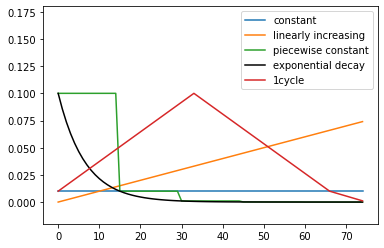

In [51]:
# create plots of learning rates for better understanding 
res_cons = np.zeros(max_epochs)
res_incr = np.zeros(max_epochs)
res_pw = np.zeros(max_epochs)
res_exp = np.zeros(max_epochs)
res_one = np.zeros(max_epochs)
for i in range(max_epochs):
    res_cons[i] = constant(i)
    res_incr[i] = increasing(i)
    res_pw[i] = pw_constant_d(i)
    res_exp[i] = exponential_d(i)
    res_one[i] = onecycle_d(i)
    #print(store[i])
#test = onecycle(range(max_epochs))
plt.plot(np.arange(0,max_epochs), res_cons, label='constant')
plt.plot(res_incr, label='linearly increasing')
plt.plot(res_pw, label='piecewise constant')
plt.plot(res_exp, 'k-', label='exponential decay')
plt.plot(res_one, label='1cycle')
plt.ylim((-0.02,0.18))
plt.legend()
plt.show()

In [52]:
# create dictionary to collect information and results
lr_dict = {
    'constant':{'lr_scheduler_d': lr_constant_d, 'lr_scheduler_m': lr_constant_m, 'results_d': None, 'results_m': None},
    'increasing':{'lr_scheduler_d': lr_increasing_d, 'lr_scheduler_m': lr_increasing_m, 'results_d': None, 'results_m': None},
    'pw_constant':{'lr_scheduler_d': lr_pwconstant_d, 'lr_scheduler_m': lr_pwconstant_m, 'results_d': None, 'results_m': None},
    'exponential':{'lr_scheduler_d': lr_exponential_d, 'lr_scheduler_m': lr_exponential_m, 'results_d': None, 'results_m': None},
    '1cycle':{'lr_scheduler_d': lr_onecycle_d, 'lr_scheduler_m': lr_onecycle_m, 'results_d': None, 'results_m': None}
}

In [53]:
# increase patience for early stopping to have proper results  
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=50, min_delta=1e-7, restore_best_weights=True)

In [54]:
for key in lr_dict.keys():
    lr_scheduler_d = lr_dict[key]['lr_scheduler_d']
    lr_scheduler_m = lr_dict[key]['lr_scheduler_m']
    
    #daily data
    mses_train_d, mses_test_d, times_d = [], [], []
    for i in range(runs_to_avg):
        model = FFNN()
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='daily', lr_scheduler=lr_scheduler_d)
        times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    lr_dict[key]['results_d'] = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]
     

    # minutely data
    mses_train_m, mses_test_m, times_m = [], [], []
    for i in range(runs_to_avg):
        model = FFNN()
        model.summary()
        time2, mse_train, mse_test = quick_proc(model, data='minutely', lr_scheduler=lr_scheduler_m)
        times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    lr_dict[key]['results_m'] = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]

Model: "sequential_642"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2224 (Dense)          (None, 30)                1530      
                                                                 
 dense_2225 (Dense)          (None, 15)                465       
                                                                 
 dense_2226 (Dense)          (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
19/19 [==============================] - 1s 2ms/step - loss: 0.0815 - mean_squared_error: 0.0815 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - lr: 0.0100
Epoch 3/75
19/19 [==============================] - 0s 2ms/step - loss: 

Epoch 1/75
19/19 [==============================] - 1s 1ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0100
Epoch 3/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 4/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 5/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 6/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 7/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 8/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 9/75
19/19 [==============

19/19 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 11/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 12/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 13/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 14/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 15/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 16/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 17/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 18/75
19/19 [=================

19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 18/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 19/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 20/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 21/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 22/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0100
Epoch 23/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0100
Epoch 24/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0100
Epoch 25/75
19/19 [=================

19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 24/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 25/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 26/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 27/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 28/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 29/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 30/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 31/75
19/19 [=================

19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 25/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 26/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 27/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 28/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 29/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 30/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 31/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0100
Epoch 32/75
19/19 [=================

Epoch 27/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8744e-04 - mean_squared_error: 7.8744e-04 - lr: 0.0100
Epoch 28/50
216/216 [==============================] - 0s 1ms/step - loss: 7.8545e-04 - mean_squared_error: 7.8545e-04 - lr: 0.0100
Epoch 29/50
216/216 [==============================] - 0s 1ms/step - loss: 7.8667e-04 - mean_squared_error: 7.8667e-04 - lr: 0.0100
Epoch 30/50
216/216 [==============================] - 0s 1ms/step - loss: 7.8308e-04 - mean_squared_error: 7.8308e-04 - lr: 0.0100
Epoch 31/50
216/216 [==============================] - 0s 1ms/step - loss: 7.8666e-04 - mean_squared_error: 7.8666e-04 - lr: 0.0100
Epoch 32/50
216/216 [==============================] - 0s 1ms/step - loss: 7.7665e-04 - mean_squared_error: 7.7665e-04 - lr: 0.0100
Epoch 33/50
216/216 [==============================] - 0s 1ms/step - loss: 7.8731e-04 - mean_squared_error: 7.8731e-04 - lr: 0.0100
Epoch 34/50
216/216 [==============================] - 0s 1ms/step - loss: 7

216/216 [==============================] - 0s 1ms/step - loss: 7.7762e-04 - mean_squared_error: 7.7762e-04 - lr: 0.0100
Epoch 37/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7802e-04 - mean_squared_error: 7.7802e-04 - lr: 0.0100
Epoch 38/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7820e-04 - mean_squared_error: 7.7820e-04 - lr: 0.0100
Epoch 39/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7813e-04 - mean_squared_error: 7.7813e-04 - lr: 0.0100
Epoch 40/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7761e-04 - mean_squared_error: 7.7761e-04 - lr: 0.0100
Epoch 41/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7729e-04 - mean_squared_error: 7.7729e-04 - lr: 0.0100
Epoch 42/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7680e-04 - mean_squared_error: 7.7680e-04 - lr: 0.0100
Epoch 43/50
216/216 [==============================] - 0s 1ms/step - loss: 7.6806e-04 - 

216/216 [==============================] - 0s 2ms/step - loss: 7.7486e-04 - mean_squared_error: 7.7486e-04 - lr: 0.0100
Epoch 46/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7517e-04 - mean_squared_error: 7.7517e-04 - lr: 0.0100
Epoch 47/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8453e-04 - mean_squared_error: 7.8453e-04 - lr: 0.0100
Epoch 48/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8792e-04 - mean_squared_error: 7.8792e-04 - lr: 0.0100
Epoch 49/50
216/216 [==============================] - 0s 2ms/step - loss: 8.0055e-04 - mean_squared_error: 8.0055e-04 - lr: 0.0100
Epoch 50/50
215/215 [==============================] - 0s 918us/step
Model: "sequential_658"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2272 (Dense)          (None, 30)                1530      
                                                             

Epoch 1/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - lr: 0.0100
Epoch 2/50
216/216 [==============================] - 0s 2ms/step - loss: 7.3844e-04 - mean_squared_error: 7.3844e-04 - lr: 0.0100
Epoch 3/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4292e-04 - mean_squared_error: 7.4292e-04 - lr: 0.0100
Epoch 4/50
216/216 [==============================] - 1s 2ms/step - loss: 7.4474e-04 - mean_squared_error: 7.4474e-04 - lr: 0.0100
Epoch 5/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4482e-04 - mean_squared_error: 7.4482e-04 - lr: 0.0100
Epoch 6/50
216/216 [==============================] - 0s 2ms/step - loss: 7.5542e-04 - mean_squared_error: 7.5542e-04 - lr: 0.0100
Epoch 7/50
216/216 [==============================] - 0s 2ms/step - loss: 7.6374e-04 - mean_squared_error: 7.6374e-04 - lr: 0.0100
Epoch 8/50
216/216 [==============================] - 0s 2ms/step - loss: 7.6398e-04 - mean

19/19 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0090
Epoch 11/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0100
Epoch 12/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0110
Epoch 13/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0120
Epoch 14/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0130
Epoch 15/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0140
Epoch 16/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0150
Epoch 17/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0160
Epoch 18/75
19/19 [=================

19/19 [==============================] - 0s 1ms/step - loss: 0.3600 - mean_squared_error: 0.3600 - lr: 0.0000e+00
Epoch 2/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - lr: 0.0010
Epoch 3/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0516 - mean_squared_error: 0.0516 - lr: 0.0020
Epoch 4/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - lr: 0.0030
Epoch 5/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - lr: 0.0040
Epoch 6/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0050
Epoch 7/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0060
Epoch 8/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0070
Epoch 9/75
19/19 [=====================

Epoch 68/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0670
Epoch 69/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0680
Epoch 70/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0690
Epoch 71/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0700
Epoch 72/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0710
Epoch 73/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0720
Epoch 74/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0730
Epoch 75/75
8/8 [==============================] - 0s 1ms/step
Model: "sequential_664"
___________________________________________________________

19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0340
Epoch 36/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0350
Epoch 37/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0360
Epoch 38/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0370
Epoch 39/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0380
Epoch 40/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0390
Epoch 41/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0400
Epoch 42/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0410
Epoch 43/75
19/19 [=================

19/19 [==============================] - 0s 2ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - lr: 0.0020
Epoch 4/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - lr: 0.0030
Epoch 5/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - lr: 0.0040
Epoch 6/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0050
Epoch 7/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0060
Epoch 8/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0070
Epoch 9/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0080
Epoch 10/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0090
Epoch 11/75
19/19 [=======================

19/19 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.0530
Epoch 55/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0540
Epoch 56/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0550
Epoch 57/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0560
Epoch 58/75
19/19 [==============================] - 0s 1ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0570
Epoch 00058: early stopping
8/8 [==============================] - 0s 1ms/step
Model: "sequential_669"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2305 (Dense)          (None, 30)                1530      
                                                                 
 dense_2306 (Dense)          (None,

19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0340
Epoch 36/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0350
Epoch 37/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0360
Epoch 38/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0370
Epoch 39/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0380
Epoch 40/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0390
Epoch 41/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0400
Epoch 42/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0410
Epoch 43/75
19/19 [=================

216/216 [==============================] - 1s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0020
Epoch 4/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - lr: 0.0030
Epoch 5/50
216/216 [==============================] - 0s 2ms/step - loss: 9.0655e-04 - mean_squared_error: 9.0655e-04 - lr: 0.0040
Epoch 6/50
216/216 [==============================] - 0s 2ms/step - loss: 8.3606e-04 - mean_squared_error: 8.3606e-04 - lr: 0.0050
Epoch 7/50
216/216 [==============================] - 0s 2ms/step - loss: 8.0049e-04 - mean_squared_error: 8.0049e-04 - lr: 0.0060
Epoch 8/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8683e-04 - mean_squared_error: 7.8683e-04 - lr: 0.0070
Epoch 9/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7294e-04 - mean_squared_error: 7.7294e-04 - lr: 0.0080
Epoch 10/50
216/216 [==============================] - 0s 1ms/step - loss: 7.7417e-04 - mean_squared_error: 7.

216/216 [==============================] - 0s 2ms/step - loss: 8.2500e-04 - mean_squared_error: 8.2500e-04 - lr: 0.0120
Epoch 14/50
216/216 [==============================] - 0s 1ms/step - loss: 8.3166e-04 - mean_squared_error: 8.3166e-04 - lr: 0.0130
Epoch 15/50
216/216 [==============================] - 0s 1ms/step - loss: 8.3183e-04 - mean_squared_error: 8.3183e-04 - lr: 0.0140
Epoch 16/50
216/216 [==============================] - 0s 1ms/step - loss: 8.3305e-04 - mean_squared_error: 8.3305e-04 - lr: 0.0150
Epoch 17/50
216/216 [==============================] - 0s 2ms/step - loss: 8.3548e-04 - mean_squared_error: 8.3548e-04 - lr: 0.0160
Epoch 18/50
216/216 [==============================] - 0s 2ms/step - loss: 8.3954e-04 - mean_squared_error: 8.3954e-04 - lr: 0.0170
Epoch 19/50
216/216 [==============================] - 0s 1ms/step - loss: 8.4130e-04 - mean_squared_error: 8.4130e-04 - lr: 0.0180
Epoch 20/50
216/216 [==============================] - 0s 1ms/step - loss: 8.4303e-04 - 

216/216 [==============================] - 1s 2ms/step - loss: 7.9654e-04 - mean_squared_error: 7.9654e-04 - lr: 0.0230
Epoch 25/50
216/216 [==============================] - 1s 2ms/step - loss: 8.0475e-04 - mean_squared_error: 8.0475e-04 - lr: 0.0240
Epoch 26/50
216/216 [==============================] - 1s 2ms/step - loss: 8.1577e-04 - mean_squared_error: 8.1577e-04 - lr: 0.0250
Epoch 27/50
216/216 [==============================] - 1s 2ms/step - loss: 8.2657e-04 - mean_squared_error: 8.2657e-04 - lr: 0.0260
Epoch 28/50
216/216 [==============================] - 1s 2ms/step - loss: 8.2958e-04 - mean_squared_error: 8.2958e-04 - lr: 0.0270
Epoch 29/50
216/216 [==============================] - 1s 2ms/step - loss: 8.3088e-04 - mean_squared_error: 8.3088e-04 - lr: 0.0280
Epoch 30/50
216/216 [==============================] - 1s 2ms/step - loss: 8.3707e-04 - mean_squared_error: 8.3707e-04 - lr: 0.0290
Epoch 31/50
216/216 [==============================] - 1s 2ms/step - loss: 8.4613e-04 - 

216/216 [==============================] - 1s 2ms/step - loss: 8.6723e-04 - mean_squared_error: 8.6723e-04 - lr: 0.0330
Epoch 35/50
216/216 [==============================] - 1s 2ms/step - loss: 8.9902e-04 - mean_squared_error: 8.9902e-04 - lr: 0.0340
Epoch 36/50
216/216 [==============================] - 1s 2ms/step - loss: 8.7831e-04 - mean_squared_error: 8.7831e-04 - lr: 0.0350
Epoch 37/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - lr: 0.0360
Epoch 38/50
216/216 [==============================] - 1s 2ms/step - loss: 8.6220e-04 - mean_squared_error: 8.6220e-04 - lr: 0.03700.0010 - mean_squar
Epoch 39/50
216/216 [==============================] - 1s 2ms/step - loss: 9.1704e-04 - mean_squared_error: 9.1704e-04 - lr: 0.0380
Epoch 40/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.0390
Epoch 41/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0012 - m

Epoch 39/50
216/216 [==============================] - 1s 2ms/step - loss: 8.6409e-04 - mean_squared_error: 8.6409e-04 - lr: 0.0380
Epoch 40/50
216/216 [==============================] - 0s 2ms/step - loss: 8.7975e-04 - mean_squared_error: 8.7975e-04 - lr: 0.0390
Epoch 41/50
216/216 [==============================] - 1s 2ms/step - loss: 8.8038e-04 - mean_squared_error: 8.8038e-04 - lr: 0.0400
Epoch 42/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3291 - mean_squared_error: 0.3291 - lr: 0.0410
Epoch 43/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0420
Epoch 44/50
216/216 [==============================] - 1s 3ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0430
Epoch 45/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0440
Epoch 46/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3758 - mean_squared_error: 0.37

Epoch 45/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0440
Epoch 46/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0450
Epoch 47/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0460
Epoch 48/50
216/216 [==============================] - 1s 3ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0470
Epoch 49/50
216/216 [==============================] - 1s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0480
Epoch 50/50
215/215 [==============================] - 0s 2ms/step
Model: "sequential_681"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2341 (Dense)          (None, 30)                1530      
                                                                 
 dense_2342 (Dense)      

19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-04
Epoch 58/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-04
Epoch 59/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-04
Epoch 60/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-04
Epoch 61/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-05
Epoch 62/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-05
Epoch 63/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-05
Epoch 64/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-05
Epoc

19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 25/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 26/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 27/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 28/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 29/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 30/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0100
Epoch 31/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0010
Epoch 32/75
19/19 [=================

Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
19/19 [==============================] - 1s 3ms/step - loss: 0.0553 - mean_squared_error: 0.0553 - lr: 0.1000
Epoch 2/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - lr: 0.1000
Epoch 3/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - lr: 0.1000
Epoch 4/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - lr: 0.1000
Epoch 5/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - lr: 0.1000
Epoch 6/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - lr: 0.1000
Epoch 7/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - lr: 0.1000
Epoch 8/75
19/19 [=====================

19/19 [==============================] - 0s 3ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 1.0000e-04
Epoch 51/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 1.0000e-04
Epoch 52/75
19/19 [==============================] - 0s 3ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 1.0000e-04
Epoch 00052: early stopping
8/8 [==============================] - 0s 2ms/step
Model: "sequential_688"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2362 (Dense)          (None, 30)                1530      
                                                                 
 dense_2363 (Dense)          (None, 15)                465       
                                                                 
 dense_2364 (Dense)          (None, 1)                 16        
                                                                 
Tot

19/19 [==============================] - 1s 2ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - lr: 0.1000
Epoch 2/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1089 - mean_squared_error: 0.1089 - lr: 0.1000
Epoch 3/75
19/19 [==============================] - 0s 3ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.1000
Epoch 4/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.1000
Epoch 5/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.1000
Epoch 6/75
19/19 [==============================] - 0s 3ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.1000
Epoch 7/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.1000
Epoch 8/75
19/19 [==============================] - 0s 3ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.1000
Epoch 9/75
19/19 [=========================

Epoch 72/75
19/19 [==============================] - 0s 3ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 1.0000e-05
Epoch 73/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 1.0000e-05
Epoch 74/75
19/19 [==============================] - 0s 3ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 1.0000e-05
Epoch 75/75
8/8 [==============================] - 0s 2ms/step
Model: "sequential_691"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2371 (Dense)          (None, 30)                1530      
                                                                 
 dense_2372 (Dense)          (None, 15)                465       
                                                                 
 dense_2373 (Dense)          (None, 1)                 16        
                                                                 
Total p

216/216 [==============================] - 1s 3ms/step - loss: 7.2584e-04 - mean_squared_error: 7.2584e-04 - lr: 1.0000e-04
Epoch 37/50
216/216 [==============================] - 1s 2ms/step - loss: 7.2591e-04 - mean_squared_error: 7.2591e-04 - lr: 1.0000e-04
Epoch 38/50
216/216 [==============================] - 1s 4ms/step - loss: 7.2597e-04 - mean_squared_error: 7.2597e-04 - lr: 1.0000e-04
Epoch 39/50
216/216 [==============================] - 1s 3ms/step - loss: 7.2601e-04 - mean_squared_error: 7.2601e-04 - lr: 1.0000e-04
Epoch 40/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2605e-04 - mean_squared_error: 7.2605e-04 - lr: 1.0000e-04
Epoch 41/50
216/216 [==============================] - 1s 2ms/step - loss: 7.2463e-04 - mean_squared_error: 7.2463e-04 - lr: 1.0000e-05
Epoch 42/50
216/216 [==============================] - 1s 2ms/step - loss: 7.2464e-04 - mean_squared_error: 7.2464e-04 - lr: 1.0000e-05
Epoch 43/50
216/216 [==============================] - 0s 2m

216/216 [==============================] - 0s 2ms/step - loss: 7.2465e-04 - mean_squared_error: 7.2465e-04 - lr: 1.0000e-05
Epoch 47/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2465e-04 - mean_squared_error: 7.2465e-04 - lr: 1.0000e-05
Epoch 48/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2465e-04 - mean_squared_error: 7.2465e-04 - lr: 1.0000e-05
Epoch 49/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2465e-04 - mean_squared_error: 7.2465e-04 - lr: 1.0000e-05
Epoch 50/50
215/215 [==============================] - 0s 1ms/step
Model: "sequential_695"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2383 (Dense)          (None, 30)                1530      
                                                                 
 dense_2384 (Dense)          (None, 15)                465       
                                               

 dense_2388 (Dense)          (None, 1)                 16        
                                                                 
Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0660 - mean_squared_error: 0.0660 - lr: 0.1000
Epoch 2/50
216/216 [==============================] - 0s 2ms/step - loss: 8.4930e-04 - mean_squared_error: 8.4930e-04 - lr: 0.1000
Epoch 3/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.1000
Epoch 4/50
216/216 [==============================] - 0s 2ms/step - loss: 0.2980 - mean_squared_error: 0.2980 - lr: 0.1000
Epoch 5/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - lr: 0.1000
Epoch 6/50
216/216 [==============================] - 0s 2ms/step - loss: 8.7716e-04 - mean_squared_error: 8.77

216/216 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.1000
Epoch 11/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4237e-04 - mean_squared_error: 7.4237e-04 - lr: 0.0100
Epoch 12/50
216/216 [==============================] - 0s 2ms/step - loss: 7.3195e-04 - mean_squared_error: 7.3195e-04 - lr: 0.0100
Epoch 13/50
216/216 [==============================] - 0s 2ms/step - loss: 7.3442e-04 - mean_squared_error: 7.3442e-04 - lr: 0.0100
Epoch 14/50
216/216 [==============================] - 0s 2ms/step - loss: 7.3759e-04 - mean_squared_error: 7.3759e-04 - lr: 0.0100
Epoch 15/50
216/216 [==============================] - 0s 2ms/step - loss: 7.3972e-04 - mean_squared_error: 7.3972e-04 - lr: 0.0100
Epoch 16/50
216/216 [==============================] - 1s 3ms/step - loss: 7.4257e-04 - mean_squared_error: 7.4257e-04 - lr: 0.0100
Epoch 17/50
216/216 [==============================] - 1s 3ms/step - loss: 7.4631e-04 - mean_squ

216/216 [==============================] - 0s 2ms/step - loss: 7.3977e-04 - mean_squared_error: 7.3977e-04 - lr: 0.0100
Epoch 16/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4265e-04 - mean_squared_error: 7.4265e-04 - lr: 0.0100
Epoch 17/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4634e-04 - mean_squared_error: 7.4634e-04 - lr: 0.0100
Epoch 18/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4659e-04 - mean_squared_error: 7.4659e-04 - lr: 0.0100
Epoch 19/50
216/216 [==============================] - 1s 2ms/step - loss: 7.4768e-04 - mean_squared_error: 7.4768e-04 - lr: 0.0100
Epoch 20/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4864e-04 - mean_squared_error: 7.4864e-04 - lr: 0.0100
Epoch 21/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2635e-04 - mean_squared_error: 7.2635e-04 - lr: 0.0010
Epoch 22/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2633e-04 - 

216/216 [==============================] - 0s 2ms/step - loss: 7.2755e-04 - mean_squared_error: 7.2755e-04 - lr: 0.0010
Epoch 27/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2806e-04 - mean_squared_error: 7.2806e-04 - lr: 0.0010
Epoch 28/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2853e-04 - mean_squared_error: 7.2853e-04 - lr: 0.0010
Epoch 29/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2891e-04 - mean_squared_error: 7.2891e-04 - lr: 0.0010
Epoch 30/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2912e-04 - mean_squared_error: 7.2912e-04 - lr: 0.0010
Epoch 31/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2531e-04 - mean_squared_error: 7.2531e-04 - lr: 1.0000e-04
Epoch 32/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2542e-04 - mean_squared_error: 7.2542e-04 - lr: 1.0000e-04
Epoch 33/50
216/216 [==============================] - 0s 2ms/step - loss: 7.255

Epoch 33/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 7.3564e-04
Epoch 34/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 6.3096e-04
Epoch 35/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 5.4117e-04
Epoch 36/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 4.6416e-04
Epoch 37/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 3.9811e-04
Epoch 38/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 3.4145e-04
Epoch 39/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 2.9286e-04
Epoch 40/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 2.5

19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0046
Epoch 22/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0040
Epoch 23/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0034
Epoch 24/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0029
Epoch 25/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0025
Epoch 26/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0022
Epoch 27/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0018
Epoch 28/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0016
Epoch 29/75
19/19 [=================

19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 3.4145e-06
Epoch 69/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 2.9286e-06
Epoch 70/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 2.5119e-06
Epoch 71/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 2.1544e-06
Epoch 72/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.8478e-06
Epoch 73/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.5849e-06
Epoch 74/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.3594e-06
Epoch 75/75
8/8 [==============================] - 0s 2ms/step
Model: "sequential_706"
___________________________________________

Epoch 52/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 3.9811e-05
Epoch 53/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 3.4145e-05
Epoch 54/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 2.9286e-05
Epoch 55/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 2.5119e-05
Epoch 56/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 2.1544e-05
Epoch 57/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.8478e-05
Epoch 58/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.5849e-05
Epoch 59/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.3

19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 2.1544e-04
Epoch 42/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.8478e-04
Epoch 43/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.5849e-04
Epoch 44/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.3594e-04
Epoch 45/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.1659e-04
Epoch 46/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 1.0000e-04
Epoch 47/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 8.5770e-05
Epoch 48/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 7.3564e-05
Epoc

19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0398
Epoch 8/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0341
Epoch 9/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0293
Epoch 10/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0251
Epoch 11/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0215
Epoch 12/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0185
Epoch 13/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0158
Epoch 14/75
19/19 [==============================] - 0s 2ms/step - loss: 0.1090 - mean_squared_error: 0.1090 - lr: 0.0136
Epoch 15/75
19/19 [===================

Total params: 2,011
Trainable params: 2,011
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
216/216 [==============================] - 1s 2ms/step - loss: 0.2614 - mean_squared_error: 0.2614 - lr: 0.1000
Epoch 2/50
216/216 [==============================] - 0s 2ms/step - loss: 7.9293e-04 - mean_squared_error: 7.9293e-04 - lr: 0.0794
Epoch 3/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8277e-04 - mean_squared_error: 7.8277e-04 - lr: 0.0631
Epoch 4/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8361e-04 - mean_squared_error: 7.8361e-04 - lr: 0.0501
Epoch 5/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7800e-04 - mean_squared_error: 7.7800e-04 - lr: 0.0398
Epoch 6/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7488e-04 - mean_squared_error: 7.7488e-04 - lr: 0.0316
Epoch 7/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7150e-04 - m

Epoch 7/50
216/216 [==============================] - 0s 2ms/step - loss: 8.0055e-04 - mean_squared_error: 8.0055e-04 - lr: 0.0251
Epoch 8/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8863e-04 - mean_squared_error: 7.8863e-04 - lr: 0.0200
Epoch 9/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7442e-04 - mean_squared_error: 7.7442e-04 - lr: 0.0158
Epoch 10/50
216/216 [==============================] - 0s 2ms/step - loss: 7.7095e-04 - mean_squared_error: 7.7095e-04 - lr: 0.0126
Epoch 11/50
216/216 [==============================] - 0s 2ms/step - loss: 7.6537e-04 - mean_squared_error: 7.6537e-04 - lr: 0.0100
Epoch 12/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4916e-04 - mean_squared_error: 7.4916e-04 - lr: 0.0079
Epoch 13/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4397e-04 - mean_squared_error: 7.4397e-04 - lr: 0.0063
Epoch 14/50
216/216 [==============================] - 0s 2ms/step - loss: 7.44

216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0040
Epoch 16/50
216/216 [==============================] - 1s 3ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0032
Epoch 17/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0025
Epoch 18/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0020
Epoch 19/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0016
Epoch 20/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0013
Epoch 21/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0010
Epoch 22/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 7.9433e-04
Epoch 23/50
216/

216/216 [==============================] - 0s 2ms/step - loss: 7.2663e-04 - mean_squared_error: 7.2663e-04 - lr: 3.9811e-04
Epoch 26/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2638e-04 - mean_squared_error: 7.2638e-04 - lr: 3.1623e-04
Epoch 27/50
216/216 [==============================] - 1s 2ms/step - loss: 7.2616e-04 - mean_squared_error: 7.2616e-04 - lr: 2.5119e-04
Epoch 28/50
216/216 [==============================] - 1s 2ms/step - loss: 7.2610e-04 - mean_squared_error: 7.2610e-04 - lr: 1.9953e-04
Epoch 29/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2616e-04 - mean_squared_error: 7.2616e-04 - lr: 1.5849e-04
Epoch 30/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2611e-04 - mean_squared_error: 7.2611e-04 - lr: 1.2589e-04
Epoch 31/50
216/216 [==============================] - 1s 2ms/step - loss: 7.2590e-04 - mean_squared_error: 7.2590e-04 - lr: 1.0000e-04
Epoch 32/50
216/216 [==============================] - 0s 2m

216/216 [==============================] - 0s 2ms/step - loss: 7.2555e-04 - mean_squared_error: 7.2555e-04 - lr: 6.3096e-05
Epoch 34/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2531e-04 - mean_squared_error: 7.2531e-04 - lr: 5.0119e-05
Epoch 35/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2511e-04 - mean_squared_error: 7.2511e-04 - lr: 3.9811e-05
Epoch 36/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2496e-04 - mean_squared_error: 7.2496e-04 - lr: 3.1623e-05
Epoch 37/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2485e-04 - mean_squared_error: 7.2485e-04 - lr: 2.5119e-05
Epoch 38/50
216/216 [==============================] - 0s 2ms/step - loss: 7.2477e-04 - mean_squared_error: 7.2477e-04 - lr: 1.9953e-05
Epoch 39/50
216/216 [==============================] - 1s 3ms/step - loss: 7.2472e-04 - mean_squared_error: 7.2472e-04 - lr: 1.5849e-05
Epoch 40/50
216/216 [==============================] - 1s 2m

Epoch 48/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - lr: 0.0618
Epoch 49/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0591
Epoch 50/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0564
Epoch 51/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0536
Epoch 52/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0509
Epoch 53/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0482
Epoch 54/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0455
Epoch 55/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0427
Epoch 00055: early stopp

19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0455
Epoch 55/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0427
Epoch 56/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0400
Epoch 57/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0373
Epoch 58/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0345
Epoch 59/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0318
Epoch 60/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0291
Epoch 00060: early stopping
8/8 [==============================] - 0s 1ms/step
Model: "sequential_725"
_______________________________________________________

19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0427
Epoch 56/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0400
Epoch 57/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0373
Epoch 58/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0345
Epoch 59/75
19/19 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0318
Epoch 00059: early stopping
8/8 [==============================] - 0s 2ms/step
Model: "sequential_727"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2479 (Dense)          (None, 30)                1530      
                                                                 
 dense_2480 (Dense)          (None,

19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0427
Epoch 56/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0400
Epoch 57/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0373
Epoch 58/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0345
Epoch 59/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0318
Epoch 60/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.0291
Epoch 61/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0264
Epoch 62/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0236
Epoch 63/75
19/19 [=================

19/19 [==============================] - 0s 2ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - lr: 0.0755
Epoch 44/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0727
Epoch 45/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0700
Epoch 46/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0673
Epoch 47/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0645
Epoch 48/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0618
Epoch 49/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0591
Epoch 50/75
19/19 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - lr: 0.0564
Epoch 51/75
19/19 [=================

216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0795
Epoch 29/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0755
Epoch 30/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0714
Epoch 31/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0673
Epoch 32/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0632
Epoch 33/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0591
Epoch 34/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0550
Epoch 35/50
216/216 [==============================] - 0s 2ms/step - loss: 0.3758 - mean_squared_error: 0.3758 - lr: 0.0509
Epoch 36/50
216/216 

216/216 [==============================] - 0s 2ms/step - loss: 8.1452e-04 - mean_squared_error: 8.1452e-04 - lr: 0.0223
Epoch 43/50
216/216 [==============================] - 1s 2ms/step - loss: 8.0861e-04 - mean_squared_error: 8.0861e-04 - lr: 0.0182
Epoch 44/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8488e-04 - mean_squared_error: 7.8488e-04 - lr: 0.0141
Epoch 45/50
216/216 [==============================] - 1s 3ms/step - loss: 7.7453e-04 - mean_squared_error: 7.7453e-04 - lr: 0.0100
Epoch 46/50
216/216 [==============================] - 0s 2ms/step - loss: 7.5916e-04 - mean_squared_error: 7.5916e-04 - lr: 0.0083
Epoch 47/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4823e-04 - mean_squared_error: 7.4823e-04 - lr: 0.0067
Epoch 48/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4271e-04 - mean_squared_error: 7.4271e-04 - lr: 0.0050
Epoch 49/50
216/216 [==============================] - 0s 2ms/step - loss: 7.4291e-04 - 

Epoch 1/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0249 - mean_squared_error: 0.0249 - lr: 0.0100
Epoch 2/50
216/216 [==============================] - 0s 2ms/step - loss: 7.5205e-04 - mean_squared_error: 7.5205e-04 - lr: 0.0141
Epoch 3/50
216/216 [==============================] - 0s 2ms/step - loss: 7.8489e-04 - mean_squared_error: 7.8489e-04 - lr: 0.0182
Epoch 4/50
216/216 [==============================] - 0s 2ms/step - loss: 8.1411e-04 - mean_squared_error: 8.1411e-04 - lr: 0.0223
Epoch 5/50
216/216 [==============================] - 0s 2ms/step - loss: 8.5744e-04 - mean_squared_error: 8.5744e-04 - lr: 0.0264
Epoch 6/50
216/216 [==============================] - 0s 2ms/step - loss: 9.0705e-04 - mean_squared_error: 9.0705e-04 - lr: 0.0305
Epoch 7/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.0345
Epoch 8/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_err

Epoch 9/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0427
Epoch 10/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0468
Epoch 11/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0209 - mean_squared_error: 0.0209 - lr: 0.0509
Epoch 12/50
216/216 [==============================] - 0s 2ms/step - loss: 8.1880e-04 - mean_squared_error: 8.1880e-04 - lr: 0.0550
Epoch 13/50
216/216 [==============================] - 0s 2ms/step - loss: 8.5459e-04 - mean_squared_error: 8.5459e-04 - lr: 0.0591
Epoch 14/50
216/216 [==============================] - 0s 2ms/step - loss: 9.0655e-04 - mean_squared_error: 9.0655e-04 - lr: 0.0632
Epoch 15/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - lr: 0.0673loss: 0.0034 - mean_squar
Epoch 16/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0032 - 

216/216 [==============================] - 0s 2ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - lr: 0.0959
Epoch 23/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - lr: 0.1000
Epoch 24/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - lr: 0.0959
Epoch 25/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - lr: 0.0918
Epoch 26/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - lr: 0.0877
Epoch 27/50
216/216 [==============================] - 1s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - lr: 0.0836
Epoch 28/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.0795
Epoch 29/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - lr: 0.0755
Epoch 30/50
216/216 

216/216 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0755
Epoch 30/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - lr: 0.0714
Epoch 31/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0673
Epoch 32/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - lr: 0.0632
Epoch 33/50
216/216 [==============================] - 1s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.0591
Epoch 34/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.0550
Epoch 35/50
216/216 [==============================] - 0s 2ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - lr: 0.0509
Epoch 36/50
216/216 [==============================] - 0s 2ms/step - loss: 9.7765e-04 - mean_squared_error: 9.7765e-04 - lr: 0.0468
Epoch 37/50


In [55]:
labels = {0:'default', 1:'constant', 2:'linearily increasing', 3:'piecewise constant', 4:'exponential', 5:'1cycle'} #default should be 0.001
table_comp_dict(lr_dict, labels)


The results for the daily data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
default                 1.730e-03   1.774e-03          8.53
constant                1.692e-03   1.692e-03          2.43
linearily increasing    1.716e-03   1.726e-03          3.72
piecewise constant      2.676e-02   2.703e-02          4.84
exponential             1.672e-02   1.688e-02          3.67
1cycle                  1.686e-03   1.683e-03          3.27


The results for the minutely data are summarized in the following table:


MSE Training MSE Testing  Fitting Time
default                 7.568e-07   3.214e-07         48.39
constant                7.670e-07   3.303e-07         19.49
linearily increasing    2.341e-04   2.337e-04         24.54
piecewise constant      1.563e-04   1.559e-04         23.23
exponential             7.854e-05   7.811e-05         23.04
1cycle                  1.563e-04   1.559e-04         22.94

# Resampling

The idea of resampling is to list the data with regard to fixed steps of traded units instead of fixed time periods. Here, applying resampling to a data set as small as the one for daily returns is not very promissing and will thus be left out. 

In [87]:
# get original data and volume 
original_df = data_dict['minutely']['df']
volume = data_dict['minutely']['df']['Volume']

In [88]:
# resample data for every point of time, if more than ref_vol of units have been traded 
class_re = 1
ref_vol = 50000000
sum_vol = 0
marker = np.zeros(len(volume)).astype(int)
df_resampled = original_df[:1][['Close']]
df_resampled['Log Return'] = 0
for i in range(0,len(volume)):
    marker[i] = class_re
    sum_vol += volume[i]
    if sum_vol > ref_vol:
        df2 = original_df[i:i+1][['Close']]
        df_resampled = pd.concat([df_resampled, df2], ignore_index=True)
        df_resampled['Log Return'][class_re] = np.log(df_resampled['Close'][class_re] / df_resampled['Close'][class_re-1])
        class_re += 1 
        sum_vol = 0


In [89]:
df_resampled

Close  Log Return
0     50371.167969    0.000000
1     50432.070312    0.001208
2     50513.035156    0.001604
3     50580.226562    0.001329
4     50658.085938    0.001538
...            ...         ...
3745  46125.781250   -0.003116
3746  46155.605469    0.000646
3747  46177.183594    0.000467
3748  46232.519531    0.001198
3749  46172.019531   -0.001309

[3750 rows x 2 columns]

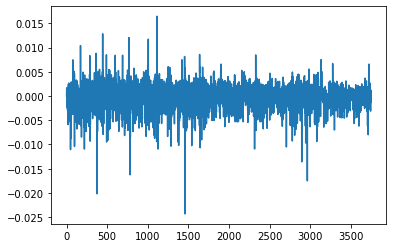

In [90]:
# repeat usual procedure from above
# first scale data 
scaler_res = MinMaxScaler()
data = np.array(df_resampled['Log Return'].values)
data = data.reshape(-1,1)
scaled_resample = scaler_res.fit_transform(data)

# store normalized and resampled data 
df_resampled['Normalized'] = scaled_resample

# plot 
plt.plot(df_resampled['Log Return'])
plt.show()

In [91]:
# create training and test sets 
data = df_resampled['Normalized']
x_train_res, y_train_res, x_test_res, y_test_res = data_split(data, n_steps=n_steps, n_steps_ahead=n_steps_ahead)

In [92]:
# unscale
y_train_inv = scaler_res.inverse_transform(y_train_res.reshape(-1,1))
y_test_inv = scaler_res.inverse_transform(y_test_res.reshape(-1,1))

# fit several models and save results and time 
mses_train_m, mses_test_m, times_m = [], [], []
for i in range(runs_to_avg):
    model = FFNN()
    start_time = time.time()
    model.fit(x_train_res, y_train_res, epochs=max_epochs, 
                    batch_size=batch_size, callbacks=[es], shuffle=False)
    end_time = time.time()
    times_m.append(end_time-start_time)
    
    # predictions
    y_pred_train = model.predict(x_train_res, verbose=1)
    y_pred_train_inv = scaler_res.inverse_transform(y_pred_train)

    y_pred_test = model.predict(x_test_res, verbose=1)
    y_pred_test_inv = scaler_res.inverse_transform(y_pred_test)
    
    # MSE error 
    mse_train = mean_squared_error(y_train_inv, y_pred_train_inv)
    mse_test = mean_squared_error(y_test_inv, y_pred_test_inv)
    
    mses_train_m.append(mse_train), mses_test_m.append(mse_test)

# average performance given by mean 
time1, mse_train_res, mse_test_res = np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)

Epoch 1/75
47/47 [==============================] - 1s 2ms/step - loss: 0.0100 - mean_squared_error: 0.0100
Epoch 2/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 3/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 4/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 5/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 6/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 7/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 8/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 9/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044
Epoch 10/75
47/47 [=========

47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 75/75
22/22 [==============================] - 0s 900us/step
Epoch 1/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0441 - mean_squared_error: 0.0441
Epoch 2/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 3/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 4/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 6/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 7/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0050 

47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 73/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 75/75
22/22 [==============================] - 0s 750us/step
Epoch 1/75
47/47 [==============================] - 0s 1ms/step - loss: 0.2944 - mean_squared_error: 0.2944
Epoch 2/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 3/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 4/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 5/75
47/47 [==============================] - 0s 1ms/step - loss: 0.005

47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 69/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 70/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 71/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 73/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/75
47/47 [==============================] - 0s 2ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 75/75
22/22 [==============================] - 0s 748us/step
Epoch 1/75
47/47 [==============================] - 0s 1ms/step - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 2/75
47/47 [==============================] - 0s 1ms/step - loss: 0.

47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 67/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 68/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 69/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 70/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 71/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 73/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 74/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 75/75
22/22 [============

47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 65/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 66/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 67/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 68/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 69/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 70/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 71/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 72/75
47/47 [==============================] - 0s 1ms/step - loss: 0.0042 - mean_squared_error: 0.0042
Epoch 73/75
47/47 [============

In [93]:
# display results in table (only minutely)
labels = ['Standard Data', 'Resampled Data'] 
headers = ['MSE Training', 'MSE Testing', 'Fitting Time']
lst1 = ['{:.3e}'.format(mse_train_m), '{:.3e}'.format(mse_train_res)]
lst2 = ['{:.3e}'.format(mse_test_m), '{:.3e}'.format(mse_test_res)]
lst3 = [round(time_m,2), round(time1,2)]
df3 = pd.DataFrame(list(zip(lst1,lst2,lst3)),
               columns =headers, index=labels)
df3

MSE Training MSE Testing  Fitting Time
Standard Data     7.568e-07   3.214e-07         48.39
Resampled Data    7.008e-06   3.505e-06          5.88

To be able to compare the results, we will compute the ration between the MSE and the average return for both standard and resampled data. 

In [94]:
# determine average returns
avg_ret = np.mean(data_dict['minutely']['df']['Log Return'].values)
avg_ret_resam = np.mean(df_resampled['Log Return'].values)
#print(avg_ret, avg_ret_resam)

# compute error ratios
rat_train = abs(round(mse_train_m / avg_ret * 100, 2))
rat_train_resam = abs(round(mse_train_res / avg_ret_resam * 100, 2))
rat_test = abs(round(mse_test_m / avg_ret * 100, 2))
rat_test_resam = abs(round(mse_test_res / avg_ret_resam * 100, 2))

# print error rates 
print(f'The error rate for standard data in the training set is {rat_train}% compared to a rate of {rat_train_resam}% for resampled data.')
print(f'The error rate for standard data in the training set is {rat_test}% compared to a rate of {rat_test_resam}% for resampled data.')

The error rate for standard data in the training set is 29.81% compared to a rate of 30.19% for resampled data.
The error rate for standard data in the training set is 12.66% compared to a rate of 15.1% for resampled data.


# Cross-validation

Cross-validation uses all combination of chunks of the data set to determine the performance of a model. Note that cross-validation is not truely a tuning method including a hyperparameter which can be optimized to improve the training and prediction power of a neural network. However, cross-validation helps us to better evaluate the quality of the predictions for a given model which is why we present an implementation of this approach here. 

In [63]:
# merge training and test sets back together 
x_merged_d = np.concatenate((x_train_d,x_test_d))
y_merged_d = np.concatenate((y_train_d,y_test_d))
x_merged_m = np.concatenate((x_train_m,x_test_m))
y_merged_m = np.concatenate((y_train_m,y_test_m))

In [64]:
# initialize kfold 
kfold = KFold(n_splits=5, shuffle=False) # shuffle=False very important for time series data

In [65]:
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold_d = []
acc_per_fold_m = []
loss_per_fold_d = []
loss_per_fold_m = []

for train, test in kfold.split(x_merged_d, y_merged_d):
    # create standard FFNN model
    model_d = FFNN()
    model_m = FFNN()
    # fit model with fold 
    model_d.fit(x_merged_d[train], y_merged_d[train],
              batch_size=batch_size, callbacks =[es],
              epochs=max_epochs,
              verbose=1)
    model_m.fit(x_merged_m[train], y_merged_m[train],
              batch_size=batch_size_minutely, callbacks =[es],
              epochs=max_epochs_minutely,
              verbose=1)
    # determine generalization metrics
    scores_d = model_d.evaluate(x_merged_d[test], y_merged_d[test], verbose=0)
    scores_m = model_m.evaluate(x_merged_m[test], y_merged_m[test], verbose=0)
    print(f'Score for daily data and fold {fold_no}: {model_d.metrics_names[0]} of {scores_d[0]}; {model_d.metrics_names[1]} of {scores_d[1]*100}%')
    print(f'Score for daily data and fold {fold_no}: {model_m.metrics_names[0]} of {scores_m[0]}; {model_m.metrics_names[1]} of {scores_m[1]*100}%')
    acc_per_fold_d.append(scores_d[1] * 100)
    acc_per_fold_m.append(scores_m[1] * 100)
    loss_per_fold_d.append('{:.3e}'.format(scores_d[0]))
    loss_per_fold_m.append('{:.3e}'.format(scores_m[0]))


Epoch 1/75
18/18 [==============================] - 1s 5ms/step - loss: 0.0333 - mean_squared_error: 0.0333
Epoch 2/75
18/18 [==============================] - 0s 4ms/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 3/75
18/18 [==============================] - 0s 4ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 4/75
18/18 [==============================] - 0s 4ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 5/75
18/18 [==============================] - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 6/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 7/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 8/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 9/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 10/75
18/18 [=========

18/18 [==============================] - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 24/75
18/18 [==============================] - 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 25/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 26/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 27/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 28/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 29/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 30/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 31/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 32/75
18/18 [============

18/18 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 47/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 48/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 49/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 50/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 51/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 52/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 53/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 54/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 55/75
18/18 [============

18/18 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 66/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 67/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 68/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 69/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 70/75
18/18 [==============================] - 0s 3ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 71/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 72/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 73/75
18/18 [==============================] - 0s 2ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 74/75
18/18 [============

9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 13/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 14/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 15/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 16/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 17/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 18/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 19/50
9/9 [==============================] - 0s 4ms/step - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 20/50
9/9 [==============================] - 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 21/50
9/9 [========

In [66]:
# display results 
print('Score per fold')
for i in range(0, len(acc_per_fold_d)):
    print(f'> Fold {i+1} - Loss (daily): {loss_per_fold_d[i]} - Loss (minutely): {loss_per_fold_m[i]}')

Score per fold
> Fold 1 - Loss (daily): 4.447e-03 - Loss (minutely): 6.253e-04
> Fold 2 - Loss (daily): 3.373e-03 - Loss (minutely): 3.264e-04
> Fold 3 - Loss (daily): 3.800e-03 - Loss (minutely): 2.149e-03
> Fold 4 - Loss (daily): 2.361e-03 - Loss (minutely): 6.749e-04
> Fold 5 - Loss (daily): 3.706e-03 - Loss (minutely): 7.197e-04


# Autoencoder for Pre-Training

Autoencoders reduce the dimensionality of the input and can improve the training speed of the model if the input data is high dimensional. The atoencoder consists of an encoder - which is the left half - and the decoder - which is the right half of the network. Both are connected through a bottle neck in the middle. 

In [67]:
# fix size of input
input_shape_d = x_train_d.shape[-1]
input_shape_m = x_train_m.shape[-1]
input_df_d = Input(shape=(input_shape_d,))
input_df_m = Input(shape=(input_shape_m,))

# fix targeted size for data at bottleneck 
dim_encoding_d = int(input_shape_d * 0.25)
dim_encoding_m = int(input_shape_m * 0.25)

# initialize inner layers of encoder 
encoded_d = Dense(int(0.5 * input_shape_d), activation='relu', kernel_initializer='glorot_uniform')(input_df_d)
encoded_m = Dense(int(0.5 * input_shape_m), activation='relu', kernel_initializer='glorot_uniform')(input_df_m)

# bottleneck layer with targeted dimensionality 
encoded_d = Dense(dim_encoding_d, activation='relu', kernel_initializer='glorot_uniform')(encoded_d)
encoded_m = Dense(dim_encoding_m, activation='relu', kernel_initializer='glorot_uniform')(encoded_m)

# initialize inner layers of decoder 
decoded_d = Dense(int(0.5 * input_shape_d), activation='relu', kernel_initializer='glorot_uniform')(encoded_d)
decoded_m = Dense(int(0.5 * input_shape_m), activation='relu', kernel_initializer='glorot_uniform')(encoded_m)

# initialize output layer of the decoder/autoencoder 
decoded_d = Dense(input_shape_d, activation='relu', kernel_initializer='glorot_uniform')(decoded_d)
decoded_m = Dense(input_shape_m, activation='relu', kernel_initializer='glorot_uniform')(decoded_m)

# autoencoder is the model with all layers connected 
autoencoder_d = Model(input_df_d, decoded_d)
autoencoder_m = Model(input_df_m, decoded_m)

# encoder consists of left part of the network until bottleneck
encoder_d = Model(input_df_d, encoded_d)
encoder_m = Model(input_df_m, encoded_m)

# fix input shape of encoder 
encoded_input_d = Input(shape=(dim_encoding_d,))
encoded_input_m = Input(shape=(dim_encoding_m,))

# layers of the decoder model
decoder_layer_d = autoencoder_d.layers[-2]
decoder_layer2_d = autoencoder_d.layers[-1]
decoder_layer_m = autoencoder_m.layers[-2]
decoder_layer2_m = autoencoder_m.layers[-1]

# decoder model
decoder_d = Model(encoded_input_d, decoder_layer2_d(decoder_layer_d(encoded_input_d)))
decoder_m = Model(encoded_input_m, decoder_layer2_m(decoder_layer_m(encoded_input_m)))

# compile network with Adam and MSE
autoencoder_d.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_m.compile(optimizer='adam', loss='mean_squared_error')

In [68]:
# print summary 
autoencoder_d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense_2584 (Dense)          (None, 25)                1275      
                                                                 
 dense_2586 (Dense)          (None, 12)                312       
                                                                 
 dense_2588 (Dense)          (None, 25)                325       
                                                                 
 dense_2590 (Dense)          (None, 50)                1300      
                                                                 
Total params: 3,212
Trainable params: 3,212
Non-trainable params: 0
_________________________________________________________________


In [69]:
# fit autoencoders 
print('Fitting Autoencoder for daily data.')
autoencoder_d.fit(x_train_d, x_train_d, batch_size=64, epochs=15, verbose= 1)
print('\nFitting Autoencoder for minutely data.')
autoencoder_m.fit(x_train_m, x_train_m, batch_size=64, epochs=15, verbose= 1)

Fitting Autoencoder for daily data.
Epoch 1/15
19/19 [==============================] - 1s 3ms/step - loss: 0.2945
Epoch 2/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2276
Epoch 3/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2078
Epoch 4/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2047
Epoch 5/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2044
Epoch 6/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2043
Epoch 7/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2043
Epoch 8/15
19/19 [==============================] - 0s 4ms/step - loss: 0.2043
Epoch 9/15
19/19 [==============================] - 0s 4ms/step - loss: 0.2043
Epoch 10/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2043
Epoch 11/15
19/19 [==============================] - 0s 3ms/step - loss: 0.2043
Epoch 12/15
19/19 [==============================] - 0s 4ms/step - loss: 0.2043
Epoch 13/15
1

In [70]:
# compress data with encoders 
pred_d = encoder_d.predict(x_train_d)
pred_m = encoder_d.predict(x_train_m)
print('Initial data shape: ',x_train_d.shape, x_train_m.shape, '\nCompressed data size: ',pred_d.shape, pred_m.shape)

Initial data shape:  (1164, 50) (27636, 50) 
Compressed data size:  (1164, 12) (27636, 12)


In [71]:
# decode predictions 
pred_dec_d = decoder_d.predict(pred_d)
pred_dec_m = decoder_m.predict(pred_m)


In [72]:
# train new FFNN model with compressed data 
n_steps = dim_encoding_d

# initialize
model_withAE_d = FFNN()
model_withAE_m = FFNN()

# fit 
start_time_d = time.time()
model_withAE_d.fit(pred_d, y_train_d, batch_size=32, epochs=50, verbose=1)
end_time_d = time.time()
time_ae_d = end_time_d - start_time_d

start_time_m = time.time()
model_withAE_m.fit(pred_m, y_train_m, batch_size=64, epochs=50, verbose=1)
end_time_m = time.time()
time_ae_m = end_time_m - start_time_m

Epoch 1/50
37/37 [==============================] - 1s 2ms/step - loss: 0.1356 - mean_squared_error: 0.1356
Epoch 2/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 6/50
37/37 [==============================] - 0s 3ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 7/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 8/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/50
37/37 [==============================] - 0s 2ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 10/50
37/37 [=========

In [73]:
# make predictions, take scaling into account 
y_pred_train_d = model_withAE_d.predict(pred_d, verbose=1)
y_pred_train_m = model_withAE_m.predict(pred_m, verbose=1)
y_pred_train_inv_d = scaler_d.inverse_transform(y_pred_train_d)
y_pred_train_inv_m = scaler_m.inverse_transform(y_pred_train_m)

pred_test_d = encoder_d.predict(x_test_d)
pred_test_m = encoder_d.predict(x_test_m)
y_pred_test_d = model_withAE_d.predict(pred_test_d, verbose=1)
y_pred_test_m = model_withAE_m.predict(pred_test_m, verbose=1)
y_pred_test_inv_d = scaler_d.inverse_transform(y_pred_test_d)
y_pred_test_inv_m = scaler_m.inverse_transform(y_pred_test_m)

# MSE errors 
mse_train_ae_d = mean_squared_error(y_train_inv_d, y_pred_train_inv_d)
mse_train_ae_m = mean_squared_error(y_train_inv_m, y_pred_train_inv_m)
mse_test_ae_d = mean_squared_error(y_test_inv_d, y_pred_test_inv_d)
mse_test_ae_m = mean_squared_error(y_test_inv_m, y_pred_test_inv_m)
#print(mse_train, mse_test)

215/215 [==============================] - 0s 2ms/step


In [74]:
# store results in list and display in table 
results_ae_d = [time_ae_d, mse_train_ae_d, mse_test_ae_d]
results_ae_m = [time_ae_m, mse_train_ae_m, mse_test_ae_m]
labels = ['Without AE', 'With AE']
table_comp(labels, results_ae_d, results_ae_m)


The results for the daily data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without AE    1.730e-03   1.774e-03          8.53
With AE       1.671e-03   1.644e-03          5.65


The results for the minutely data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Without AE    7.568e-07   3.214e-07         48.39
With AE       8.105e-07   3.746e-07         49.37

## Conclusion: A model with all helpful methods 

Here, we want to compare the performance of a model which makes use of all helpful tuning methods according to what we have learned above for both daily and minutely data. It is not guaranteed that adding multiple of these methods at the same time improves the performance and it could also be possible that adding some of the other methods or methods with other hyperparameters show better generalization performance than the model we will create in the following.

Model for daily data: Dropout (0.2), Glorot Initialization, L1-Regularization (0.01), Sigmoid Activation Function, Nadam Optimizer, 10x10|1 Design, Batch Size 64, 1cycle Learning Rate 

Model for minutely data: Dropout (0.2), Glorot Initialization, L1-Regularization (0.001), Sigmoid Activation Function, Nadam Optimizer, 10x30|1 Design, Batch Size 64, constant Learning Rate  

In [77]:
n_steps = 50

#daily data 
mses_train_d, mses_test_d, times_d = [], [], []
neuron_struc_d = [10,10,10,10,10,10,10,10,10,10,1]
batch_size = 64 
lr_scheduler_d = lr_dict['1cycle']['lr_scheduler_d']

for i in range(runs_to_avg):
    model = FFNN(neuron_struc=neuron_struc_d, init=True, l1_reg=0.01, dropout=0.2, act_fun='sigmoid', optimizer='Nadam')
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='daily', lr_scheduler = lr_scheduler_d)
    times_d.append(time2), mses_train_d.append(mse_train), mses_test_d.append(mse_test)
    
results_final_d = [np.mean(times_d), np.mean(mses_train_d), np.mean(mses_test_d)]

# minutely data
mses_train_m, mses_test_m, times_m = [], [], []
neuron_struc_m = [10,10,10,10,10,10,10,10,10,10,1]
batch_size_minutely = 64
lr_scheduler_m = lr_dict['constant']['lr_scheduler_m']

for i in range(runs_to_avg):
    model = FFNN(neuron_struc=neuron_struc_d, init=True, l1_reg=0.001, dropout=0.2, act_fun='sigmoid', optimizer='Nadam')
    model.summary()
    time2, mse_train, mse_test = quick_proc(model, data='minutely', lr_scheduler = lr_scheduler_m)
    times_m.append(time2), mses_train_m.append(mse_train), mses_test_m.append(mse_test)
    
results_final_m = [np.mean(times_m), np.mean(mses_train_m), np.mean(mses_test_m)]

Model: "sequential_784"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2818 (Dense)          (None, 10)                510       
                                                                 
 dropout_240 (Dropout)       (None, 10)                0         
                                                                 
 dense_2819 (Dense)          (None, 10)                110       
                                                                 
 dropout_241 (Dropout)       (None, 10)                0         
                                                                 
 dense_2820 (Dense)          (None, 10)                110       
                                                                 
 dropout_242 (Dropout)       (None, 10)                0         
                                                                 
 dense_2821 (Dense)          (None, 10)             

19/19 [==============================] - 0s 6ms/step - loss: 0.2904 - mean_squared_error: 0.0035 - lr: 0.0782
Epoch 43/75
19/19 [==============================] - 0s 5ms/step - loss: 0.2799 - mean_squared_error: 0.0035 - lr: 0.0755
Epoch 44/75
19/19 [==============================] - 0s 6ms/step - loss: 0.2693 - mean_squared_error: 0.0035 - lr: 0.0727
Epoch 45/75
19/19 [==============================] - 0s 6ms/step - loss: 0.2590 - mean_squared_error: 0.0035 - lr: 0.0700
Epoch 46/75
19/19 [==============================] - 0s 8ms/step - loss: 0.2484 - mean_squared_error: 0.0035 - lr: 0.0673
Epoch 47/75
19/19 [==============================] - 0s 5ms/step - loss: 0.2381 - mean_squared_error: 0.0035 - lr: 0.0645
Epoch 48/75
19/19 [==============================] - 0s 6ms/step - loss: 0.2276 - mean_squared_error: 0.0035 - lr: 0.0618
Epoch 49/75
19/19 [==============================] - 0s 5ms/step - loss: 0.2175 - mean_squared_error: 0.0035 - lr: 0.0591
Epoch 50/75
19/19 [=================

19/19 [==============================] - 0s 4ms/step - loss: 0.1405 - mean_squared_error: 0.0043 - lr: 0.0345
Epoch 11/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1506 - mean_squared_error: 0.0040 - lr: 0.0373
Epoch 12/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1608 - mean_squared_error: 0.0038 - lr: 0.0400
Epoch 13/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1710 - mean_squared_error: 0.0038 - lr: 0.0427
Epoch 14/75
19/19 [==============================] - 0s 5ms/step - loss: 0.1813 - mean_squared_error: 0.0037 - lr: 0.0455
Epoch 15/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1913 - mean_squared_error: 0.0037 - lr: 0.0482
Epoch 16/75
19/19 [==============================] - 0s 4ms/step - loss: 0.2015 - mean_squared_error: 0.0036 - lr: 0.0509
Epoch 17/75
19/19 [==============================] - 0s 5ms/step - loss: 0.2115 - mean_squared_error: 0.0036 - lr: 0.0536
Epoch 18/75
19/19 [=================

19/19 [==============================] - 4s 6ms/step - loss: 2.2068 - mean_squared_error: 0.0100 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 5ms/step - loss: 0.7595 - mean_squared_error: 0.0066 - lr: 0.0127
Epoch 3/75
19/19 [==============================] - 0s 9ms/step - loss: 0.1501 - mean_squared_error: 0.0053 - lr: 0.0155
Epoch 4/75
19/19 [==============================] - ETA: 0s - loss: 0.0772 - mean_squared_error: 0.00 - 0s 7ms/step - loss: 0.0772 - mean_squared_error: 0.0042 - lr: 0.0182
Epoch 5/75
19/19 [==============================] - 0s 7ms/step - loss: 0.0876 - mean_squared_error: 0.0039 - lr: 0.0209
Epoch 6/75
19/19 [==============================] - 0s 7ms/step - loss: 0.0980 - mean_squared_error: 0.0037 - lr: 0.0236
Epoch 7/75
19/19 [==============================] - 0s 6ms/step - loss: 0.1084 - mean_squared_error: 0.0036 - lr: 0.0264
Epoch 8/75
19/19 [==============================] - 0s 6ms/step - loss: 0.1190 - mean_squared_error: 0.0036 - lr

19/19 [==============================] - 3s 4ms/step - loss: 2.3151 - mean_squared_error: 0.0165 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 5ms/step - loss: 0.8463 - mean_squared_error: 0.0092 - lr: 0.0127
Epoch 3/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1792 - mean_squared_error: 0.0079 - lr: 0.0155
Epoch 4/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0792 - mean_squared_error: 0.0061 - lr: 0.0182
Epoch 5/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0889 - mean_squared_error: 0.0053 - lr: 0.0209
Epoch 6/75
19/19 [==============================] - 0s 5ms/step - loss: 0.0993 - mean_squared_error: 0.0050 - lr: 0.0236
Epoch 7/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1091 - mean_squared_error: 0.0042 - lr: 0.0264
Epoch 8/75
19/19 [==============================] - 0s 5ms/step - loss: 0.1194 - mean_squared_error: 0.0040 - lr: 0.0291
Epoch 9/75
19/19 [=========================

19/19 [==============================] - 3s 5ms/step - loss: 2.2797 - mean_squared_error: 0.0181 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 5ms/step - loss: 0.8035 - mean_squared_error: 0.0083 - lr: 0.0127
Epoch 3/75
19/19 [==============================] - 0s 5ms/step - loss: 0.1686 - mean_squared_error: 0.0078 - lr: 0.0155
Epoch 4/75
19/19 [==============================] - 0s 5ms/step - loss: 0.0797 - mean_squared_error: 0.0066 - lr: 0.01820.0800 - mean_squared_error: 0.00
Epoch 5/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0891 - mean_squared_error: 0.0054 - lr: 0.0209
Epoch 6/75
19/19 [==============================] - 0s 5ms/step - loss: 0.0989 - mean_squared_error: 0.0046 - lr: 0.0236
Epoch 7/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1090 - mean_squared_error: 0.0041 - lr: 0.0264
Epoch 8/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1193 - mean_squared_error: 0.0039 - lr: 0.0291
Epoch 9/75

19/19 [==============================] - 3s 4ms/step - loss: 2.3006 - mean_squared_error: 0.0200 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 5ms/step - loss: 0.8100 - mean_squared_error: 0.0098 - lr: 0.0127
Epoch 3/75
19/19 [==============================] - 0s 5ms/step - loss: 0.1661 - mean_squared_error: 0.0080 - lr: 0.0155
Epoch 4/75
19/19 [==============================] - 0s 5ms/step - loss: 0.0805 - mean_squared_error: 0.0072 - lr: 0.0182
Epoch 5/75
19/19 [==============================] - 0s 5ms/step - loss: 0.0899 - mean_squared_error: 0.0062 - lr: 0.0209
Epoch 6/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0998 - mean_squared_error: 0.0055 - lr: 0.0236
Epoch 7/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1093 - mean_squared_error: 0.0044 - lr: 0.0264
Epoch 8/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1198 - mean_squared_error: 0.0043 - lr: 0.0291
Epoch 9/75
19/19 [=========================

19/19 [==============================] - 3s 5ms/step - loss: 2.1779 - mean_squared_error: 0.0086 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 4ms/step - loss: 0.7603 - mean_squared_error: 0.0068 - lr: 0.0127
Epoch 3/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1607 - mean_squared_error: 0.0052 - lr: 0.0155
Epoch 4/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0774 - mean_squared_error: 0.0043 - lr: 0.0182
Epoch 5/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0877 - mean_squared_error: 0.0040 - lr: 0.0209
Epoch 6/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0982 - mean_squared_error: 0.0039 - lr: 0.0236
Epoch 7/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1086 - mean_squared_error: 0.0037 - lr: 0.0264
Epoch 8/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1191 - mean_squared_error: 0.0037 - lr: 0.0291
Epoch 9/75
19/19 [=========================

19/19 [==============================] - 3s 5ms/step - loss: 2.2843 - mean_squared_error: 0.0115 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 5ms/step - loss: 0.8301 - mean_squared_error: 0.0080 - lr: 0.0127
Epoch 3/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1708 - mean_squared_error: 0.0064 - lr: 0.0155
Epoch 4/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0783 - mean_squared_error: 0.0051 - lr: 0.0182
Epoch 5/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0881 - mean_squared_error: 0.0045 - lr: 0.0209
Epoch 6/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0983 - mean_squared_error: 0.0040 - lr: 0.0236
Epoch 7/75
19/19 [==============================] - ETA: 0s - loss: 0.1090 - mean_squared_error: 0.00 - 0s 4ms/step - loss: 0.1087 - mean_squared_error: 0.0038 - lr: 0.0264
Epoch 8/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1192 - mean_squared_error: 0.0037 - lr

19/19 [==============================] - 3s 3ms/step - loss: 2.2570 - mean_squared_error: 0.0076 - lr: 0.0100
Epoch 2/75
19/19 [==============================] - 0s 4ms/step - loss: 0.7980 - mean_squared_error: 0.0057 - lr: 0.0127
Epoch 3/75
19/19 [==============================] - 0s 6ms/step - loss: 0.1671 - mean_squared_error: 0.0047 - lr: 0.0155
Epoch 4/75
19/19 [==============================] - 0s 5ms/step - loss: 0.0774 - mean_squared_error: 0.0044 - lr: 0.0182
Epoch 5/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0874 - mean_squared_error: 0.0038 - lr: 0.0209
Epoch 6/75
19/19 [==============================] - 0s 4ms/step - loss: 0.0981 - mean_squared_error: 0.0038 - lr: 0.0236
Epoch 7/75
19/19 [==============================] - 0s 5ms/step - loss: 0.1085 - mean_squared_error: 0.0037 - lr: 0.0264
Epoch 8/75
19/19 [==============================] - 0s 4ms/step - loss: 0.1189 - mean_squared_error: 0.0035 - lr: 0.0291
Epoch 9/75
19/19 [=========================

432/432 [==============================] - 5s 4ms/step - loss: 0.0211 - mean_squared_error: 0.0019 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_squared_error: 7.4060e-04 - lr: 0.01000
Epoch 3/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_squared_error: 7.3296e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_squared_error: 7.3435e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_squared_error: 7.3553e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_squared_error: 7.3540e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_squared_error: 7.3506e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_squared_error: 7.3534e-04 - lr: 0.010

432/432 [==============================] - 6s 5ms/step - loss: 0.0203 - mean_squared_error: 0.0016 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_squared_error: 7.3671e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_squared_error: 7.3852e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_squared_error: 7.3765e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0040 - mean_squared_error: 7.3760e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_squared_error: 7.3586e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_squared_error: 7.3561e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_squared_error: 7.3419e-04 - lr: 0.0100

432/432 [==============================] - 4s 4ms/step - loss: 0.0280 - mean_squared_error: 0.0062 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_squared_error: 7.7589e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_squared_error: 7.2970e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_squared_error: 7.2871e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_squared_error: 7.2914e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_squared_error: 7.3010e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0037 - mean_squared_error: 7.3142e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_squared_error: 7.3253e-04 - lr: 0.0100

432/432 [==============================] - 6s 4ms/step - loss: 0.0275 - mean_squared_error: 0.0051 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_squared_error: 7.7035e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_squared_error: 7.2998e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0042 - mean_squared_error: 7.2901e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0040 - mean_squared_error: 7.2995e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_squared_error: 7.3120e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0037 - mean_squared_error: 7.3270e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - ETA: 0s - loss: 0.0036 - mean_squared_error: 7.3495e- - 2s 4ms/step - lo

432/432 [==============================] - 6s 5ms/step - loss: 0.0225 - mean_squared_error: 0.0033 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0045 - mean_squared_error: 7.3541e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_squared_error: 7.3153e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_squared_error: 7.3321e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_squared_error: 7.3473e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_squared_error: 7.3516e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_squared_error: 7.3525e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_squared_error: 7.3602e-04 - lr: 0.0100

432/432 [==============================] - ETA: 0s - loss: 0.0233 - mean_squared_error: 0.00 - 5s 4ms/step - loss: 0.0228 - mean_squared_error: 0.0021 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 7.3887e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0043 - mean_squared_error: 7.3196e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_squared_error: 7.3298e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_squared_error: 7.3459e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_squared_error: 7.3507e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_squared_error: 7.3503e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 1s 3ms/step - loss: 

432/432 [==============================] - ETA: 0s - loss: 0.0206 - mean_squared_error: 0.00 - 5s 4ms/step - loss: 0.0202 - mean_squared_error: 0.0018 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 7.3361e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0043 - mean_squared_error: 7.3528e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0042 - mean_squared_error: 7.3674e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0040 - mean_squared_error: 7.3681e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0039 - mean_squared_error: 7.3657e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0038 - mean_squared_error: 7.3622e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 2s 4ms/step - loss: 

432/432 [==============================] - 5s 4ms/step - loss: 0.0198 - mean_squared_error: 0.0017 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 7.3622e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0043 - mean_squared_error: 7.3795e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0042 - mean_squared_error: 7.3856e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0040 - mean_squared_error: 7.3885e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 1s 3ms/step - loss: 0.0039 - mean_squared_error: 7.3790e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 3ms/step - loss: 0.0038 - mean_squared_error: 7.3693e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_squared_error: 7.3650e-04 - lr: 0.0100

432/432 [==============================] - 4s 4ms/step - loss: 0.0189 - mean_squared_error: 0.0012 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_squared_error: 7.3918e-04 - lr: 0.0100
Epoch 3/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_squared_error: 7.3946e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_squared_error: 7.3839e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_squared_error: 7.3589e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039 - mean_squared_error: 7.3493e-04 - lr: 0.0100
Epoch 7/50
432/432 [==============================] - 2s 5ms/step - loss: 0.0038 - mean_squared_error: 7.3376e-04 - lr: 0.0100
Epoch 8/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0036 - mean_squared_error: 7.3261e-04 - lr: 0.0100

 dense_3037 (Dense)          (None, 1)                 11        
                                                                 
Total params: 1,511
Trainable params: 1,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
432/432 [==============================] - 4s 3ms/step - loss: 0.0197 - mean_squared_error: 0.0015 - lr: 0.0100
Epoch 2/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0045 - mean_squared_error: 7.3895e-04 - lr: 0.01000.0046 - mean_squared_e
Epoch 3/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0043 - mean_squared_error: 7.4005e-04 - lr: 0.0100
Epoch 4/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0042 - mean_squared_error: 7.3987e-04 - lr: 0.0100
Epoch 5/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0040 - mean_squared_error: 7.3890e-04 - lr: 0.0100
Epoch 6/50
432/432 [==============================] - 2s 4ms/step - loss: 0.0039

In [78]:
labels = ['Initial Model', 'Model with Useful Methods']
table_comp(labels, results_final_d, results_final_m)


The results for the daily data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Initial Model                1.730e-03   1.774e-03          8.53
Model with Useful Methods    1.692e-03   1.674e-03          8.75


The results for the minutely data is summarized in the following table:


MSE Training MSE Testing  Fitting Time
Initial Model                7.568e-07   3.214e-07         48.39
Model with Useful Methods    7.514e-07   3.148e-07         90.43